In [30]:
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger, ReduceLROnPlateau

###Data Preprocessing and exploration

In [2]:
import os

def walk_through_dir(dir_path):
  """Walks through the directory and returns it's content"""
  for dir_path, dirname, filenames in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dir_path}")

walk_through_dir("E:\\HerbsClassification\\SplitData")

There are 2 directories and 0 images in E:\HerbsClassification\SplitData
There are 96 directories and 0 images in E:\HerbsClassification\SplitData\train
There are 0 directories and 799 images in E:\HerbsClassification\SplitData\train\Achyranthes Aspera
There are 0 directories and 848 images in E:\HerbsClassification\SplitData\train\Acorus calamus
There are 0 directories and 808 images in E:\HerbsClassification\SplitData\train\Aerva lanata
There are 0 directories and 880 images in E:\HerbsClassification\SplitData\train\Ageratina adenophora
There are 0 directories and 804 images in E:\HerbsClassification\SplitData\train\Allium sativum
There are 0 directories and 800 images in E:\HerbsClassification\SplitData\train\Aloe Vera
There are 0 directories and 718 images in E:\HerbsClassification\SplitData\train\Amomum subulatum
There are 0 directories and 1032 images in E:\HerbsClassification\SplitData\train\Andrographis paniculata
There are 0 directories and 800 images in E:\HerbsClassification

###Data Visualization

In [3]:
from pathlib import Path
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

IMAGE_PATH = "E:\\HerbsClassification\\SplitData"
# for reproducibility we can we random seed as well
random.seed(42)

# get all the image path
image_path_list = list(Path(IMAGE_PATH).glob("*/*/*"))
rand_image = random.choice(image_path_list)

# the image class is the dir where the image is located
image_class = rand_image.parent.stem

print(image_class)

# open image
img = Image.open(rand_image)

print(f"The image path is {rand_image} and the width and height are {img.width} {img.height}")

img.show()

Ziziphus jujuba
The image path is E:\HerbsClassification\SplitData\train\Ziziphus jujuba\8c80728069e3a9fd7b9e858c777cd5bc.jpeg and the width and height are 500 225


##Transforming the data

Before we proceed we need to some data transforming

* Turn our target data into the tensors
* turn it into the torch.utils.data.Dataset and to a torch.utils.data.DataLoader


In [4]:
import tensorflow as tf

def apply_random_augmentation(image):
    # Randomly apply a combination of augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image


In [5]:
# # let's try to plot the original and transformed images
# def plot_transformed_image(img_path, transform, n=9, seed=42):
#   """Selects the random images and plots them with original respect to the transformed one as well"""

#   random_image_paths = random.sample(img_path, k=n)

#   for image_path in random_image_paths:
#     with Image.open(image_path) as f:
#       fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
#       # plot the original image
#       ax[0].imshow(f)
#       ax[0].set_title(f"Original image with {f.size}")
#       ax[0].axis(False)

#       # plot the transfomed image
#       transformed_image = transform(f)
#       ax[1].imshow(transformed_image)
#       ax[1].set_title(f"Transformed image with {transformed_image.shape}")
#       ax[1].axis(False)

#       fig.suptitle(f"Class: {image_path.parent.stem}")

# plot_transformed_image(img_path = image_path_list,
#                        transform = apply_random_augmentation,
#                        n=3,
#                        seed=42)

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

def apply_random_augmentation(image):
    # Convert PIL image to TensorFlow tensor
    image = tf.convert_to_tensor(np.array(image), dtype=tf.float32)
    
    # Normalize image values to [0, 1] if needed
    if image.max() > 1.0:
        image = image / 255.0

    # Randomly apply a combination of augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Clip the values to be in the range [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    # Convert TensorFlow tensor back to a numpy array
    image = image.numpy()
    
    # Convert back to an 8-bit format if needed
    if image.max() > 1.0:
        image = (image * 255).astype(np.uint8)

    return image

def plot_transformed_image(img_paths, transform, n=9, seed=42):
    """Selects the random images and plots them with original respect to the transformed one as well"""
    
    random.seed(seed)
    random_image_paths = random.sample(img_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
            
            # Plot the original image
            ax[0].imshow(f)
            ax[0].set_title(f"Original image with {f.size}")
            ax[0].axis('off')

            # Plot the transformed image
            transformed_image = transform(f)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image")
            ax[1].axis('off')

            fig.suptitle(f"Class: {image_path.parent.stem}")
            plt.show()

# Example usage (make sure `image_path_list` is defined and contains paths to your images)
# plot_transformed_image(img_paths=image_path_list, transform=apply_random_augmentation, n=3, seed=42)


In [7]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
)


In [25]:
def create_folder(fd):
    if not os.path.exists(fd):
        os.makedirs(fd)

output = 'E:\\HerbsClassification\\Trained_Output\\'  
create_folder(output)

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the paths to the training and validation data directories
train_directory = 'E:\\HerbsClassification\\SplitData\\train'
validation_directory = 'E:\\HerbsClassification\\SplitData\\val'

# Set the image size
image_size = (256, 256)

# Set the batch size and number of epochs
batch_size = 32

# Create the ImageDataGenerator for data preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Create the training data generator
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 84168 images belonging to 96 classes.
Found 21079 images belonging to 96 classes.


In [27]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# Define the image size
image_size = (224, 224)  # Adjust according to your needs

# Create the DenseNet121 base model
base_model = DenseNet121(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights='imagenet'  # You can use 'imagenet' weights or None if you don't need pre-trained weights
)

# Add custom classification layers on top
model_dense = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(96, activation='softmax')
])


In [28]:
model_dense.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 96)                49248     
                                                                 
Total params: 7,611,552
Trainable params: 7,527,904
Non-trainable params: 83,648
_______________________________________

In [31]:
filepath=output +"HerbClassification_BEST.h5"
csv_logger = CSVLogger(os.path.join(output + "CSV_Logger" + '-' + 'MC_ML' + str(time.time()) + '.csv'))
Earl_Stop = EarlyStopping(patience=15)
#tensorboard = TensorBoard(log_dir="Audio_model_Summary/{}".format(time.time()))
# if the accuracy does not increase over 10 epochs, we reduce the learning rate by half.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
checkpoint = ModelCheckpoint(filepath , monitor='val_accuracy', verbose=1,save_best_only=True,save_weights_only=False, mode='max',period=1)
#callbacks_list = [checkpoint,tensorboard,reduce_lr, csv_logger, Earl_Stop]
callbacks_list = [checkpoint, reduce_lr, Earl_Stop, csv_logger]

In [32]:
model_dense.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [38]:
epochs = 200  # Adjust the number of epochs as needed
densenet_history = model_dense.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list,
)

model_dense.save_weights(output+'herbs_100Epoch_Last_WT.h5')

Epoch 1/200
2631/2631 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9245
Epoch 1: val_accuracy did not improve from 0.81579
2631/2631 [==============================] - 5430s 2s/step - loss: 0.2597 - accuracy: 0.9245 - val_loss: 0.9684 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 2/200
2631/2631 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9254
Epoch 2: val_accuracy did not improve from 0.81579
2631/2631 [==============================] - 3472s 1s/step - loss: 0.2552 - accuracy: 0.9254 - val_loss: 1.0539 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 3/200
2631/2631 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9295
Epoch 3: val_accuracy did not improve from 0.81579
2631/2631 [==============================] - 1720s 654ms/step - loss: 0.2399 - accuracy: 0.9295 - val_loss: 0.9268 - val_accuracy: 0.8119 - lr: 0.0010
Epoch 4/200
2631/2631 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9318
Epoc

##Prediction and evaluation

In [ ]:

# Reset the generator to start from the beginning
validation_generator.reset()

# Create empty lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Iterate over the validation data generator and make predictions
for i in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = validation_generator.next()
    predictions = model_dense.predict(images)

    # Convert predictions and labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert class indices to class labels
    predicted_labels.extend([key for key, value in validation_generator.class_indices.items() if value == class_idx][0] for class_idx in predicted_classes)

    # Get the true labels from the validation generator
    true_labels.extend([key for key, value in validation_generator.class_indices.items() if value == np.argmax(labels[idx])] for idx in range(len(labels)))


# Flatten the nested list to a single-dimensional array
true_labels = [label[0] for label in true_labels]

true_label= [validation_generator.class_indices[label] for label in true_labels]
predicted_label = [validation_generator.class_indices[label] for label in predicted_labels]
# Print the converted true labels
# Print the predicted labels and true labels
print("Predicted Labels:", predicted_label)
print("True Labels:", true_label)


1/1 [==============================] - 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 2s 2s/step
Predicted Labels: [34, 13, 14, 7, 12, 10, 29, 11, 16, 9, 30, 31, 10, 18, 15, 30, 19, 20, 7, 22, 9, 21, 34, 23, 21, 2, 36, 21, 26, 15, 19, 36, 34, 6, 2, 25, 25, 36, 0, 9, 27, 9, 32, 10, 29, 3, 2, 9, 3, 30, 29, 32, 16, 14, 27, 27, 36, 31, 32, 37, 5, 6, 19, 10, 12, 1, 3, 13, 13, 38, 14, 30, 15, 21, 18, 16, 27, 26, 7, 7, 27, 16, 34, 17, 37, 6, 22, 10, 28, 7, 11, 13, 25, 16, 34, 19, 31, 15, 0, 14, 12, 31, 32, 32, 9, 10, 24, 7, 15, 18, 22, 32, 13, 12, 18, 22, 11, 10, 2, 37, 15, 11, 3, 29, 11, 16, 30, 30, 19, 13, 14, 27, 14, 23, 23, 18, 38, 25, 18, 36, 10, 36, 29, 15, 10, 22, 23, 7, 29, 10, 19, 11, 7, 20, 25, 20, 14, 24, 35, 14, 2, 25, 10, 39, 18, 9, 10, 10, 12, 19, 37, 7, 14, 17, 6, 21, 38, 38, 39, 21, 7, 18, 23, 22, 37, 12, 16, 22, 11, 6, 21, 7, 31, 8, 19, 10, 13, 13, 5, 34, 17, 12, 12, 38, 39, 4, 33, 11, 35, 11, 11, 0, 14, 10, 25, 29, 23, 18, 31, 5, 33, 19, 11, 37, 13, 10, 12, 24, 8, 17, 13, 18, 35, 23, 6, 0, 19, 3, 9, 8, 37, 15, 15, 18, 19

Umap visualization

In [ ]:
!pip install umap
!pip install umap-learn


  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=2192ddc66f6ae6bc2a0571e75a0d1158df6a748ebc329c9dcd371ec5095db7e4
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=9a8e13a7d76d93c9db9ae689b7b7c1c23aa1336d7509ae4a64fa8b90559da8a1
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=dac20d7755f6d3a63e82497860bac2dffa960cd1fb4c67d4b6b824300e87658b
  Stored in dire

In [ ]:
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a trained TensorFlow model and a validation dataset
model = model_dense  # Your trained TensorFlow model
validation_dataset = validation_generator  # Your validation dataset

# Create empty lists to store the features and labels
features = []
labels = []

# Extract features and labels from the validation dataset
for x, y in validation_dataset:
    # Forward pass to obtain the features
    outputs = model(x, training=False)
    features.append(outputs)
    labels.append(y)

# Concatenate the features and labels into numpy arrays
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Create a t-SNE model and fit_transform the features
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='rainbow')
plt.colorbar(label='Label')
plt.title('t-SNE Visualization')
plt.show()


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: ignored

##Functionalize the F1 and AUC score

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_f1_scores(true_labels, predicted_labels, num_classes):
    f1_scores = []

    for class_index in range(num_classes):
        binary_true_labels = np.where(true_labels == class_index, 1, 0)
        binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

        f1 = f1_score(binary_true_labels, binary_predicted_labels)
        f1_scores.append(f1)

    average_f1_score = np.mean(f1_scores)

    return f1_scores, average_f1_score

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

def calculate_auc_scores(true_labels, predicted_probabilities, num_classes):
    auc_scores = []

    for class_index in range(num_classes):
        binary_true_labels = np.where(true_labels == class_index, 1, 0)
        predicted_scores = predicted_probabilities[:, class_index]

        auc = roc_auc_score(binary_true_labels, predicted_scores)
        auc_scores.append(auc)

    average_auc_score = np.mean(auc_scores)

    return auc_scores, average_auc_score

#Calculating the Auc score

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Example true labels and predicted labels
true_labels = np.array(true_label)  # Replace with your true labels
predicted_labels = np.array(predicted_label)  # Replace with your predicted labels

# Calculate the AUC score for each class
auc_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Check if only one instance of the class is present
    if np.sum(binary_true_labels) == 1 or np.sum(binary_predicted_labels) == 1:
        auc = np.nan  # Set AUC score as NaN
    else:
        # Calculate the AUC score for the current class
        auc = roc_auc_score(binary_true_labels, binary_predicted_labels)
    auc_scores.append(auc)

# Calculate the average AUC score
average_auc_score = np.nanmean(auc_scores)

print("AUC Scores for each class:")
print(auc_scores)
print("Average AUC Score:", average_auc_score)


AUC Scores for each class:
[0.8974699557242253, 0.8928571428571428, 0.8846153846153846, 0.8063030505207754, 0.8974779319041615, 0.693856128434702, 0.9202561669829222, 0.8866680767061478, 0.8993654822335025, 0.8923326432022084, 0.9688694376194377, 0.9229405660921197, 0.927697703893654, 0.979317998385795, 0.9383750405281929, 0.9322429261559695, 0.9684353366897419, 0.6366707242848447, 0.8619398140935763, 0.8698882342748223, 0.9774527562248237, 0.9655920332045885, 0.8345776163572775, 0.8773584905660378, 0.9040249523204068, 0.8578016834487099, 0.9188692569320343, 0.9095248166948675, 0.8064280851891471, 0.9102037665946279, 0.8743658845909955, 0.9426789045391872, 0.9663494077834179, 0.7852911341042808, 0.850370381045714, 0.9160333544437409, 0.9593260721579306, 0.9129876449755332, 0.8636363636363636, 0.6779436821809703]
Average AUC Score: 0.8847099008047496


#For F1 score

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Example true labels and predicted labels
true_labels = np.array(true_label)  # Replace with your true labels
predicted_labels = np.array(predicted_label)  # Replace with your predicted labels

# Calculate the F1 score for each class
f1_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Calculate the F1 score for the current class
    f1 = f1_score(binary_true_labels, binary_predicted_labels)
    f1_scores.append(f1)

# Calculate the average F1 score
average_f1_score = np.mean(f1_scores)

print("F1 Scores for each class:")
print(f1_scores)
print("Average F1 Score:", average_f1_score)


F1 Scores for each class:
[0.8000000000000002, 0.88, 0.8695652173913044, 0.6666666666666667, 0.7887323943661971, 0.5245901639344263, 0.7640449438202247, 0.8045977011494253, 0.8674698795180723, 0.6491228070175439, 0.8235294117647058, 0.6909090909090909, 0.8409090909090908, 0.8437499999999999, 0.826086956521739, 0.851063829787234, 0.9523809523809523, 0.2686567164179105, 0.7058823529411764, 0.5432098765432098, 0.9375000000000001, 0.9534883720930233, 0.6129032258064516, 0.8602150537634409, 0.8297872340425533, 0.7666666666666666, 0.8604651162790699, 0.8505747126436781, 0.7164179104477612, 0.7640449438202247, 0.8354430379746834, 0.8235294117647058, 0.9545454545454545, 0.5538461538461539, 0.7654320987654323, 0.8860759493670887, 0.878048780487805, 0.8478260869565217, 0.8421052631578948, 0.5]
Average F1 Score: 0.7750020881116895


#Calcualting the confusion matrix

1621


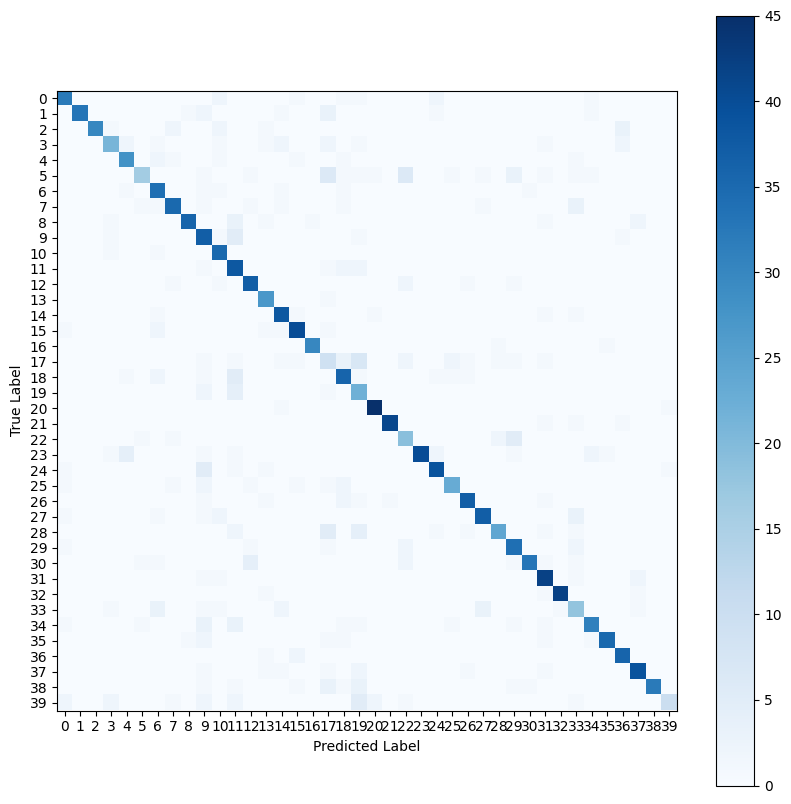

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch

print(len(true_labels))

y_true = np.array(true_label)
y_pred = np.array(predicted_label)

y_true, y_pred
# convert numpy arrays to PyTorch tensors
y_true_t = tf.cast(y_true, dtype='float32')
y_pred_t = tf.cast(y_pred, dtype='float32')


# compute confusion matrix
cm = confusion_matrix(y_true_t, y_pred)

# plot confusion matrix
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(40))
plt.yticks(np.arange(40))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
keras_file = 'densenet121.h5'
keras.models.save_model(model, keras_file)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('herbs_classification_transfer.tflite','wb').write(tflite_model)

<ipython-input-33-ae3284b2905f>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, keras_file)


30084676

In [ ]:
# import os

# def generate_labels_file(train_dir, labels_file):
#     labels = sorted(os.listdir(train_dir))

#     with open(labels_file, 'w') as file:
#         for label in labels:
#             file.write(label + '\n')

#     print(f"Generated {labels_file} with {len(labels)} labels.")

# # Example usage:
# labels_file_path = 'labels.txt'

# generate_labels_file(train_directory, labels_file_path)

Generated labels.txt with 40 labels.


##For Resnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


# Create the ResNet50 base model with pre-trained weights
base_model = ResNet50(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights='imagenet'
)

# Add custom classification layers on top
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(40, activation='softmax')
])

# Print the model summary
model_resnet.summary()


94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 40)                20520     
                                                                 
Total params: 24657320 (94.06 MB)
Trainable params: 246

In [ ]:
model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
epochs = 20  # Adjust the number of epochs as needed
resnet_history = model_resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
797/797 [==============================] - ETA: 0s - loss: 2.5713 - accuracy: 0.3061

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



797/797 [==============================] - 169s 157ms/step - loss: 2.5713 - accuracy: 0.3061 - val_loss: 3.6568 - val_accuracy: 0.1104
Epoch 2/20
797/797 [==============================] - 121s 151ms/step - loss: 1.4817 - accuracy: 0.5748 - val_loss: 2.6099 - val_accuracy: 0.4189
Epoch 3/20
797/797 [==============================] - 121s 152ms/step - loss: 0.9524 - accuracy: 0.7192 - val_loss: 1.4758 - val_accuracy: 0.5916
Epoch 4/20
797/797 [==============================] - 121s 152ms/step - loss: 0.6284 - accuracy: 0.8141 - val_loss: 1.5388 - val_accuracy: 0.6058
Epoch 5/20
797/797 [==============================] - 121s 152ms/step - loss: 0.4311 - accuracy: 0.8690 - val_loss: 1.3298 - val_accuracy: 0.6823
Epoch 6/20
797/797 [==============================] - 121s 152ms/step - loss: 0.3216 - accuracy: 0.9028 - val_loss: 1.7622 - val_accuracy: 0.6163
Epoch 7/20
797/797 [==============================

##Prediction and evaluation for resnet

In [ ]:
import numpy as np
# Reset the generator to start from the beginning
validation_generator.reset()

# Create empty lists to store predicted labels and true labels
resnet_predicted_labels = []
resnet_true_labels = []

# Iterate over the validation data generator and make predictions
for i in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = validation_generator.next()
    predictions = model_resnet.predict(images)

    # Convert predictions and labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert class indices to class labels
    resnet_predicted_labels.extend([key for key, value in validation_generator.class_indices.items() if value == class_idx][0] for class_idx in predicted_classes)

    # Get the true labels from the validation generator
    resnet_true_labels.extend([key for key, value in validation_generator.class_indices.items() if value == np.argmax(labels[idx])] for idx in range(len(labels)))


# Flatten the nested list to a single-dimensional array
resnet_true_labels = [label[0] for label in resnet_true_labels]

resnet_true_label= [validation_generator.class_indices[label] for label in resnet_true_labels]
resnet_predicted_label = [validation_generator.class_indices[label] for label in resnet_predicted_labels]
# Print the converted true labels
# Print the predicted labels and true labels
print("Predicted Labels:", resnet_predicted_label)
print("True Labels:", resnet_true_label)


1/1 [==============================] - 0s 55ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 142ms/step
Predicted Labels: [23, 19, 35, 34, 25, 17, 3, 3, 24, 36, 22, 36, 37, 38, 5, 21, 31, 27, 5, 18, 14, 27, 20, 35, 15, 26, 30, 38, 15, 1, 35, 0, 18, 12, 28, 35, 8, 38, 26, 4, 24, 8, 34, 28, 28, 37, 4, 36, 12, 19, 27, 32, 15, 3, 18, 21, 32, 22, 13, 17, 16, 30, 19, 0, 13, 30, 27, 0, 7, 6, 5, 2, 8, 15, 13, 15, 5, 36, 21, 9, 21, 27, 22, 31, 36, 12, 33, 30, 10, 31, 22, 24, 8, 16, 33, 14, 12, 39, 6, 14, 35, 30, 20, 23, 4, 12, 21, 38, 37, 23, 23, 37, 16, 7, 12, 17, 1, 8, 26, 29, 33, 35, 14, 21, 35, 13, 16, 23, 38, 14, 13, 17, 3, 38, 36, 27, 38, 3, 20, 35, 23, 0, 34, 10, 8, 29, 15, 8, 29, 22, 20, 14, 16, 15, 37, 37, 13, 29, 23, 38, 36, 25, 8, 9, 37, 6, 22, 8, 5, 33, 19, 31, 14, 34, 4, 5, 21, 34, 21, 36, 12, 12, 19, 10, 9, 34, 10, 16, 5, 37, 2, 34, 16, 6, 23, 33, 15, 6, 19, 6, 31, 17, 4, 21, 1, 34, 27, 14, 16, 2, 27, 33, 12, 16, 24, 26, 3, 23, 10, 14, 29, 30, 28, 33, 35, 9, 34, 13, 9, 8, 18, 3, 13, 19, 36, 1, 29, 24, 9, 22, 38, 35, 13, 32, 26, 9,

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Example true labels and predicted labels
true_labels = np.array(resnet_true_label)  # Replace with your true labels
predicted_labels = np.array(resnet_predicted_label)  # Replace with your predicted labels

# Calculate the AUC score for each class
auc_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Check if only one instance of the class is present
    if np.sum(binary_true_labels) == 1 or np.sum(binary_predicted_labels) == 1:
        auc = np.nan  # Set AUC score as NaN
    else:
        # Calculate the AUC score for the current class
        auc = roc_auc_score(binary_true_labels, binary_predicted_labels)
    auc_scores.append(auc)

# Calculate the average AUC score
average_auc_score = np.nanmean(auc_scores)

print("AUC Scores for each class:")
print(auc_scores)
print("Average AUC Score:", average_auc_score)


AUC Scores for each class:
[0.8721537001897532, 0.9150833861093519, 0.8833511621122241, 0.8482152785499835, 0.7412808502972438, 0.7285427601111454, 0.8702561669829222, 0.8292089678510998, 0.8860335589396503, 0.8778951000690131, 0.8912605787605787, 0.8390067446820776, 0.9409098947740738, 0.8154649807192179, 0.9493692339434668, 0.8893995859213251, 0.9665473568281938, 0.734388314059647, 0.8013514566131796, 0.8247595737307225, 0.9445848765849306, 0.9510578197959302, 0.8182898394762802, 0.937656430496727, 0.8011297414706504, 0.702181010069226, 0.7724102150227704, 0.9495276367738297, 0.8157719861259684, 0.9288978079654213, 0.9292817201821642, 0.8397902078996458, 0.9873025944726452, 0.8029924934063704, 0.9160157375915143, 0.9269881480141138, 0.9711984181010729, 0.9329935926897186, 0.8560269787283105, 0.6766881894000538]
Average AUC Score: 0.8641316023878055


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Example true labels and predicted labels
true_labels = np.array(resnet_true_label)  # Replace with your true labels
predicted_labels = np.array(resnet_predicted_label)  # Replace with your predicted labels

# Calculate the F1 score for each class
f1_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Calculate the F1 score for the current class
    f1 = f1_score(binary_true_labels, binary_predicted_labels)
    f1_scores.append(f1)

# Calculate the average F1 score
average_f1_score = np.mean(f1_scores)

print("F1 Scores for each class:")
print(f1_scores)
print("Average F1 Score:", average_f1_score)


F1 Scores for each class:
[0.7594936708860761, 0.8536585365853658, 0.8219178082191781, 0.6575342465753424, 0.5964912280701754, 0.5428571428571429, 0.7058823529411765, 0.6818181818181818, 0.7865168539325843, 0.7865168539325844, 0.8529411764705881, 0.7499999999999999, 0.9047619047619047, 0.5538461538461539, 0.8210526315789475, 0.8181818181818182, 0.8695652173913043, 0.4285714285714286, 0.6382978723404255, 0.6666666666666666, 0.875, 0.8421052631578948, 0.6428571428571429, 0.7966101694915254, 0.725, 0.5416666666666666, 0.6956521739130435, 0.7809523809523808, 0.6329113924050633, 0.6605504587155964, 0.8444444444444444, 0.7901234567901235, 0.9361702127659575, 0.6229508196721313, 0.7789473684210527, 0.8674698795180722, 0.8604651162790696, 0.8367346938775511, 0.64, 0.45454545454545453]
Average F1 Score: 0.7330432210025053


In [ ]:
keras_file = 'resnet50.h5'
keras.models.save_model(model_resnet, keras_file)

<ipython-input-58-1285db88553b>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_resnet, keras_file)


##For VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D


# Create the VGG16 base model with pre-trained weights
base_model = VGG16(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights='imagenet'
)


# Add custom classification layers on to
model_vgg16 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(40, activation='softmax')
])

# Print the model summary
model_vgg16.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 40)                20520     
                                                                 
Total params: 14997864 (57.21 MB)
Trainable params: 283176 (1.08 MB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [ ]:
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
epochs = 20  # Adjust the number of epochs as needed
vgg16_history = model_vgg16.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
797/797 [==============================] - 68s 84ms/step - loss: 2.8126 - accuracy: 0.2542 - val_loss: 2.0976 - val_accuracy: 0.4559
Epoch 2/20
797/797 [==============================] - 62s 78ms/step - loss: 2.1125 - accuracy: 0.4137 - val_loss: 1.7484 - val_accuracy: 0.5330
Epoch 3/20
797/797 [==============================] - 75s 94ms/step - loss: 1.8507 - accuracy: 0.4811 - val_loss: 1.5638 - val_accuracy: 0.5867
Epoch 4/20
797/797 [==============================] - 63s 79ms/step - loss: 1.6985 - accuracy: 0.5171 - val_loss: 1.4830 - val_accuracy: 0.5978
Epoch 5/20
797/797 [==============================] - 64s 81ms/step - loss: 1.5895 - accuracy: 0.5441 - val_loss: 1.4086 - val_accuracy: 0.6237
Epoch 6/20
797/797 [==============================] - 62s 78ms/step - loss: 1.5044 - accuracy: 0.5693 - val_loss: 1.3652 - val_accuracy: 0.6255
Epoch 7/20
797/797 [==============================] - 76s 96ms/step - loss: 1.4277 - accuracy: 0.5868 - val_loss: 1.3460 - val_accuracy:

#Prediction and evaluation for VGG16

In [ ]:
import numpy as np
# Reset the generator to start from the beginning
validation_generator.reset()

# Create empty lists to store predicted labels and true labels
vgg16_predicted_labels = []
vgg16_true_labels = []

# Iterate over the validation data generator and make predictions
for i in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = validation_generator.next()
    predictions = model_vgg16.predict(images)

    # Convert predictions and labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert class indices to class labels
    vgg16_predicted_labels.extend([key for key, value in validation_generator.class_indices.items() if value == class_idx][0] for class_idx in predicted_classes)

    # Get the true labels from the validation generator
    vgg16_true_labels.extend([key for key, value in validation_generator.class_indices.items() if value == np.argmax(labels[idx])] for idx in range(len(labels)))


# Flatten the nested list to a single-dimensional array
vgg16_true_labels = [label[0] for label in vgg16_true_labels]

vgg16_true_label= [validation_generator.class_indices[label] for label in vgg16_true_labels]
vgg16_predicted_label = [validation_generator.class_indices[label] for label in vgg16_predicted_labels]
# Print the converted true labels
# Print the predicted labels and true labels
print("Predicted Labels:", predicted_label)
print("True Labels:", true_label)


1/1 [==============================] - 0s 52ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 39ms/step
Predicted Labels: [37, 14, 19, 35, 21, 27, 11, 22, 14, 20, 38, 12, 19, 31, 15, 30, 23, 22, 27, 28, 6, 0, 5, 6, 32, 14, 29, 32, 30, 14, 5, 38, 34, 0, 27, 12, 32, 36, 30, 7, 27, 12, 26, 21, 23, 15, 5, 15, 29, 25, 18, 6, 8, 7, 8, 7, 38, 21, 34, 34, 31, 8, 6, 4, 13, 31, 2, 27, 21, 1, 28, 20, 35, 7, 15, 4, 0, 32, 19, 18, 32, 14, 11, 20, 27, 34, 13, 27, 37, 31, 21, 32, 30, 12, 23, 29, 31, 36, 38, 6, 5, 27, 33, 38, 22, 24, 9, 15, 2, 32, 9, 31, 9, 6, 6, 30, 28, 9, 0, 36, 11, 0, 36, 2, 24, 24, 8, 18, 23, 37, 17, 21, 3, 1, 17, 17, 38, 30, 27, 13, 37, 16, 12, 18, 38, 16, 8, 21, 33, 15, 13, 23, 36, 16, 7, 31, 23, 10, 6, 19, 13, 14, 20, 28, 17, 21, 36, 32, 19, 10, 15, 11, 8, 27, 36, 13, 16, 15, 29, 17, 38, 37, 6, 34, 22, 30, 34, 37, 1, 3, 8, 27, 33, 18, 20, 27, 36, 3, 18, 9, 33, 16, 5, 39, 38, 16, 36, 33, 26, 36, 1, 19, 33, 22, 33, 8, 13, 21, 3, 34, 1, 34, 20, 20, 34, 29, 22, 29, 27, 39, 29, 8, 30, 18, 32, 23, 1, 21, 26, 37, 8, 30, 33, 19, 38, 14,

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Example true labels and predicted labels
true_labels = np.array(vgg16_true_label)  # Replace with your true labels
predicted_labels = np.array(vgg16_predicted_label)  # Replace with your predicted labels

# Calculate the AUC score for each class
auc_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Check if only one instance of the class is present
    if np.sum(binary_true_labels) == 1 or np.sum(binary_predicted_labels) == 1:
        auc = np.nan  # Set AUC score as NaN
    else:
        # Calculate the AUC score for the current class
        auc = roc_auc_score(binary_true_labels, binary_predicted_labels)
    auc_scores.append(auc)

# Calculate the average AUC score
average_auc_score = np.nanmean(auc_scores)

print("AUC Scores for each class:")
print(auc_scores)
print("Average AUC Score:", average_auc_score)


AUC Scores for each class:
[0.7743674889310563, 0.8661977140444524, 0.9480858374663684, 0.806618110382149, 0.7403350747613042, 0.7131830811979006, 0.8571236559139785, 0.8158770445572476, 0.8523829667230683, 0.8874948240165631, 0.9443676631176632, 0.8481509771141985, 0.913218085890294, 0.7666016500762263, 0.9622645680431514, 0.9002691511387163, 0.8431206733794839, 0.6410732400081153, 0.8236939814093577, 0.7557940564893432, 0.9220376328097543, 0.8961419842047615, 0.7127163483095686, 0.900558336542164, 0.8127450201313838, 0.8680774071743235, 0.8380555715685709, 0.820001410039481, 0.8423611786443645, 0.7738422352577957, 0.9046521012278781, 0.8372489118386548, 0.9771432600112803, 0.7391052951917225, 0.8736813281835476, 0.8504930788021352, 0.9599581834095109, 0.8482048717186191, 0.7679714071597394, 0.6234306340238543]
Average AUC Score: 0.8357161510227437


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Example true labels and predicted labels
true_labels = np.array(vgg16_true_label)  # Replace with your true labels
predicted_labels = np.array(vgg16_predicted_label)  # Replace with your predicted labels

# Calculate the F1 score for each class
f1_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Calculate the F1 score for the current class
    f1 = f1_score(binary_true_labels, binary_predicted_labels)
    f1_scores.append(f1)

# Calculate the average F1 score
average_f1_score = np.mean(f1_scores)

print("F1 Scores for each class:")
print(f1_scores)
print("Average F1 Score:", average_f1_score)


F1 Scores for each class:
[0.6874999999999999, 0.7560975609756099, 0.9210526315789475, 0.6774193548387097, 0.5666666666666667, 0.4556962025316456, 0.6744186046511628, 0.6170212765957447, 0.735632183908046, 0.7659574468085107, 0.88, 0.7045454545454546, 0.7499999999999999, 0.6382978723404255, 0.8695652173913043, 0.8314606741573034, 0.7857142857142857, 0.339622641509434, 0.5365853658536585, 0.5660377358490567, 0.8163265306122448, 0.8333333333333334, 0.5333333333333333, 0.7678571428571428, 0.5585585585585586, 0.6153846153846153, 0.7228915662650602, 0.7160493827160493, 0.6923076923076923, 0.5411764705882354, 0.7659574468085107, 0.7191011235955055, 0.9555555555555556, 0.5454545454545454, 0.576271186440678, 0.6451612903225806, 0.9, 0.7415730337078651, 0.5783132530120482, 0.35000000000000003]
Average F1 Score: 0.6833474309192381


In [ ]:
keras_file = 'vgg16.h5'
keras.models.save_model(model_vgg16, keras_file)

<ipython-input-59-7c262f4ef84b>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_vgg16, keras_file)


###Inception_v3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

# Create the InceptionV3 base model with pre-trained weights
base_model = InceptionV3(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights='imagenet'
)

# Add custom classification layers on top
model_inception_v3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(40, activation='softmax')
])

# Print the model summary
model_inception_v3.summary()


87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 40)                20520     
                                                                 
Total params: 22872392 (87.25 MB)
Trainable params: 106

In [ ]:
# Compile the model
model_inception_v3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 200  # Adjust the number of epochs as needed
incepeionV3_history = model_inception_v3.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
797/797 [==============================] - ETA: 0s - loss: 2.0088 - accuracy: 0.4499

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


797/797 [==============================] - 131s 160ms/step - loss: 2.0088 - accuracy: 0.4499 - val_loss: 1.2512 - val_accuracy: 0.6613
Epoch 2/20
797/797 [==============================] - 78s 98ms/step - loss: 1.4095 - accuracy: 0.5903 - val_loss: 1.0654 - val_accuracy: 0.6965
Epoch 3/20
797/797 [==============================] - 72s 91ms/step - loss: 1.2112 - accuracy: 0.6409 - val_loss: 1.0119 - val_accuracy: 0.7107
Epoch 4/20
797/797 [==============================] - 62s 78ms/step - loss: 1.0904 - accuracy: 0.6725 - val_loss: 0.9594 - val_accuracy: 0.7310
Epoch 5/20
797/797 [==============================] - 67s 84ms/step - loss: 0.9913 - accuracy: 0.7027 - val_loss: 0.9367 - val_accuracy: 0.7360
Epoch 6/20
797/797 [==============================] - 63s 79ms/step - loss: 0.9048 - accuracy: 0.7261 - val_loss: 0.9212 - val_accuracy: 0.7483
Epoch 7/20
797/797 [==============================] - 61s 76ms/step - loss: 0.8408 - accuracy: 0.7418 - val_loss: 0.9213 - val_accuracy: 0.7310
E

#Prediction and Evaluation for Inception_V3

In [ ]:
import numpy as np
# Reset the generator to start from the beginning
validation_generator.reset()

# Create empty lists to store predicted labels and true labels
inception_predicted_labels = []
inception_true_labels = []

# Iterate over the validation data generator and make predictions
for i in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = validation_generator.next()
    predictions = model_inception_v3.predict(images)

    # Convert predictions and labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert class indices to class labels
    inception_predicted_labels.extend([key for key, value in validation_generator.class_indices.items() if value == class_idx][0] for class_idx in predicted_classes)

    # Get the true labels from the validation generator
    inception_true_labels.extend([key for key, value in validation_generator.class_indices.items() if value == np.argmax(labels[idx])] for idx in range(len(labels)))


# Flatten the nested list to a single-dimensional array
inception_true_labels = [label[0] for label in inception_true_labels]

inception_true_label= [validation_generator.class_indices[label] for label in inception_true_labels]
inception_predicted_label = [validation_generator.class_indices[label] for label in inception_predicted_labels]
# Print the converted true labels
# Print the predicted labels and true labels
print("Predicted Labels:", predicted_label)
print("True Labels:", true_label)


1/1 [==============================] - 0s 49ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 34ms/step
Predicted Labels: [33, 33, 3, 22, 26, 19, 30, 27, 18, 9, 2, 6, 31, 31, 1, 29, 6, 23, 18, 35, 34, 7, 10, 37, 32, 5, 2, 2, 6, 4, 23, 20, 15, 30, 13, 28, 16, 35, 12, 38, 37, 4, 11, 11, 18, 28, 29, 17, 13, 2, 10, 23, 31, 20, 34, 10, 13, 36, 0, 21, 18, 29, 13, 31, 29, 12, 38, 18, 4, 35, 33, 22, 27, 37, 9, 12, 8, 32, 0, 4, 10, 1, 31, 35, 2, 30, 30, 36, 26, 1, 26, 33, 24, 21, 18, 23, 23, 1, 26, 30, 9, 15, 3, 11, 32, 18, 24, 29, 13, 32, 4, 0, 24, 7, 12, 23, 7, 27, 8, 20, 14, 26, 0, 25, 37, 5, 29, 29, 6, 14, 2, 17, 20, 5, 29, 15, 29, 0, 8, 13, 16, 10, 14, 18, 29, 25, 2, 0, 3, 13, 23, 38, 12, 24, 24, 10, 6, 22, 14, 39, 29, 23, 27, 29, 34, 36, 37, 22, 8, 1, 31, 15, 34, 10, 24, 37, 10, 31, 2, 24, 14, 9, 5, 15, 24, 6, 2, 10, 35, 7, 5, 3, 11, 1, 37, 13, 28, 39, 3, 24, 39, 38, 26, 23, 28, 22, 16, 0, 25, 28, 36, 31, 13, 12, 18, 5, 23, 11, 20, 28, 8, 5, 24, 12, 16, 23, 24, 18, 5, 35, 31, 7, 12, 8, 20, 6, 29, 6, 31, 13, 37, 36, 30, 33, 36, 33, 3, 30, 2

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Example true labels and predicted labels
true_labels = np.array(inception_true_label)  # Replace with your true labels
predicted_labels = np.array(inception_predicted_label)  # Replace with your predicted labels

# Calculate the AUC score for each class
auc_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Check if only one instance of the class is present
    if np.sum(binary_true_labels) == 1 or np.sum(binary_predicted_labels) == 1:
        auc = np.nan  # Set AUC score as NaN
    else:
        # Calculate the AUC score for the current class
        auc = roc_auc_score(binary_true_labels, binary_predicted_labels)
    auc_scores.append(auc)

# Calculate the average AUC score
average_auc_score = np.nanmean(auc_scores)

print("AUC Scores for each class:")
print(auc_scores)
print("Average AUC Score:", average_auc_score)


AUC Scores for each class:
[0.9087049335863377, 0.8896905817425133, 0.9477697818405783, 0.895798584083917, 0.8670149522608539, 0.7147653596789132, 0.845888678051866, 0.7879371122391426, 0.8507966723068247, 0.8024430641821946, 0.9720260032760033, 0.8383726292730731, 0.927697703893654, 0.8912877768809971, 0.8931308397441566, 0.964216701173223, 0.8884223568281938, 0.6708155812538041, 0.8482370047255544, 0.6862003985444465, 0.9217199708021303, 0.930549951000173, 0.7666016500762263, 0.9565243550250289, 0.8550474147065056, 0.7953016834487099, 0.8910690609327261, 0.8977791878172589, 0.8448896236506857, 0.9323788206236493, 0.952326050613939, 0.9269580145448647, 0.9222222222222223, 0.8039358896327855, 0.8506874387502161, 0.8088904973008837, 0.947137670588998, 0.901714023087945, 0.8835101170231164, 0.7487445072190835]
Average AUC Score: 0.8657301216158348


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Example true labels and predicted labels
true_labels = np.array(inception_true_label)  # Replace with your true labels
predicted_labels = np.array(inception_predicted_label)  # Replace with your predicted labels

# Calculate the F1 score for each class
f1_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Calculate the F1 score for the current class
    f1 = f1_score(binary_true_labels, binary_predicted_labels)
    f1_scores.append(f1)

# Calculate the average F1 score
average_f1_score = np.mean(f1_scores)

print("F1 Scores for each class:")
print(f1_scores)
print("Average F1 Score:", average_f1_score)


F1 Scores for each class:
[0.776470588235294, 0.7764705882352941, 0.9090909090909091, 0.8307692307692308, 0.6933333333333334, 0.48648648648648646, 0.6913580246913581, 0.7027027027027027, 0.6956521739130436, 0.7, 0.9333333333333332, 0.7317073170731707, 0.8409090909090908, 0.7999999999999999, 0.8095238095238095, 0.8686868686868686, 0.78125, 0.3492063492063492, 0.6250000000000001, 0.4313725490196078, 0.8080808080808081, 0.8837209302325582, 0.6382978723404255, 0.8166666666666667, 0.6194690265486725, 0.6785714285714286, 0.7, 0.8181818181818183, 0.7714285714285716, 0.7346938775510203, 0.8791208791208791, 0.7008547008547009, 0.9156626506024096, 0.6551724137931035, 0.775, 0.742857142857143, 0.8860759493670887, 0.8172043010752688, 0.7816091954022988, 0.6086956521739131]
Average F1 Score: 0.7416171810014665


In [ ]:
keras_file = 'inception_v3.h5'
keras.models.save_model(model_inception_v3, keras_file)

<ipython-input-63-b9df1e26ea7a>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_inception_v3, keras_file)


Plot the Roc curve

In [ ]:
class_names = [
    "Achyranthes_aspera",
    "Ageratina_adenophora",
    "Aloe_vera",
    "Amomum_subulatum",
    "Artemisia_vulgaris",
    "Artocarpus_lakoocha",
    "Asparagus_racemosus",
    "Azadirachta_indica",
    "Bergenia_ciliata",
    "Bryophyllum_pinnatum",
    "Cannabis_sativa",
    "Centella_asiatica",
    "Citrus_Limon",
    "Curcuma_caesia",
    "Cuscuta_reflexa",
    "Cynodom_dactylon",
    "Dactylorhiza_hatagirea",
    "Dioscorea_deltoidea",
    "Drymaria_cordata",
    "Inospora_cordifolia",
    "Inula_cappa",
    "Iris_domestica",
    "Juglans_regia",
    "Mentha_spicata",
    "Ocimum_sanctum",
    "Osyris_wightiana",
    "Oxalis_corniculata",
    "Phyllanthus_emblica",
    "Piper_longum",
    "Psidium_guajava",
    "Punica_granatum",
    "Rauwolfia_serpentina",
    "Rhododendron_arboreum",
    "Rhus_javanica",
    "Rubus_ellipticus",
    "Scutellaria_discolor",
    "acorus_calamus",
    "clerodendrum_chinense",
    "coccinia_grandis",
    "smallanthus_sonchifolius"
]

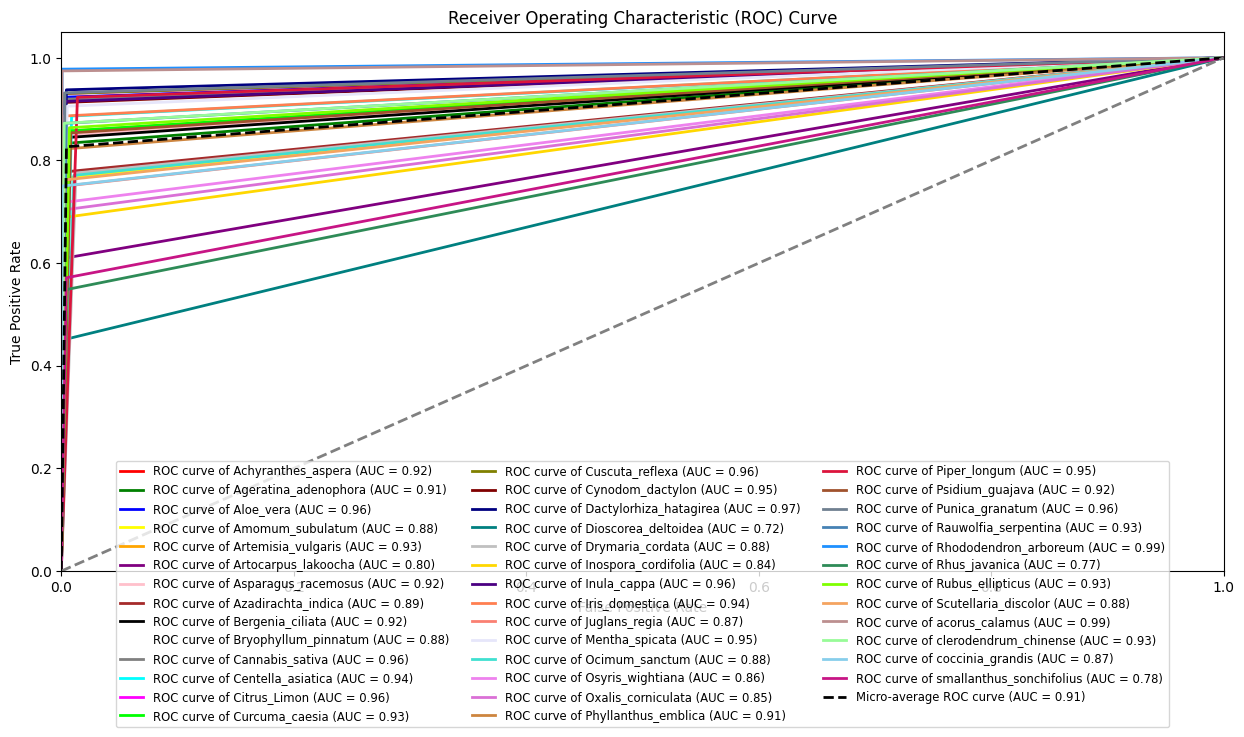

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

p_label = [20, 29, 25, 21, 28, 12, 11, 28, 32, 1, 17, 30, 16, 14, 23, 18, 5, 26, 38, 3, 28, 22, 34, 15, 33, 30, 30, 26, 35, 32, 28, 0, 20, 15, 28, 31, 11, 29, 24, 12, 0, 28, 12, 14, 1, 2, 14, 36, 28, 5, 10, 3, 19, 10, 8, 38, 23, 36, 26, 7, 13, 28, 33, 10, 37, 30, 36, 28, 27, 0, 9, 10, 25, 24, 25, 6, 8, 22, 15, 35, 27, 31, 37, 3, 27, 29, 22, 5, 10, 28, 34, 30, 24, 36, 20, 16, 12, 5, 23, 16, 37, 35, 37, 7, 30, 33, 7, 14, 0, 0, 23, 36, 39, 36, 4, 27, 12, 7, 34, 39, 32, 39, 21, 35, 28, 26, 33, 2, 31, 32, 1, 26, 25, 3, 35, 37, 32, 25, 4, 12, 18, 35, 6, 8, 34, 23, 7, 5, 11, 12, 16, 38, 33, 8, 32, 12, 11, 20, 34, 38, 8, 11, 14, 31, 21, 21, 32, 24, 28, 38, 25, 11, 29, 28, 19, 8, 20, 24, 21, 24, 38, 0, 3, 0, 9, 5, 29, 25, 7, 8, 0, 16, 12, 30, 11, 18, 7, 5, 15, 23, 27, 2, 24, 25, 30, 31, 16, 1, 15, 29, 38, 7, 21, 32, 8, 28, 9, 23, 30, 12, 34, 13, 10, 8, 24, 18, 26, 1, 10, 8, 6, 9, 37, 29, 3, 35, 16, 18, 24, 28, 24, 2, 31, 33, 23, 20, 7, 34, 32, 32, 35, 35, 38, 2, 0, 29, 4, 29, 34, 23, 3, 5, 24, 1, 39, 4, 17, 28, 6, 13, 11, 13, 34, 30, 21, 30, 11, 20, 26, 33, 37, 6, 25, 39, 2, 39, 26, 19, 23, 19, 17, 34, 36, 13, 31, 29, 24, 7, 37, 2, 26, 18, 19, 5, 6, 25, 22, 27, 37, 29, 31, 30, 8, 24, 1, 38, 10, 35, 7, 11, 34, 35, 22, 8, 20, 2, 8, 6, 22, 32, 12, 15, 16, 15, 18, 1, 15, 10, 7, 26, 6, 28, 12, 32, 8, 18, 31, 6, 27, 18, 24, 18, 26, 4, 30, 11, 39, 39, 14, 24, 14, 26, 27, 1, 21, 37, 21, 38, 23, 31, 27, 11, 36, 39, 12, 35, 21, 0, 10, 30, 31, 16, 18, 15, 1, 30, 34, 28, 8, 15, 3, 16, 13, 31, 18, 23, 34, 6, 24, 5, 23, 13, 38, 35, 38, 1, 28, 36, 29, 2, 28, 22, 23, 7, 27, 26, 15, 15, 38, 32, 11, 30, 27, 22, 4, 36, 28, 32, 13, 34, 2, 27, 18, 20, 24, 36, 21, 2, 26, 24, 16, 33, 2, 13, 27, 29, 33, 6, 27, 36, 7, 35, 7, 20, 8, 1, 18, 6, 12, 10, 34, 26, 25, 18, 38, 11, 6, 28, 16, 14, 18, 32, 11, 26, 8, 32, 23, 4, 37, 10, 14, 20, 38, 12, 31, 6, 3, 38, 30, 32, 15, 32, 22, 38, 34, 23, 11, 18, 15, 37, 6, 0, 2, 26, 25, 11, 21, 12, 15, 13, 21, 8, 9, 9, 29, 37, 9, 15, 6, 25, 15, 29, 32, 9, 7, 17, 34, 34, 0, 15, 28, 16, 15, 34, 14, 23, 31, 29, 18, 37, 21, 0, 11, 34, 29, 32, 23, 11, 1, 18, 18, 4, 19, 36, 33, 4, 34, 36, 6, 16, 37, 19, 25, 10, 11, 26, 8, 16, 27, 14, 8, 11, 26, 23, 17, 1, 4, 20, 12, 8, 4, 30, 32, 26, 16, 15, 25, 0, 7, 29, 28, 5, 37, 28, 27, 23, 31, 13, 2, 23, 31, 39, 25, 32, 14, 24, 13, 31, 37, 29, 27, 16, 13, 12, 24, 17, 10, 18, 7, 14, 15, 36, 20, 29, 0, 39, 18, 2, 10, 26, 29, 9, 11, 29, 34, 10, 4, 26, 21, 15, 28, 33, 31, 0, 35, 20, 1, 5, 8, 8, 4, 39, 32, 1, 31, 33, 3, 14, 9, 11, 11, 8, 23, 12, 11, 15, 28, 29, 39, 17, 36, 1, 18, 20, 5, 9, 7, 29, 29, 34, 15, 13, 13, 22, 22, 7, 4, 0, 30, 16, 28, 6, 38, 20, 35, 6, 12, 7, 5, 1, 18, 18, 18, 36, 8, 2, 9, 9, 37, 5, 13, 32, 18, 18, 29, 27, 9, 23, 23, 2, 10, 13, 30, 3, 31, 23, 24, 29, 33, 23, 24, 0, 1, 30, 9, 20, 6, 20, 16, 15, 24, 37, 36, 20, 0, 6, 19, 31, 39, 6, 35, 4, 15, 36, 6, 37, 10, 11, 21, 12, 6, 11, 27, 6, 26, 13, 2, 34, 12, 21, 22, 18, 4, 3, 11, 26, 14, 26, 24, 6, 13, 34, 35, 19, 24, 11, 30, 32, 2, 6, 10, 28, 31, 23, 7, 28, 4, 18, 5, 14, 23, 35, 12, 14, 36, 15, 1, 7, 24, 30, 18, 34, 10, 37, 25, 23, 30, 0, 22, 2, 18, 17, 27, 22, 19, 26, 9, 28, 15, 18, 1, 20, 31, 10, 27, 8, 7, 12, 0, 32, 28, 14, 32, 35, 30, 1, 25, 28, 5, 28, 23, 30, 38, 1, 2, 32, 19, 16, 4, 26, 37, 4, 0, 25, 24, 26, 28, 0, 23, 5, 9, 27, 0, 7, 20, 21, 17, 21, 19, 8, 4, 27, 8, 33, 16, 30, 24, 22, 35, 0, 12, 24, 21, 26, 27, 24, 14, 7, 32, 17, 1, 18, 14, 15, 13, 27, 37, 34, 11, 12, 23, 31, 2, 18, 27, 7, 13, 7, 18, 28, 38, 26, 14, 9, 8, 36, 1, 20, 30, 20, 28, 29, 36, 12, 14, 5, 22, 2, 11, 3, 6, 27, 29, 3, 24, 4, 31, 22, 31, 31, 2, 21, 11, 3, 15, 20, 10, 38, 39, 18, 1, 23, 26, 23, 27, 13, 21, 16, 34, 7, 32, 28, 24, 29, 1, 23, 8, 28, 16, 1, 6, 30, 24, 33, 38, 11, 35, 4, 10, 14, 11, 38, 6, 13, 23, 2, 9, 6, 30, 27, 25, 2, 16, 21, 21, 30, 3, 1, 37, 30, 30, 23, 4, 21, 5, 23, 38, 5, 14, 11, 8, 34, 15, 28, 24, 14, 12, 21, 34, 6, 7, 11, 20, 36, 19, 10, 39, 24, 21, 26, 20, 4, 8, 9, 18, 38, 19, 9, 37, 7, 37, 21, 38, 13, 17, 19, 10, 12, 0, 14, 39, 7, 0, 23, 32, 2, 9, 9, 21, 37, 18, 34, 14, 22, 35, 0, 24, 26, 1, 9, 6, 14, 33, 39, 29, 22, 1, 7, 12, 31, 29, 37, 15, 7, 35, 15, 30, 9, 14, 16, 20, 8, 7, 9, 11, 2, 9, 18, 14, 16, 10, 34, 12, 9, 22, 18, 27, 7, 32, 23, 29, 22, 32, 31, 6, 1, 27, 16, 8, 11, 36, 23, 24, 29, 35, 33, 28, 9, 6, 21, 29, 8, 15, 34, 24, 24, 22, 9, 28, 11, 30, 11, 18, 31, 31, 21, 2, 2, 16, 39, 20, 22, 32, 35, 6, 28, 18, 11, 31, 21, 16, 34, 11, 20, 32, 0, 7, 12, 25, 38, 5, 29, 15, 19, 31, 19, 28, 11, 15, 14, 36, 21, 9, 12, 37, 18, 3, 35, 4, 14, 36, 3, 9, 33, 16, 18, 35, 9, 15, 34, 3, 13, 21, 39, 1, 29, 37, 35, 12, 20, 37, 14, 37, 8, 13, 36, 3, 4, 37, 37, 28, 23, 23, 32, 20, 23, 13, 4, 29, 30, 12, 3, 0, 5, 12, 2, 31, 32, 34, 20, 16, 25, 21, 36, 19, 20, 30, 34, 24, 0, 32, 28, 20, 28, 31, 34, 1, 9, 10, 36, 26, 31, 17, 17, 28, 27, 30, 33, 16, 27, 11, 9, 34, 32, 20, 18, 10, 10, 20, 11, 1, 21, 31, 38, 18, 8, 4, 29, 28, 8, 18, 11, 8, 13, 30, 6, 31, 15, 18, 37, 23, 27, 29, 31, 10, 33, 37, 4, 10, 24, 14, 7, 20, 18, 12, 4, 8, 22, 14, 34, 24, 30, 33, 23, 10, 37, 31, 15, 31, 32, 10, 24, 2, 20, 2, 30, 23, 24, 28, 34, 30, 20, 5, 34, 15, 4, 14, 15, 29, 20, 34, 28, 22, 33, 16, 8, 8, 11, 24, 28, 28, 23, 4, 27, 38, 37, 20, 21, 31, 25, 9, 11, 20, 21, 28, 37, 19, 3, 7, 17, 9, 6, 18, 6, 2, 32, 29, 33, 9, 35, 8, 34, 23, 8, 4, 29, 0, 36, 14, 34, 35, 29, 6, 37, 6, 21, 15, 10, 13, 14, 31, 39, 32, 17, 5, 5, 25, 17, 20, 6, 34, 24, 25, 24, 15, 37, 5, 11, 23, 3, 37, 19, 15, 15, 0, 23, 8, 25, 29, 9, 20, 14, 22, 29, 2, 24, 14, 20, 37, 18, 9, 17, 0, 32, 23, 9, 12, 13, 18, 28, 36, 34, 35, 21, 36, 36, 1, 4, 1, 31, 38, 34, 19, 25, 1, 7, 13, 24, 30, 6, 18, 1, 26, 11, 4, 29, 24, 37, 23, 19, 0, 1, 36, 17, 19, 15, 30, 28, 12, 18, 6, 16, 18, 31, 12, 37, 27, 25, 16, 18, 12, 3, 25, 36, 34, 1, 4, 3, 35, 3, 15, 11, 2, 39, 35, 9, 21, 30, 38, 35, 2, 36, 24, 28, 0, 4, 27, 0, 27, 0, 38, 23, 7, 0, 39, 31, 33, 31, 20, 26, 14, 6, 5, 4, 26, 30, 18, 36, 27, 28, 14, 23, 24, 19, 36, 17, 31, 13, 5, 26, 26, 9, 11, 0, 3, 16, 14, 24, 16, 32, 19, 32, 17, 6, 0, 35, 4, 19, 5, 2, 25, 9, 27, 38, 24, 15, 19, 11, 36, 2, 29, 12, 14, 12, 23, 20, 38, 1, 27, 19, 20]
t_label = [20, 29, 25, 21, 13, 12, 26, 28, 32, 1, 17, 30, 16, 14, 23, 18, 5, 26, 38, 3, 5, 22, 34, 15, 1, 30, 30, 26, 24, 32, 5, 0, 20, 15, 28, 31, 18, 19, 24, 12, 0, 28, 12, 17, 1, 2, 14, 36, 19, 3, 10, 3, 19, 10, 30, 38, 23, 36, 26, 7, 13, 28, 33, 10, 37, 6, 36, 28, 27, 0, 9, 10, 25, 24, 25, 6, 8, 7, 15, 35, 27, 31, 37, 3, 27, 29, 22, 5, 10, 28, 34, 30, 24, 36, 20, 16, 12, 5, 23, 35, 37, 35, 37, 7, 30, 33, 7, 14, 18, 0, 23, 36, 39, 36, 4, 27, 12, 7, 9, 38, 32, 34, 21, 35, 28, 26, 33, 2, 31, 32, 1, 26, 17, 3, 35, 39, 32, 9, 4, 12, 18, 35, 6, 23, 34, 23, 18, 29, 11, 12, 16, 38, 33, 13, 32, 12, 31, 5, 34, 38, 8, 11, 14, 31, 21, 21, 32, 24, 28, 38, 26, 11, 29, 22, 11, 8, 20, 24, 21, 24, 38, 0, 3, 0, 9, 22, 29, 25, 7, 8, 0, 16, 12, 30, 11, 18, 7, 5, 15, 23, 27, 2, 38, 25, 30, 31, 16, 37, 15, 29, 38, 7, 21, 32, 8, 1, 9, 23, 30, 12, 5, 13, 10, 8, 24, 18, 26, 1, 10, 8, 6, 25, 37, 29, 3, 35, 16, 26, 24, 28, 24, 2, 31, 33, 23, 20, 6, 34, 32, 32, 39, 35, 38, 2, 0, 29, 30, 22, 26, 17, 3, 5, 0, 34, 39, 4, 17, 28, 14, 13, 11, 13, 34, 30, 21, 30, 11, 20, 26, 33, 37, 6, 25, 39, 2, 39, 35, 19, 23, 19, 17, 34, 36, 13, 31, 22, 24, 7, 37, 2, 26, 18, 19, 5, 6, 25, 17, 27, 37, 22, 31, 30, 8, 24, 1, 38, 10, 35, 24, 11, 29, 35, 22, 8, 20, 2, 8, 6, 22, 32, 25, 35, 16, 10, 18, 1, 15, 10, 7, 26, 6, 28, 12, 32, 8, 18, 24, 6, 27, 18, 24, 18, 26, 4, 30, 11, 39, 39, 14, 23, 14, 26, 27, 9, 21, 37, 21, 38, 23, 31, 27, 19, 36, 39, 12, 35, 21, 0, 10, 30, 31, 16, 18, 15, 1, 30, 34, 28, 8, 36, 3, 35, 3, 31, 18, 24, 34, 4, 24, 5, 23, 39, 38, 35, 38, 1, 38, 36, 29, 2, 5, 22, 23, 7, 27, 18, 15, 15, 38, 32, 11, 30, 27, 22, 3, 36, 28, 32, 13, 34, 2, 27, 18, 20, 24, 36, 21, 2, 34, 16, 16, 33, 2, 13, 27, 5, 33, 6, 27, 36, 7, 35, 7, 20, 8, 1, 18, 14, 12, 10, 34, 26, 11, 18, 38, 11, 6, 28, 16, 14, 26, 32, 19, 26, 8, 32, 39, 10, 37, 10, 14, 20, 38, 12, 31, 7, 3, 38, 30, 32, 15, 32, 22, 38, 34, 23, 11, 18, 15, 37, 6, 0, 3, 26, 25, 8, 21, 12, 15, 13, 21, 8, 9, 9, 29, 37, 9, 15, 6, 25, 15, 5, 32, 9, 6, 17, 34, 34, 0, 15, 17, 16, 15, 34, 14, 28, 31, 29, 18, 37, 21, 24, 19, 34, 7, 32, 23, 26, 1, 18, 26, 33, 19, 36, 27, 4, 29, 36, 33, 16, 37, 8, 25, 10, 11, 26, 8, 16, 27, 14, 8, 11, 26, 23, 38, 1, 4, 20, 12, 8, 4, 30, 32, 26, 16, 15, 25, 0, 7, 29, 31, 5, 37, 17, 13, 23, 21, 13, 2, 23, 1, 37, 25, 32, 14, 24, 13, 31, 37, 29, 27, 32, 21, 12, 24, 25, 10, 21, 7, 14, 15, 36, 20, 29, 0, 39, 18, 2, 10, 34, 5, 9, 11, 29, 0, 10, 4, 26, 21, 15, 38, 30, 1, 0, 35, 20, 1, 5, 8, 8, 0, 39, 32, 1, 31, 7, 3, 14, 9, 11, 11, 8, 23, 12, 11, 15, 28, 29, 39, 17, 36, 1, 18, 20, 5, 9, 7, 29, 29, 33, 15, 13, 13, 22, 24, 7, 4, 0, 30, 16, 28, 6, 38, 20, 35, 18, 12, 7, 5, 1, 18, 19, 18, 36, 8, 2, 9, 35, 37, 5, 13, 32, 18, 26, 29, 27, 9, 23, 23, 2, 10, 13, 30, 3, 31, 23, 33, 5, 33, 23, 27, 0, 8, 21, 11, 20, 33, 20, 31, 15, 1, 37, 36, 20, 0, 6, 19, 31, 16, 6, 35, 4, 15, 36, 27, 37, 10, 11, 21, 12, 6, 11, 27, 6, 17, 13, 2, 34, 12, 21, 24, 18, 4, 3, 19, 26, 14, 26, 24, 6, 9, 34, 35, 19, 27, 11, 30, 32, 2, 6, 10, 28, 31, 23, 7, 28, 4, 3, 5, 14, 23, 35, 12, 14, 36, 15, 1, 7, 4, 30, 4, 34, 10, 37, 25, 2, 7, 0, 22, 2, 11, 19, 27, 22, 19, 26, 35, 17, 15, 18, 20, 20, 31, 10, 7, 39, 7, 12, 18, 32, 28, 14, 21, 35, 30, 1, 25, 28, 5, 28, 23, 30, 38, 1, 2, 32, 19, 20, 4, 26, 37, 4, 0, 25, 24, 26, 28, 0, 23, 5, 9, 27, 15, 7, 20, 21, 17, 21, 19, 8, 4, 27, 9, 17, 16, 30, 26, 22, 35, 0, 29, 24, 21, 25, 27, 24, 14, 7, 32, 17, 1, 24, 14, 6, 9, 27, 37, 34, 11, 12, 23, 37, 2, 17, 27, 7, 13, 7, 17, 28, 11, 18, 5, 9, 8, 36, 1, 20, 30, 20, 28, 29, 36, 12, 14, 5, 5, 2, 11, 3, 6, 27, 22, 3, 33, 4, 31, 22, 31, 33, 2, 21, 11, 3, 0, 20, 10, 38, 20, 37, 1, 23, 26, 23, 27, 13, 21, 16, 29, 7, 32, 28, 24, 29, 38, 23, 8, 28, 16, 1, 6, 30, 24, 33, 38, 11, 35, 4, 10, 14, 11, 38, 6, 13, 23, 9, 9, 6, 30, 27, 28, 2, 16, 21, 21, 30, 3, 1, 37, 30, 30, 23, 4, 21, 5, 1, 38, 5, 14, 11, 8, 34, 15, 28, 24, 14, 12, 21, 34, 6, 7, 11, 20, 36, 38, 10, 22, 24, 21, 26, 20, 4, 8, 9, 18, 38, 19, 9, 37, 7, 37, 21, 38, 13, 17, 19, 10, 12, 0, 14, 39, 7, 0, 23, 32, 2, 9, 9, 21, 37, 18, 34, 14, 22, 35, 0, 33, 26, 1, 9, 6, 14, 33, 39, 29, 22, 1, 7, 12, 31, 29, 37, 15, 17, 35, 15, 30, 9, 14, 16, 20, 8, 7, 9, 11, 2, 9, 25, 14, 16, 10, 34, 12, 9, 22, 18, 27, 7, 32, 23, 29, 22, 32, 31, 6, 1, 33, 16, 8, 11, 36, 25, 39, 29, 35, 33, 17, 9, 6, 21, 29, 8, 15, 34, 0, 24, 22, 9, 28, 9, 30, 11, 38, 31, 31, 21, 2, 2, 16, 5, 39, 22, 32, 35, 6, 15, 18, 11, 31, 21, 13, 34, 23, 20, 32, 24, 7, 12, 25, 38, 5, 12, 15, 19, 31, 19, 28, 11, 15, 14, 36, 21, 9, 12, 37, 18, 3, 35, 4, 14, 36, 3, 24, 33, 16, 18, 35, 9, 15, 34, 3, 13, 21, 39, 1, 29, 37, 35, 7, 20, 37, 14, 37, 34, 2, 36, 3, 4, 37, 37, 28, 23, 23, 32, 20, 23, 13, 4, 29, 30, 12, 3, 0, 38, 12, 2, 31, 32, 34, 20, 33, 25, 21, 36, 19, 20, 30, 5, 24, 0, 32, 5, 39, 28, 31, 34, 1, 17, 10, 36, 26, 31, 17, 17, 3, 27, 30, 27, 16, 27, 11, 9, 34, 32, 29, 18, 10, 10, 20, 11, 38, 21, 31, 38, 18, 8, 7, 29, 31, 8, 18, 11, 8, 8, 30, 1, 31, 15, 18, 37, 23, 27, 29, 8, 10, 33, 39, 4, 10, 24, 27, 7, 20, 18, 12, 33, 8, 22, 14, 34, 24, 31, 33, 23, 10, 8, 31, 15, 31, 32, 10, 18, 2, 20, 2, 30, 23, 24, 17, 34, 30, 20, 5, 34, 15, 4, 33, 15, 29, 20, 9, 28, 22, 33, 16, 35, 8, 11, 24, 28, 28, 23, 4, 27, 38, 37, 20, 20, 31, 25, 17, 9, 20, 39, 28, 5, 19, 3, 7, 31, 9, 6, 26, 4, 3, 32, 29, 33, 9, 35, 8, 34, 23, 8, 4, 29, 0, 36, 14, 34, 35, 27, 6, 37, 6, 21, 0, 10, 3, 14, 31, 39, 32, 17, 12, 5, 25, 17, 10, 6, 34, 24, 25, 18, 15, 37, 5, 26, 23, 3, 37, 19, 15, 15, 0, 23, 8, 25, 29, 34, 20, 14, 22, 5, 2, 24, 14, 20, 37, 26, 9, 35, 35, 32, 7, 39, 12, 13, 18, 37, 36, 34, 18, 21, 36, 36, 1, 4, 1, 31, 38, 34, 38, 37, 1, 6, 13, 23, 25, 6, 8, 1, 7, 18, 14, 29, 24, 37, 23, 25, 0, 1, 36, 19, 17, 15, 30, 12, 12, 26, 4, 16, 18, 31, 12, 37, 33, 25, 16, 6, 12, 3, 25, 15, 35, 1, 4, 3, 35, 3, 15, 11, 2, 39, 35, 9, 21, 30, 38, 24, 2, 36, 24, 23, 0, 4, 27, 0, 27, 0, 38, 23, 7, 25, 39, 31, 27, 31, 20, 26, 14, 6, 5, 4, 26, 30, 18, 36, 27, 28, 14, 23, 24, 19, 36, 17, 31, 13, 5, 26, 26, 9, 11, 0, 9, 16, 14, 24, 16, 32, 39, 32, 17, 15, 0, 35, 33, 19, 5, 2, 2, 9, 27, 38, 24, 15, 28, 11, 36, 2, 29, 12, 14, 12, 23, 20, 38, 1, 27, 19, 20]
t_label = np.array(t_label)
p_label = np.array(p_label)

# Convert true labels to binary matrix
n_classes = 40
t_label_binary = label_binarize(t_label, classes=np.arange(n_classes))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(t_label_binary[:, i], p_label == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
t_label_binary = label_binarize(t_label, classes=np.arange(n_classes))
p_label_binary = label_binarize(p_label, classes=np.arange(n_classes))

fpr["micro"], tpr["micro"], _ = roc_curve(t_label_binary.ravel(), p_label_binary.ravel())
roc_auc["micro"] = roc_auc_score(t_label_binary, p_label_binary, average='micro')

# Plot ROC curve for each class
plt.figure(figsize=(15, 7))
lw = 2
colors = [
    "red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "black", "white",
    "gray", "cyan", "magenta", "lime", "olive", "maroon", "navy", "teal", "silver", "gold",
    "indigo", "coral", "salmon", "lavender", "turquoise", "violet", "orchid", "peru", "crimson",
    "sienna", "slategray", "steelblue", "dodgerblue", "seagreen", "chartreuse", "sandybrown",
    "rosybrown", "palegreen", "skyblue", "mediumvioletred", "darkkhaki", "khaki"
]
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label= f"ROC curve of {class_names[i]} (AUC = {roc_auc[i]:0.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=lw, linestyle='--',
         label='Micro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, fontsize='small')
plt.show()


In [ ]:
plt.savefig('Roc_dense.png')


<Figure size 640x480 with 0 Axes>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.densenet import DenseNet121

# Load the image from file path
img_path = '/content/resized.JPG'  # Update with your image path
image = Image.open(img_path)

# Resize the image to 256x256 pixels
resized_image = image.resize((256, 256))

# Convert the image to a NumPy array
image_array = tf.keras.preprocessing.image.img_to_array(resized_image)

# Expand dimensions to match the expected input shape of the model
input_image = tf.expand_dims(image_array, axis=0)

# Normalize the input image
input_image = input_image / 255.0

# Create the DenseNet121 base model
base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))

# Add custom classification layers on top
model_dense = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(40, activation='softmax')
])

# Load the pre-trained weights (optional)
# model_dense.load_weights('path_to_weights.h5')

# Compile the model (optional)
# model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get the successive feature maps from each layer
successive_feature_maps = []
for layer in model_dense.layers:
    if hasattr(layer, 'activation'):
        if layer.activation == tf.keras.activations.relu:
            successive_feature_maps.append(layer.output)

# Create a visualization model that outputs the feature maps
visualization_model = tf.keras.models.Model(inputs=model_dense.input, outputs=successive_feature_maps)

# Pass the input image through the visualization model
successive_feature_maps = visualization_model.predict(input_image)

# Retrieve the names of the layers to include in the plot
layer_names = [layer.name for layer in model_dense.layers]

# Plot the feature maps
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(layer_name, feature_map.shape)
    if len(feature_map.shape) == 1:
        # Plot feature maps for the convolutional / max-pooling layers
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        print(n_features)
        for i in range(n_features):
          print("hello")
          x = feature_map[0, :, :, i]
          x -= x.mean()
          x /= x.std()
          x *= 64
          x += 128
          x = np.clip(x, 0, 255).astype('uint8')
          display_grid[:, i * size : (i + 1) * size] = x

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)


plt.show()


1/1 [==============================] - 2s 2s/step
densenet121 (512,)


IndexError: ignored

Umap

In [ ]:
def embedding_fc2(data):
    model.eval()
    img = torch.Tensor(data.reshape(-1,1,256, 256)).float() #transform the image
    out = model.conv(img) #pass through CNN
    out = model.relu(model.fc1(out)) #pass through FC 1
    out = model.relu(model.fc2(out)) #pass through FC 2
    return out

In [ ]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=f56b7c2f6a356d389307c787c786e1d81d25b133b0e80881cdae67a37ae692b9
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
import umap
umap_hparams = {'n_neighbors':40,
                'min_dist':0.1,
                'n_components':2,
                'metric':'euclidean'}

# Get the total number of images in the train_generator
num_images = len(train_generator.filenames)

# Get the batch size of the train_generator
batch_size = train_generator.batch_size

# Initialize empty NumPy arrays to store the images and labels
images = np.empty((num_images,) + train_generator.image_shape, dtype=np.float32)
labels = np.empty((num_images,), dtype=np.int32)

# Iterate over the train_generator and retrieve the images and labels
for i in range(num_images // batch_size):
    batch_images, batch_labels = train_generator.next()
    start = i * batch_size
    end = (i + 1) * batch_size
    images[start:end] = batch_images
    labels[start:end] = np.argmax(batch_labels, axis=1)

# Normalize the pixel values to the range [0, 1]
images /= 255.0

embedding = embedding_fc2(images)

fig, ax = plt.subplots(figsize=(11,8), constrained_layout=False)
ax.set(xticks=[], yticks=[])

umap_embedding = umap.UMAP(n_neighbors=umap_hparams['n_neighbors'], min_dist=umap_hparams['min_dist'], n_components=umap_hparams['n_components'], metric=umap_hparams['metric']).fit_transform(embedding.detach().numpy())
scatter = ax.scatter(x = umap_embedding[:,0], y = umap_embedding[:,1], s=0.3, c=labels, cmap='tab10')

cbar = plt.colorbar(scatter, boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))

plt.title('UMAP Dimensionality reduction', fontsize=25, fontweight='bold')
plt.show()

NameError: ignored

AUC Scores:
Class Achyranthes_aspera: 0.49
Class Ageratina_adenophora: 0.52
Class Aloe_vera: 0.54
Class Amomum_subulatum: 0.55
Class Artemisia_vulgaris: 0.53
Class Artocarpus_lakoocha: 0.56
Class Asparagus_racemosus: 0.53
Class Azadirachta_indica: 0.44
Class Bergenia_ciliata: 0.47
Class Bryophyllum_pinnatum: 0.56


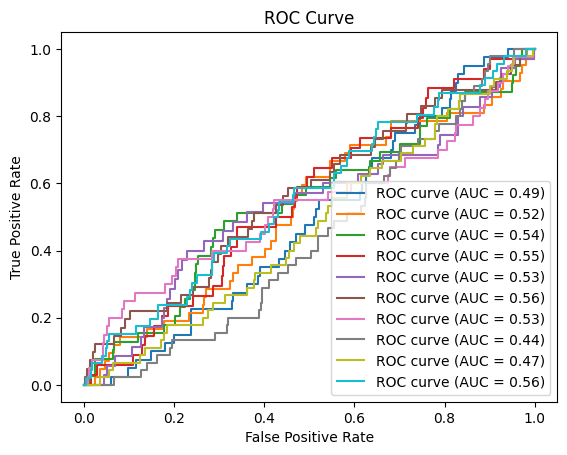

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# in a multi-class classification problem, where the rows represent
# Initialize an array to store the AUC scores for each class
auc_scores = []

# Initialize a figure to plot the ROC curves
plt.figure()

# Iterate over each class
for i in range(10):
    # Create a binary vector of true labels for this class (1 for positive instances, 0 for negative instances)
    y_true_binary = np.array([1 if x == i else 0 for x in test_label.flatten().tolist()])
    # Calculate the FPR, TPR, and probability thresholds for this class
    try:
        fpr, tpr, thresholds = roc_curve(y_true_binary, logits[:, i])
    except Exception as e:
        print("Error:", e)
        print("y_true_binary:", y_true_binary.shape)
        print("y_true_binary:", prediction_logits.shape)
        break

    # Calculate the AUC for this class
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # Plot the ROC curve for this class
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)

# Add labels and legend to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Print the AUC scores for each class
print("AUC Scores:")
for i in range(10):
    print("Class {}: {:.2f}".format(class_names[i], auc_scores[i]))

# Show the plot
plt.show()

##Efficientnet_v2 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

# Create the InceptionV3 base model with pre-trained weights
base_model = efficientnet_v2.EfficientNetV2S(
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
    weights='imagenet'
)


# Add custom classification layers on top
model_efficientnet_v2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(40, activation='softmax')
])

# Print the model summary
model_efficientnet_v2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 8, 8, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 40)                20520     
                                                                 
Total params: 21007752 (80.14 MB)
Trainable params: 2085

In [ ]:
# Compile the model
model_efficientnet_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs = 20  # Adjust the number of epochs as needed
model_efficientnet_v2_history = model_efficientnet_v2.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
797/797 [==============================] - ETA: 0s - loss: 1.3213 - accuracy: 0.6385

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



797/797 [==============================] - 306s 241ms/step - loss: 1.3213 - accuracy: 0.6385 - val_loss: 1.1545 - val_accuracy: 0.6983
Epoch 2/20
797/797 [==============================] - 202s 253ms/step - loss: 0.5310 - accuracy: 0.8455 - val_loss: 2.2830 - val_accuracy: 0.5022
Epoch 3/20
797/797 [==============================] - 219s 275ms/step - loss: 0.3615 - accuracy: 0.8913 - val_loss: 4.9990 - val_accuracy: 0.0969
Epoch 4/20
797/797 [==============================] - 188s 236ms/step - loss: 0.2689 - accuracy: 0.9195 - val_loss: 6.7974 - val_accuracy: 0.0487
Epoch 5/20
797/797 [==============================] - 188s 236ms/step - loss: 0.2267 - accuracy: 0.9330 - val_loss: 3.1628 - val_accuracy: 0.3843
Epoch 6/20
797/797 [==============================] - 185s 232ms/step - loss: 0.1945 - accuracy: 0.9425 - val_loss: 0.9330 - val_accuracy: 0.8155
Epoch 7/20
797/797 [==============================

#Efficientnet_v2 model prediction and evaluation

In [ ]:
import numpy as np
# Reset the generator to start from the beginning
validation_generator.reset()

# Create empty lists to store predicted labels and true labels
efficientv2_predicted_labels = []
efficientv2_true_labels = []

# Iterate over the validation data generator and make predictions
for i in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = validation_generator.next()
    predictions = model_efficientnet_v2.predict(images)

    # Convert predictions and labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert class indices to class labels
    efficientv2_predicted_labels.extend([key for key, value in validation_generator.class_indices.items() if value == class_idx][0] for class_idx in predicted_classes)

    # Get the true labels from the validation generator
    efficientv2_true_labels.extend([key for key, value in validation_generator.class_indices.items() if value == np.argmax(labels[idx])] for idx in range(len(labels)))


# Flatten the nested list to a single-dimensional array
efficientv2_true_labels = [label[0] for label in efficientv2_true_labels]

efficientv2_true_label= [validation_generator.class_indices[label] for label in efficientv2_true_labels]
efficientv2_predicted_label = [validation_generator.class_indices[label] for label in efficientv2_predicted_labels]
# Print the converted true labels
# Print the predicted labels and true labels
print("Predicted Labels:", efficientv2_predicted_label)
print("True Labels:", efficientv2_true_label)


1/1 [==============================] - 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 43ms/step
Predicted Labels: [18, 32, 16, 32, 16, 8, 32, 15, 26, 16, 32, 32, 30, 32, 15, 22, 32, 32, 32, 15, 35, 18, 16, 33, 24, 18, 32, 0, 16, 26, 29, 32, 22, 32, 15, 32, 0, 33, 0, 15, 32, 0, 32, 18, 32, 15, 22, 16, 21, 35, 15, 0, 16, 17, 35, 15, 32, 30, 16, 15, 15, 16, 26, 24, 32, 32, 15, 16, 16, 35, 16, 16, 16, 35, 32, 10, 34, 16, 32, 16, 35, 16, 35, 15, 35, 16, 33, 15, 16, 15, 21, 0, 15, 0, 16, 0, 8, 35, 32, 16, 16, 15, 16, 1, 13, 15, 23, 35, 15, 32, 20, 11, 32, 15, 16, 0, 35, 16, 10, 32, 32, 11, 16, 16, 34, 2, 32, 16, 24, 32, 35, 0, 15, 16, 35, 18, 15, 18, 32, 18, 15, 16, 15, 32, 16, 32, 15, 32, 32, 30, 32, 16, 20, 16, 32, 10, 32, 16, 32, 35, 2, 25, 16, 18, 0, 35, 2, 35, 15, 16, 32, 35, 0, 0, 15, 16, 32, 35, 0, 32, 32, 32, 16, 16, 15, 16, 32, 32, 32, 0, 0, 0, 0, 15, 16, 16, 30, 30, 32, 16, 32, 35, 0, 16, 26, 16, 16, 32, 32, 16, 33, 16, 0, 32, 27, 32, 32, 0, 32, 32, 32, 35, 33, 32, 15, 16, 26, 32, 32, 32, 32, 15, 18, 32, 0, 32, 2, 15, 32, 16

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Example true labels and predicted labels
true_labels = np.array(efficientv2_true_label)  # Replace with your true labels
predicted_labels = np.array(efficientv2_predicted_label)  # Replace with your predicted labels

# Calculate the AUC score for each class
auc_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Check if only one instance of the class is present
    if np.sum(binary_true_labels) == 1 or np.sum(binary_predicted_labels) == 1:
        auc = np.nan  # Set AUC score as NaN
    else:
        # Calculate the AUC score for the current class
        auc = roc_auc_score(binary_true_labels, binary_predicted_labels)
    auc_scores.append(auc)

# Calculate the average AUC score
average_auc_score = np.nanmean(auc_scores)

print("AUC Scores for each class:")
print(auc_scores)
print("Average AUC Score:", average_auc_score)


AUC Scores for each class:
[0.6598355471220746, 0.5106381374589101, 0.6525819313429934, 0.5284665851217614, 0.5838227346424067, 0.5327878974992282, nan, nan, 0.5092075578116186, nan, 0.7275201337701338, 0.6363636363636364, 0.5, 0.606828983947628, 0.5345668641494974, 0.6637405106970323, 0.689368313404657, 0.5155001014404544, 0.7063600249260009, 0.6031342055103102, 0.6379802103328016, 0.6224635383639824, 0.5172293964666845, 0.5471698113207547, 0.5485868298368299, 0.49811202013845185, 0.702008992909437, 0.5768260011280315, 0.5256410256410257, nan, 0.5697166657058859, nan, 0.7635716300056401, 0.6062994522215459, 0.521776099613766, 0.585037244790253, 0.5641025641025641, 0.49777636594663277, 0.5325056205683979, 0.5]
Average AUC Score: 0.585072189551458


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Example true labels and predicted labels
true_labels = np.array(efficientv2_true_label)  # Replace with your true labels
predicted_labels = np.array(efficientv2_predicted_label)  # Replace with your predicted labels

# Calculate the F1 score for each class
f1_scores = []
for class_index in range(40):
    # Create binary labels for the current class
    binary_true_labels = np.where(true_labels == class_index, 1, 0)
    binary_predicted_labels = np.where(predicted_labels == class_index, 1, 0)

    # Calculate the F1 score for the current class
    f1 = f1_score(binary_true_labels, binary_predicted_labels)
    f1_scores.append(f1)

# Calculate the average F1 score
average_f1_score = np.mean(f1_scores)

print("F1 Scores for each class:")
print(f1_scores)
print("Average F1 Score:", average_f1_score)


F1 Scores for each class:
[0.17486338797814208, 0.0425531914893617, 0.4363636363636364, 0.10256410256410256, 0.2553191489361702, 0.10714285714285712, 0.0, 0.04347826086956522, 0.038461538461538464, 0.042553191489361694, 0.5573770491803279, 0.42857142857142855, 0.0, 0.34285714285714286, 0.1276595744680851, 0.17021276595744683, 0.10526315789473684, 0.0588235294117647, 0.34375, 0.33333333333333326, 0.42622950819672134, 0.3492063492063492, 0.06451612903225806, 0.1724137931034483, 0.15625, 0.0, 0.5142857142857142, 0.2545454545454545, 0.09756097560975609, 0.047619047619047616, 0.17073170731707316, 0.04166666666666667, 0.1473684210526316, 0.23728813559322032, 0.0816326530612245, 0.1111111111111111, 0.22727272727272727, 0.0, 0.11538461538461538, 0.0]
Average F1 Score: 0.1731557576506755


##Plot and differentiate between the models

Accuracy and loss of each model

In [ ]:
inception_V3_history = {
    'loss': [2.0088, 1.4095, 1.2112, 1.0904, 0.9913, 0.9048, 0.8408, 0.7805, 0.7369, 0.6984,
             0.6551, 0.6316, 0.5849, 0.5764, 0.5395, 0.5245, 0.5123, 0.5089, 0.4787, 0.4702],
    'accuracy': [0.4499, 0.5903, 0.6409, 0.6725, 0.7027, 0.7261, 0.7418, 0.7558, 0.7683, 0.7825,
                 0.7914, 0.7989, 0.8114, 0.8127, 0.8280, 0.8298, 0.8338, 0.8369, 0.8448, 0.8462],
    'val_loss': [1.2512, 1.0654, 1.0119, 0.9594, 0.9367, 0.9212, 0.9213, 0.9103, 0.9333, 0.9020,
                 0.9568, 0.9437, 0.9877, 0.9731, 0.9810, 0.9754, 1.0103, 1.0322, 1.0391, 1.0692],
    'val_accuracy': [0.6613, 0.6965, 0.7107, 0.7310, 0.7360, 0.7483, 0.7310, 0.7489, 0.7545, 0.7600,
                     0.7514, 0.7631, 0.7613, 0.7687, 0.7656, 0.7600, 0.7563, 0.7563, 0.7674, 0.7687]
}

resnet50_history = {
    'loss': [2.5713, 1.4817, 0.9524, 0.6284, 0.4311, 0.3216, 0.2321, 0.2151, 0.1651, 0.1433,
             0.1494, 0.1151, 0.1140, 0.0943, 0.0868, 0.0991, 0.0707, 0.0794, 0.0698, 0.0770],
    'accuracy': [0.3061, 0.5748, 0.7192, 0.8141, 0.8690, 0.9028, 0.9312, 0.9346, 0.9501, 0.9561,
                 0.9547, 0.9646, 0.9654, 0.9700, 0.9732, 0.9703, 0.9776, 0.9764, 0.9796, 0.9771],
    'val_loss': [3.6568, 2.6099, 1.4758, 1.5388, 1.3298, 1.7622, 1.5075, 1.3690, 1.9253, 1.2037,
                 1.5012, 1.8807, 1.7598, 2.1193, 2.1552, 1.6149, 1.5579, 2.1632, 1.6698, 1.4148],
    'val_accuracy': [0.1104, 0.4189, 0.5916, 0.6058, 0.6823, 0.6163, 0.6860, 0.7156, 0.6749, 0.7557,
                     0.7033, 0.6755, 0.6878, 0.6675, 0.6545, 0.7286, 0.7378, 0.6311, 0.7273, 0.7465]
}

densenet_history = {
    'loss': [1.9091, 1.2161, 0.8894, 0.6966, 0.5867, 0.4749, 0.4019, 0.3585, 0.3278, 0.2784,
             0.2644, 0.2406, 0.2090, 0.2135, 0.1954, 0.1887, 0.1558, 0.1741, 0.1530, 0.1612],
    'accuracy': [0.4714, 0.6523, 0.7401, 0.7971, 0.8277, 0.8603, 0.8807, 0.8956, 0.9052, 0.9180,
                 0.9241, 0.9275, 0.9396, 0.9370, 0.9451, 0.9467, 0.9536, 0.9519, 0.9551, 0.9540],
    'val_loss': [1.7793, 1.5587, 1.1870, 1.0765, 1.6908, 1.3552, 1.1742, 1.0828, 1.2681, 1.8965,
                 1.3520, 1.4410, 1.4296, 1.1306, 1.3217, 1.6052, 1.5095, 2.4235, 2.7624, 1.2994],
    'val_accuracy': [0.5583, 0.6107, 0.7150, 0.7162, 0.6366, 0.7279, 0.7613, 0.7717, 0.7168, 0.6743,
                     0.7761, 0.7631, 0.7736, 0.7884, 0.7791, 0.7390, 0.7693, 0.6854, 0.7119, 0.7841]
}

vgg16_history = {
    'loss': [2.8126, 2.1125, 1.8507, 1.6985, 1.5895, 1.5044, 1.4277, 1.3679, 1.3005, 1.2535,
             1.2143, 1.1704, 1.1379, 1.1012, 1.0664, 1.0282, 1.0119, 0.9780, 0.9467, 0.9333],
    'accuracy': [0.2542, 0.4137, 0.4811, 0.5171, 0.5441, 0.5693, 0.5868, 0.6061, 0.6219, 0.6354,
                 0.6425, 0.6568, 0.6641, 0.6737, 0.6848, 0.6949, 0.6971, 0.7081, 0.7160, 0.7206],
    'val_loss': [2.0976, 1.7484, 1.5638, 1.4830, 1.4086, 1.3652, 1.3460, 1.2916, 1.2545, 1.2336,
                 1.2213, 1.2287, 1.1971, 1.1669, 1.1509, 1.1669, 1.1652, 1.1841, 1.1392, 1.1340],
    'val_accuracy': [0.4559, 0.5330, 0.5867, 0.5978, 0.6237, 0.6255, 0.6262, 0.6533, 0.6601, 0.6626,
                     0.6619, 0.6644, 0.6724, 0.6854, 0.6872, 0.6946, 0.6854, 0.6749, 0.6841, 0.6940]
}
# Vit_history = {
#     'loss': [3.1248, 2.3631, 1.6970, 0.9195, 0.4336, 0.2018, 0.1607, 0.1265, 0.1381, 0.1004, 0.0951, 0.0975, 0.0763, 0.0933, 0.0743, 0.0647, 0.0923, 0.0631, 0.0550, 0.0720],
#     'accuracy': [0.1633, 0.3453, 0.5230, 0.7374, 0.8745, 0.9433, 0.9513, 0.9628, 0.9571, 0.9690, 0.9713, 0.9701, 0.9756, 0.9705, 0.9773, 0.9805, 0.9712, 0.9799, 0.9840, 0.9786],
#     'val_loss': [2.8129, 2.4683, 2.5361, 2.7333, 2.8288, 3.1508, 3.3606, 3.4277, 3.4609, 3.5746, 3.6764, 3.7483, 3.7615, 3.9098, 3.7761, 3.9677, 4.0338, 4.0633, 3.9845, 4.0620],
#     'val_accuracy': [0.2353, 0.3474, 0.4069, 0.4436, 0.4743, 0.4532, 0.4623, 0.4565, 0.4629, 0.4611, 0.4685, 0.4593, 0.4663, 0.4663, 0.4700, 0.4587, 0.4602, 0.4624, 0.4727, 0.4571]
# }

efficient_v2_history = {
  "loss" : [1.3213, 0.5310, 0.3615, 0.2689, 0.2267, 0.1945, 0.1912, 0.1526, 0.1513, 0.1283, 0.1293, 0.1201, 0.1158, 0.0999, 0.1047, 0.1041, 0.0865, 0.0950, 0.0925, 0.0862],
  "accuracy" : [0.6385, 0.8455, 0.8913, 0.9195, 0.9330, 0.9425, 0.9430, 0.9551, 0.9567, 0.9629, 0.9612, 0.9637, 0.9660, 0.9705, 0.9693, 0.9689, 0.9745, 0.9707, 0.9731, 0.9762],
  "val_loss" : [1.1545, 2.2830, 4.9990, 6.7974, 3.1628, 0.9330, 1.2486, 5.1974, 7.0895, 2.6655, 1.7709, 7.4312, 11.5359, 4.9645, 8.7732, 8.6892, 3.7565, 1.3760, 5.9939, 6.6151],
  "val_accuracy" : [0.6983, 0.5022, 0.0969, 0.0487, 0.3843, 0.8155, 0.7489, 0.1956, 0.1993, 0.5330, 0.6336, 0.0339, 0.0882, 0.3054, 0.1141, 0.1684, 0.4374, 0.7353, 0.1505, 0.1740]

}

In [ ]:
dense_metrics = {
    'AUC':0.88,
    'F1':0.78
}
resnet50_metrics = {
    'AUC':0.86,
    'F1':0.73
}
vgg16_metrics = {
    'AUC':0.84,
    'F1':0.68
}
inceptionv3_metrics = {
    'AUC':0.87,
    'F1':0.74
}
efficientnetv2_metrics = {
    'AUC': 0.58,
    'F1': 17
}

In [ ]:
# for densenet
p_label_dense = [20, 29, 25, 21, 28, 12, 11, 28, 32, 1, 17, 30, 16, 14, 23, 18, 5, 26, 38, 3, 28, 22, 34, 15, 33, 30, 30, 26, 35, 32, 28, 0, 20, 15, 28, 31, 11, 29, 24, 12, 0, 28, 12, 14, 1, 2, 14, 36, 28, 5, 10, 3, 19, 10, 8, 38, 23, 36, 26, 7, 13, 28, 33, 10, 37, 30, 36, 28, 27, 0, 9, 10, 25, 24, 25, 6, 8, 22, 15, 35, 27, 31, 37, 3, 27, 29, 22, 5, 10, 28, 34, 30, 24, 36, 20, 16, 12, 5, 23, 16, 37, 35, 37, 7, 30, 33, 7, 14, 0, 0, 23, 36, 39, 36, 4, 27, 12, 7, 34, 39, 32, 39, 21, 35, 28, 26, 33, 2, 31, 32, 1, 26, 25, 3, 35, 37, 32, 25, 4, 12, 18, 35, 6, 8, 34, 23, 7, 5, 11, 12, 16, 38, 33, 8, 32, 12, 11, 20, 34, 38, 8, 11, 14, 31, 21, 21, 32, 24, 28, 38, 25, 11, 29, 28, 19, 8, 20, 24, 21, 24, 38, 0, 3, 0, 9, 5, 29, 25, 7, 8, 0, 16, 12, 30, 11, 18, 7, 5, 15, 23, 27, 2, 24, 25, 30, 31, 16, 1, 15, 29, 38, 7, 21, 32, 8, 28, 9, 23, 30, 12, 34, 13, 10, 8, 24, 18, 26, 1, 10, 8, 6, 9, 37, 29, 3, 35, 16, 18, 24, 28, 24, 2, 31, 33, 23, 20, 7, 34, 32, 32, 35, 35, 38, 2, 0, 29, 4, 29, 34, 23, 3, 5, 24, 1, 39, 4, 17, 28, 6, 13, 11, 13, 34, 30, 21, 30, 11, 20, 26, 33, 37, 6, 25, 39, 2, 39, 26, 19, 23, 19, 17, 34, 36, 13, 31, 29, 24, 7, 37, 2, 26, 18, 19, 5, 6, 25, 22, 27, 37, 29, 31, 30, 8, 24, 1, 38, 10, 35, 7, 11, 34, 35, 22, 8, 20, 2, 8, 6, 22, 32, 12, 15, 16, 15, 18, 1, 15, 10, 7, 26, 6, 28, 12, 32, 8, 18, 31, 6, 27, 18, 24, 18, 26, 4, 30, 11, 39, 39, 14, 24, 14, 26, 27, 1, 21, 37, 21, 38, 23, 31, 27, 11, 36, 39, 12, 35, 21, 0, 10, 30, 31, 16, 18, 15, 1, 30, 34, 28, 8, 15, 3, 16, 13, 31, 18, 23, 34, 6, 24, 5, 23, 13, 38, 35, 38, 1, 28, 36, 29, 2, 28, 22, 23, 7, 27, 26, 15, 15, 38, 32, 11, 30, 27, 22, 4, 36, 28, 32, 13, 34, 2, 27, 18, 20, 24, 36, 21, 2, 26, 24, 16, 33, 2, 13, 27, 29, 33, 6, 27, 36, 7, 35, 7, 20, 8, 1, 18, 6, 12, 10, 34, 26, 25, 18, 38, 11, 6, 28, 16, 14, 18, 32, 11, 26, 8, 32, 23, 4, 37, 10, 14, 20, 38, 12, 31, 6, 3, 38, 30, 32, 15, 32, 22, 38, 34, 23, 11, 18, 15, 37, 6, 0, 2, 26, 25, 11, 21, 12, 15, 13, 21, 8, 9, 9, 29, 37, 9, 15, 6, 25, 15, 29, 32, 9, 7, 17, 34, 34, 0, 15, 28, 16, 15, 34, 14, 23, 31, 29, 18, 37, 21, 0, 11, 34, 29, 32, 23, 11, 1, 18, 18, 4, 19, 36, 33, 4, 34, 36, 6, 16, 37, 19, 25, 10, 11, 26, 8, 16, 27, 14, 8, 11, 26, 23, 17, 1, 4, 20, 12, 8, 4, 30, 32, 26, 16, 15, 25, 0, 7, 29, 28, 5, 37, 28, 27, 23, 31, 13, 2, 23, 31, 39, 25, 32, 14, 24, 13, 31, 37, 29, 27, 16, 13, 12, 24, 17, 10, 18, 7, 14, 15, 36, 20, 29, 0, 39, 18, 2, 10, 26, 29, 9, 11, 29, 34, 10, 4, 26, 21, 15, 28, 33, 31, 0, 35, 20, 1, 5, 8, 8, 4, 39, 32, 1, 31, 33, 3, 14, 9, 11, 11, 8, 23, 12, 11, 15, 28, 29, 39, 17, 36, 1, 18, 20, 5, 9, 7, 29, 29, 34, 15, 13, 13, 22, 22, 7, 4, 0, 30, 16, 28, 6, 38, 20, 35, 6, 12, 7, 5, 1, 18, 18, 18, 36, 8, 2, 9, 9, 37, 5, 13, 32, 18, 18, 29, 27, 9, 23, 23, 2, 10, 13, 30, 3, 31, 23, 24, 29, 33, 23, 24, 0, 1, 30, 9, 20, 6, 20, 16, 15, 24, 37, 36, 20, 0, 6, 19, 31, 39, 6, 35, 4, 15, 36, 6, 37, 10, 11, 21, 12, 6, 11, 27, 6, 26, 13, 2, 34, 12, 21, 22, 18, 4, 3, 11, 26, 14, 26, 24, 6, 13, 34, 35, 19, 24, 11, 30, 32, 2, 6, 10, 28, 31, 23, 7, 28, 4, 18, 5, 14, 23, 35, 12, 14, 36, 15, 1, 7, 24, 30, 18, 34, 10, 37, 25, 23, 30, 0, 22, 2, 18, 17, 27, 22, 19, 26, 9, 28, 15, 18, 1, 20, 31, 10, 27, 8, 7, 12, 0, 32, 28, 14, 32, 35, 30, 1, 25, 28, 5, 28, 23, 30, 38, 1, 2, 32, 19, 16, 4, 26, 37, 4, 0, 25, 24, 26, 28, 0, 23, 5, 9, 27, 0, 7, 20, 21, 17, 21, 19, 8, 4, 27, 8, 33, 16, 30, 24, 22, 35, 0, 12, 24, 21, 26, 27, 24, 14, 7, 32, 17, 1, 18, 14, 15, 13, 27, 37, 34, 11, 12, 23, 31, 2, 18, 27, 7, 13, 7, 18, 28, 38, 26, 14, 9, 8, 36, 1, 20, 30, 20, 28, 29, 36, 12, 14, 5, 22, 2, 11, 3, 6, 27, 29, 3, 24, 4, 31, 22, 31, 31, 2, 21, 11, 3, 15, 20, 10, 38, 39, 18, 1, 23, 26, 23, 27, 13, 21, 16, 34, 7, 32, 28, 24, 29, 1, 23, 8, 28, 16, 1, 6, 30, 24, 33, 38, 11, 35, 4, 10, 14, 11, 38, 6, 13, 23, 2, 9, 6, 30, 27, 25, 2, 16, 21, 21, 30, 3, 1, 37, 30, 30, 23, 4, 21, 5, 23, 38, 5, 14, 11, 8, 34, 15, 28, 24, 14, 12, 21, 34, 6, 7, 11, 20, 36, 19, 10, 39, 24, 21, 26, 20, 4, 8, 9, 18, 38, 19, 9, 37, 7, 37, 21, 38, 13, 17, 19, 10, 12, 0, 14, 39, 7, 0, 23, 32, 2, 9, 9, 21, 37, 18, 34, 14, 22, 35, 0, 24, 26, 1, 9, 6, 14, 33, 39, 29, 22, 1, 7, 12, 31, 29, 37, 15, 7, 35, 15, 30, 9, 14, 16, 20, 8, 7, 9, 11, 2, 9, 18, 14, 16, 10, 34, 12, 9, 22, 18, 27, 7, 32, 23, 29, 22, 32, 31, 6, 1, 27, 16, 8, 11, 36, 23, 24, 29, 35, 33, 28, 9, 6, 21, 29, 8, 15, 34, 24, 24, 22, 9, 28, 11, 30, 11, 18, 31, 31, 21, 2, 2, 16, 39, 20, 22, 32, 35, 6, 28, 18, 11, 31, 21, 16, 34, 11, 20, 32, 0, 7, 12, 25, 38, 5, 29, 15, 19, 31, 19, 28, 11, 15, 14, 36, 21, 9, 12, 37, 18, 3, 35, 4, 14, 36, 3, 9, 33, 16, 18, 35, 9, 15, 34, 3, 13, 21, 39, 1, 29, 37, 35, 12, 20, 37, 14, 37, 8, 13, 36, 3, 4, 37, 37, 28, 23, 23, 32, 20, 23, 13, 4, 29, 30, 12, 3, 0, 5, 12, 2, 31, 32, 34, 20, 16, 25, 21, 36, 19, 20, 30, 34, 24, 0, 32, 28, 20, 28, 31, 34, 1, 9, 10, 36, 26, 31, 17, 17, 28, 27, 30, 33, 16, 27, 11, 9, 34, 32, 20, 18, 10, 10, 20, 11, 1, 21, 31, 38, 18, 8, 4, 29, 28, 8, 18, 11, 8, 13, 30, 6, 31, 15, 18, 37, 23, 27, 29, 31, 10, 33, 37, 4, 10, 24, 14, 7, 20, 18, 12, 4, 8, 22, 14, 34, 24, 30, 33, 23, 10, 37, 31, 15, 31, 32, 10, 24, 2, 20, 2, 30, 23, 24, 28, 34, 30, 20, 5, 34, 15, 4, 14, 15, 29, 20, 34, 28, 22, 33, 16, 8, 8, 11, 24, 28, 28, 23, 4, 27, 38, 37, 20, 21, 31, 25, 9, 11, 20, 21, 28, 37, 19, 3, 7, 17, 9, 6, 18, 6, 2, 32, 29, 33, 9, 35, 8, 34, 23, 8, 4, 29, 0, 36, 14, 34, 35, 29, 6, 37, 6, 21, 15, 10, 13, 14, 31, 39, 32, 17, 5, 5, 25, 17, 20, 6, 34, 24, 25, 24, 15, 37, 5, 11, 23, 3, 37, 19, 15, 15, 0, 23, 8, 25, 29, 9, 20, 14, 22, 29, 2, 24, 14, 20, 37, 18, 9, 17, 0, 32, 23, 9, 12, 13, 18, 28, 36, 34, 35, 21, 36, 36, 1, 4, 1, 31, 38, 34, 19, 25, 1, 7, 13, 24, 30, 6, 18, 1, 26, 11, 4, 29, 24, 37, 23, 19, 0, 1, 36, 17, 19, 15, 30, 28, 12, 18, 6, 16, 18, 31, 12, 37, 27, 25, 16, 18, 12, 3, 25, 36, 34, 1, 4, 3, 35, 3, 15, 11, 2, 39, 35, 9, 21, 30, 38, 35, 2, 36, 24, 28, 0, 4, 27, 0, 27, 0, 38, 23, 7, 0, 39, 31, 33, 31, 20, 26, 14, 6, 5, 4, 26, 30, 18, 36, 27, 28, 14, 23, 24, 19, 36, 17, 31, 13, 5, 26, 26, 9, 11, 0, 3, 16, 14, 24, 16, 32, 19, 32, 17, 6, 0, 35, 4, 19, 5, 2, 25, 9, 27, 38, 24, 15, 19, 11, 36, 2, 29, 12, 14, 12, 23, 20, 38, 1, 27, 19, 20]
t_label_dense = [20, 29, 25, 21, 13, 12, 26, 28, 32, 1, 17, 30, 16, 14, 23, 18, 5, 26, 38, 3, 5, 22, 34, 15, 1, 30, 30, 26, 24, 32, 5, 0, 20, 15, 28, 31, 18, 19, 24, 12, 0, 28, 12, 17, 1, 2, 14, 36, 19, 3, 10, 3, 19, 10, 30, 38, 23, 36, 26, 7, 13, 28, 33, 10, 37, 6, 36, 28, 27, 0, 9, 10, 25, 24, 25, 6, 8, 7, 15, 35, 27, 31, 37, 3, 27, 29, 22, 5, 10, 28, 34, 30, 24, 36, 20, 16, 12, 5, 23, 35, 37, 35, 37, 7, 30, 33, 7, 14, 18, 0, 23, 36, 39, 36, 4, 27, 12, 7, 9, 38, 32, 34, 21, 35, 28, 26, 33, 2, 31, 32, 1, 26, 17, 3, 35, 39, 32, 9, 4, 12, 18, 35, 6, 23, 34, 23, 18, 29, 11, 12, 16, 38, 33, 13, 32, 12, 31, 5, 34, 38, 8, 11, 14, 31, 21, 21, 32, 24, 28, 38, 26, 11, 29, 22, 11, 8, 20, 24, 21, 24, 38, 0, 3, 0, 9, 22, 29, 25, 7, 8, 0, 16, 12, 30, 11, 18, 7, 5, 15, 23, 27, 2, 38, 25, 30, 31, 16, 37, 15, 29, 38, 7, 21, 32, 8, 1, 9, 23, 30, 12, 5, 13, 10, 8, 24, 18, 26, 1, 10, 8, 6, 25, 37, 29, 3, 35, 16, 26, 24, 28, 24, 2, 31, 33, 23, 20, 6, 34, 32, 32, 39, 35, 38, 2, 0, 29, 30, 22, 26, 17, 3, 5, 0, 34, 39, 4, 17, 28, 14, 13, 11, 13, 34, 30, 21, 30, 11, 20, 26, 33, 37, 6, 25, 39, 2, 39, 35, 19, 23, 19, 17, 34, 36, 13, 31, 22, 24, 7, 37, 2, 26, 18, 19, 5, 6, 25, 17, 27, 37, 22, 31, 30, 8, 24, 1, 38, 10, 35, 24, 11, 29, 35, 22, 8, 20, 2, 8, 6, 22, 32, 25, 35, 16, 10, 18, 1, 15, 10, 7, 26, 6, 28, 12, 32, 8, 18, 24, 6, 27, 18, 24, 18, 26, 4, 30, 11, 39, 39, 14, 23, 14, 26, 27, 9, 21, 37, 21, 38, 23, 31, 27, 19, 36, 39, 12, 35, 21, 0, 10, 30, 31, 16, 18, 15, 1, 30, 34, 28, 8, 36, 3, 35, 3, 31, 18, 24, 34, 4, 24, 5, 23, 39, 38, 35, 38, 1, 38, 36, 29, 2, 5, 22, 23, 7, 27, 18, 15, 15, 38, 32, 11, 30, 27, 22, 3, 36, 28, 32, 13, 34, 2, 27, 18, 20, 24, 36, 21, 2, 34, 16, 16, 33, 2, 13, 27, 5, 33, 6, 27, 36, 7, 35, 7, 20, 8, 1, 18, 14, 12, 10, 34, 26, 11, 18, 38, 11, 6, 28, 16, 14, 26, 32, 19, 26, 8, 32, 39, 10, 37, 10, 14, 20, 38, 12, 31, 7, 3, 38, 30, 32, 15, 32, 22, 38, 34, 23, 11, 18, 15, 37, 6, 0, 3, 26, 25, 8, 21, 12, 15, 13, 21, 8, 9, 9, 29, 37, 9, 15, 6, 25, 15, 5, 32, 9, 6, 17, 34, 34, 0, 15, 17, 16, 15, 34, 14, 28, 31, 29, 18, 37, 21, 24, 19, 34, 7, 32, 23, 26, 1, 18, 26, 33, 19, 36, 27, 4, 29, 36, 33, 16, 37, 8, 25, 10, 11, 26, 8, 16, 27, 14, 8, 11, 26, 23, 38, 1, 4, 20, 12, 8, 4, 30, 32, 26, 16, 15, 25, 0, 7, 29, 31, 5, 37, 17, 13, 23, 21, 13, 2, 23, 1, 37, 25, 32, 14, 24, 13, 31, 37, 29, 27, 32, 21, 12, 24, 25, 10, 21, 7, 14, 15, 36, 20, 29, 0, 39, 18, 2, 10, 34, 5, 9, 11, 29, 0, 10, 4, 26, 21, 15, 38, 30, 1, 0, 35, 20, 1, 5, 8, 8, 0, 39, 32, 1, 31, 7, 3, 14, 9, 11, 11, 8, 23, 12, 11, 15, 28, 29, 39, 17, 36, 1, 18, 20, 5, 9, 7, 29, 29, 33, 15, 13, 13, 22, 24, 7, 4, 0, 30, 16, 28, 6, 38, 20, 35, 18, 12, 7, 5, 1, 18, 19, 18, 36, 8, 2, 9, 35, 37, 5, 13, 32, 18, 26, 29, 27, 9, 23, 23, 2, 10, 13, 30, 3, 31, 23, 33, 5, 33, 23, 27, 0, 8, 21, 11, 20, 33, 20, 31, 15, 1, 37, 36, 20, 0, 6, 19, 31, 16, 6, 35, 4, 15, 36, 27, 37, 10, 11, 21, 12, 6, 11, 27, 6, 17, 13, 2, 34, 12, 21, 24, 18, 4, 3, 19, 26, 14, 26, 24, 6, 9, 34, 35, 19, 27, 11, 30, 32, 2, 6, 10, 28, 31, 23, 7, 28, 4, 3, 5, 14, 23, 35, 12, 14, 36, 15, 1, 7, 4, 30, 4, 34, 10, 37, 25, 2, 7, 0, 22, 2, 11, 19, 27, 22, 19, 26, 35, 17, 15, 18, 20, 20, 31, 10, 7, 39, 7, 12, 18, 32, 28, 14, 21, 35, 30, 1, 25, 28, 5, 28, 23, 30, 38, 1, 2, 32, 19, 20, 4, 26, 37, 4, 0, 25, 24, 26, 28, 0, 23, 5, 9, 27, 15, 7, 20, 21, 17, 21, 19, 8, 4, 27, 9, 17, 16, 30, 26, 22, 35, 0, 29, 24, 21, 25, 27, 24, 14, 7, 32, 17, 1, 24, 14, 6, 9, 27, 37, 34, 11, 12, 23, 37, 2, 17, 27, 7, 13, 7, 17, 28, 11, 18, 5, 9, 8, 36, 1, 20, 30, 20, 28, 29, 36, 12, 14, 5, 5, 2, 11, 3, 6, 27, 22, 3, 33, 4, 31, 22, 31, 33, 2, 21, 11, 3, 0, 20, 10, 38, 20, 37, 1, 23, 26, 23, 27, 13, 21, 16, 29, 7, 32, 28, 24, 29, 38, 23, 8, 28, 16, 1, 6, 30, 24, 33, 38, 11, 35, 4, 10, 14, 11, 38, 6, 13, 23, 9, 9, 6, 30, 27, 28, 2, 16, 21, 21, 30, 3, 1, 37, 30, 30, 23, 4, 21, 5, 1, 38, 5, 14, 11, 8, 34, 15, 28, 24, 14, 12, 21, 34, 6, 7, 11, 20, 36, 38, 10, 22, 24, 21, 26, 20, 4, 8, 9, 18, 38, 19, 9, 37, 7, 37, 21, 38, 13, 17, 19, 10, 12, 0, 14, 39, 7, 0, 23, 32, 2, 9, 9, 21, 37, 18, 34, 14, 22, 35, 0, 33, 26, 1, 9, 6, 14, 33, 39, 29, 22, 1, 7, 12, 31, 29, 37, 15, 17, 35, 15, 30, 9, 14, 16, 20, 8, 7, 9, 11, 2, 9, 25, 14, 16, 10, 34, 12, 9, 22, 18, 27, 7, 32, 23, 29, 22, 32, 31, 6, 1, 33, 16, 8, 11, 36, 25, 39, 29, 35, 33, 17, 9, 6, 21, 29, 8, 15, 34, 0, 24, 22, 9, 28, 9, 30, 11, 38, 31, 31, 21, 2, 2, 16, 5, 39, 22, 32, 35, 6, 15, 18, 11, 31, 21, 13, 34, 23, 20, 32, 24, 7, 12, 25, 38, 5, 12, 15, 19, 31, 19, 28, 11, 15, 14, 36, 21, 9, 12, 37, 18, 3, 35, 4, 14, 36, 3, 24, 33, 16, 18, 35, 9, 15, 34, 3, 13, 21, 39, 1, 29, 37, 35, 7, 20, 37, 14, 37, 34, 2, 36, 3, 4, 37, 37, 28, 23, 23, 32, 20, 23, 13, 4, 29, 30, 12, 3, 0, 38, 12, 2, 31, 32, 34, 20, 33, 25, 21, 36, 19, 20, 30, 5, 24, 0, 32, 5, 39, 28, 31, 34, 1, 17, 10, 36, 26, 31, 17, 17, 3, 27, 30, 27, 16, 27, 11, 9, 34, 32, 29, 18, 10, 10, 20, 11, 38, 21, 31, 38, 18, 8, 7, 29, 31, 8, 18, 11, 8, 8, 30, 1, 31, 15, 18, 37, 23, 27, 29, 8, 10, 33, 39, 4, 10, 24, 27, 7, 20, 18, 12, 33, 8, 22, 14, 34, 24, 31, 33, 23, 10, 8, 31, 15, 31, 32, 10, 18, 2, 20, 2, 30, 23, 24, 17, 34, 30, 20, 5, 34, 15, 4, 33, 15, 29, 20, 9, 28, 22, 33, 16, 35, 8, 11, 24, 28, 28, 23, 4, 27, 38, 37, 20, 20, 31, 25, 17, 9, 20, 39, 28, 5, 19, 3, 7, 31, 9, 6, 26, 4, 3, 32, 29, 33, 9, 35, 8, 34, 23, 8, 4, 29, 0, 36, 14, 34, 35, 27, 6, 37, 6, 21, 0, 10, 3, 14, 31, 39, 32, 17, 12, 5, 25, 17, 10, 6, 34, 24, 25, 18, 15, 37, 5, 26, 23, 3, 37, 19, 15, 15, 0, 23, 8, 25, 29, 34, 20, 14, 22, 5, 2, 24, 14, 20, 37, 26, 9, 35, 35, 32, 7, 39, 12, 13, 18, 37, 36, 34, 18, 21, 36, 36, 1, 4, 1, 31, 38, 34, 38, 37, 1, 6, 13, 23, 25, 6, 8, 1, 7, 18, 14, 29, 24, 37, 23, 25, 0, 1, 36, 19, 17, 15, 30, 12, 12, 26, 4, 16, 18, 31, 12, 37, 33, 25, 16, 6, 12, 3, 25, 15, 35, 1, 4, 3, 35, 3, 15, 11, 2, 39, 35, 9, 21, 30, 38, 24, 2, 36, 24, 23, 0, 4, 27, 0, 27, 0, 38, 23, 7, 25, 39, 31, 27, 31, 20, 26, 14, 6, 5, 4, 26, 30, 18, 36, 27, 28, 14, 23, 24, 19, 36, 17, 31, 13, 5, 26, 26, 9, 11, 0, 9, 16, 14, 24, 16, 32, 39, 32, 17, 15, 0, 35, 33, 19, 5, 2, 2, 9, 27, 38, 24, 15, 28, 11, 36, 2, 29, 12, 14, 12, 23, 20, 38, 1, 27, 19, 20]


#for resnet
p_label_resnet =  [23, 19, 35, 34, 25, 17, 3, 3, 24, 36, 22, 36, 37, 38, 5, 21, 31, 27, 5, 18, 14, 27, 20, 35, 15, 26, 30, 38, 15, 1, 35, 0, 18, 12, 28, 35, 8, 38, 26, 4, 24, 8, 34, 28, 28, 37, 4, 36, 12, 19, 27, 32, 15, 3, 18, 21, 32, 22, 13, 17, 16, 30, 19, 0, 13, 30, 27, 0, 7, 6, 5, 2, 8, 15, 13, 15, 5, 36, 21, 9, 21, 27, 22, 31, 36, 12, 33, 30, 10, 31, 22, 24, 8, 16, 33, 14, 12, 39, 6, 14, 35, 30, 20, 23, 4, 12, 21, 38, 37, 23, 23, 37, 16, 7, 12, 17, 1, 8, 26, 29, 33, 35, 14, 21, 35, 13, 16, 23, 38, 14, 13, 17, 3, 38, 36, 27, 38, 3, 20, 35, 23, 0, 34, 10, 8, 29, 15, 8, 29, 22, 20, 14, 16, 15, 37, 37, 13, 29, 23, 38, 36, 25, 8, 9, 37, 6, 22, 8, 5, 33, 19, 31, 14, 34, 4, 5, 21, 34, 21, 36, 12, 12, 19, 10, 9, 34, 10, 16, 5, 37, 2, 34, 16, 6, 23, 33, 15, 6, 19, 6, 31, 17, 4, 21, 1, 34, 27, 14, 16, 2, 27, 33, 12, 16, 24, 26, 3, 23, 10, 14, 29, 30, 28, 33, 35, 9, 34, 13, 9, 8, 18, 3, 13, 19, 36, 1, 29, 24, 9, 22, 38, 35, 13, 32, 26, 9, 11, 27, 27, 31, 10, 30, 3, 1, 20, 28, 23, 34, 14, 13, 28, 32, 19, 17, 32, 32, 16, 27, 0, 21, 32, 38, 29, 2, 20, 33, 36, 6, 29, 29, 30, 16, 28, 17, 28, 8, 29, 38, 35, 3, 36, 39, 3, 22, 14, 30, 18, 21, 14, 14, 27, 34, 14, 6, 8, 7, 2, 24, 38, 28, 1, 29, 12, 10, 10, 20, 26, 12, 9, 8, 29, 23, 6, 10, 27, 35, 23, 12, 3, 14, 26, 32, 8, 11, 34, 15, 0, 2, 19, 23, 27, 22, 28, 22, 16, 3, 29, 17, 24, 3, 35, 1, 0, 27, 19, 21, 24, 18, 27, 2, 27, 27, 5, 32, 4, 18, 22, 15, 31, 10, 4, 38, 29, 3, 3, 15, 29, 18, 32, 21, 26, 7, 6, 12, 32, 6, 15, 21, 21, 35, 36, 0, 27, 0, 37, 35, 26, 11, 2, 14, 11, 8, 1, 7, 29, 22, 21, 14, 8, 19, 16, 8, 24, 7, 11, 15, 17, 31, 12, 13, 35, 10, 16, 23, 20, 8, 15, 7, 36, 6, 13, 21, 19, 1, 32, 5, 27, 23, 5, 15, 14, 0, 0, 20, 33, 16, 7, 26, 25, 23, 34, 18, 13, 30, 32, 15, 18, 6, 25, 29, 14, 20, 19, 6, 8, 34, 3, 8, 29, 7, 4, 16, 9, 1, 1, 19, 13, 10, 27, 11, 38, 17, 5, 37, 38, 0, 0, 0, 3, 35, 30, 7, 12, 2, 21, 26, 37, 13, 7, 9, 8, 27, 19, 23, 0, 29, 36, 23, 22, 39, 38, 9, 6, 36, 20, 29, 39, 27, 2, 1, 13, 0, 36, 17, 7, 29, 27, 34, 28, 18, 31, 35, 1, 12, 2, 39, 23, 34, 30, 30, 11, 8, 12, 8, 21, 36, 20, 37, 23, 0, 6, 35, 37, 33, 29, 28, 37, 34, 7, 16, 37, 29, 15, 7, 18, 11, 38, 10, 39, 20, 4, 39, 10, 28, 23, 9, 28, 9, 38, 24, 3, 10, 29, 2, 16, 23, 14, 35, 27, 11, 23, 23, 4, 7, 16, 9, 12, 30, 3, 29, 3, 39, 38, 31, 9, 38, 24, 19, 8, 11, 8, 6, 22, 6, 17, 11, 28, 13, 38, 9, 30, 7, 4, 17, 27, 37, 0, 15, 3, 37, 9, 7, 22, 0, 35, 23, 0, 36, 6, 18, 25, 0, 34, 28, 33, 32, 11, 23, 14, 27, 34, 27, 18, 2, 17, 32, 21, 11, 13, 36, 38, 0, 7, 14, 29, 14, 5, 1, 27, 35, 2, 38, 0, 8, 9, 17, 24, 38, 34, 5, 1, 29, 35, 36, 11, 32, 16, 8, 8, 37, 28, 13, 16, 8, 32, 8, 33, 24, 29, 1, 6, 37, 15, 38, 35, 37, 23, 29, 23, 29, 10, 8, 5, 17, 1, 29, 21, 1, 32, 11, 32, 21, 16, 18, 10, 18, 27, 33, 38, 23, 7, 12, 29, 37, 22, 34, 5, 23, 26, 28, 38, 2, 38, 17, 6, 9, 10, 11, 20, 4, 20, 14, 28, 27, 38, 23, 27, 31, 30, 11, 14, 16, 11, 23, 23, 36, 3, 9, 20, 38, 17, 20, 38, 28, 13, 28, 37, 36, 24, 24, 23, 35, 20, 29, 20, 34, 14, 9, 25, 20, 10, 0, 28, 1, 37, 1, 32, 24, 27, 13, 13, 18, 2, 20, 16, 19, 20, 7, 12, 34, 1, 2, 35, 2, 6, 32, 30, 24, 7, 1, 30, 18, 27, 12, 30, 27, 23, 27, 9, 16, 27, 20, 36, 30, 20, 17, 36, 18, 34, 39, 7, 14, 14, 23, 20, 1, 14, 12, 11, 14, 36, 28, 38, 16, 8, 6, 34, 34, 15, 35, 33, 18, 29, 31, 17, 1, 26, 30, 34, 9, 35, 7, 7, 37, 15, 6, 19, 8, 27, 14, 29, 1, 32, 9, 27, 13, 10, 21, 5, 33, 39, 7, 30, 22, 25, 9, 29, 23, 5, 3, 30, 21, 37, 34, 23, 28, 29, 9, 23, 31, 36, 2, 9, 10, 24, 32, 12, 23, 20, 16, 6, 14, 16, 25, 36, 8, 14, 18, 1, 35, 11, 38, 36, 13, 7, 16, 21, 37, 19, 20, 27, 37, 23, 34, 34, 12, 3, 20, 22, 19, 23, 6, 29, 7, 29, 31, 30, 34, 11, 13, 17, 34, 33, 37, 19, 17, 33, 14, 0, 27, 15, 30, 29, 32, 27, 28, 11, 32, 37, 33, 21, 30, 23, 29, 31, 26, 27, 28, 5, 17, 27, 26, 34, 9, 15, 11, 35, 23, 7, 9, 18, 3, 10, 26, 28, 15, 16, 23, 37, 34, 18, 12, 21, 32, 14, 24, 21, 5, 12, 14, 25, 0, 6, 21, 20, 6, 4, 18, 28, 4, 10, 37, 9, 18, 29, 23, 1, 4, 17, 4, 11, 37, 30, 6, 15, 14, 12, 31, 33, 30, 32, 11, 27, 13, 11, 9, 21, 2, 21, 17, 31, 26, 37, 15, 38, 28, 38, 2, 29, 20, 0, 30, 21, 16, 21, 23, 17, 2, 35, 27, 22, 14, 13, 21, 15, 20, 28, 22, 3, 7, 27, 30, 25, 34, 15, 23, 19, 25, 30, 18, 18, 32, 11, 13, 23, 32, 5, 15, 12, 22, 11, 6, 3, 38, 34, 36, 31, 7, 28, 20, 22, 29, 10, 11, 29, 37, 32, 24, 39, 7, 2, 6, 28, 12, 36, 2, 31, 13, 8, 14, 31, 35, 37, 32, 33, 32, 0, 28, 12, 9, 2, 13, 9, 13, 23, 32, 7, 2, 30, 10, 37, 37, 19, 38, 4, 32, 30, 1, 5, 38, 7, 11, 6, 34, 26, 31, 16, 27, 39, 27, 1, 37, 14, 3, 12, 33, 34, 38, 3, 18, 37, 18, 15, 2, 37, 38, 21, 21, 24, 14, 36, 21, 15, 31, 23, 28, 16, 38, 18, 32, 17, 17, 8, 28, 36, 29, 24, 38, 23, 15, 0, 18, 36, 31, 32, 18, 36, 19, 5, 20, 35, 29, 20, 18, 17, 29, 28, 37, 7, 28, 18, 19, 12, 15, 15, 21, 24, 31, 21, 39, 7, 27, 36, 21, 9, 17, 12, 5, 26, 2, 0, 29, 24, 31, 22, 21, 1, 23, 5, 23, 7, 18, 34, 23, 30, 21, 12, 32, 37, 33, 37, 3, 6, 3, 0, 37, 37, 21, 14, 20, 0, 4, 34, 11, 12, 6, 28, 23, 24, 26, 31, 19, 13, 17, 30, 14, 25, 8, 32, 37, 31, 9, 26, 39, 34, 38, 37, 24, 10, 38, 30, 7, 24, 33, 3, 35, 1, 1, 12, 6, 2, 20, 30, 11, 3, 8, 34, 32, 3, 38, 29, 10, 17, 18, 29, 38, 36, 5, 27, 3, 14, 15, 29, 24, 4, 13, 0, 36, 32, 20, 20, 11, 10, 0, 9, 13, 10, 29, 30, 32, 7, 8, 29, 21, 6, 38, 10, 37, 36, 26, 1, 18, 30, 2, 36, 29, 14, 29, 34, 5, 33, 7, 17, 27, 0, 8, 0, 32, 29, 26, 38, 5, 22, 32, 5, 23, 13, 2, 22, 30, 27, 27, 16, 26, 20, 16, 2, 1, 25, 32, 20, 18, 1, 3, 33, 32, 30, 4, 14, 22, 1, 27, 38, 32, 20, 23, 9, 20, 17, 6, 9, 12, 24, 25, 17, 34, 9, 34, 3, 38, 2, 20, 29, 8, 34, 12, 18, 6, 14, 4, 38, 23, 36, 1, 14, 38, 15, 31, 13, 36, 5, 6, 30, 30, 1, 15, 6, 23, 8, 33, 20, 24, 9, 35, 34, 24, 30, 38, 21, 18, 13, 18, 29, 36, 20, 2, 21, 35, 7, 32, 0, 19, 15, 11, 7, 29, 34, 27, 21, 17, 29, 35, 21, 18, 6, 36, 15, 12, 14, 33, 20, 18, 23, 36, 17, 23, 1, 28, 11, 32, 12, 27, 0, 14, 35, 20, 29, 31, 1, 6, 35, 37, 37, 14, 35, 7, 29, 31, 8, 21, 19, 21, 28, 29, 11, 29, 36, 27, 29, 22, 29, 6, 15, 31, 31, 36, 3, 14, 34, 25, 6, 15, 31, 30, 16, 20, 21, 3, 7, 33, 22, 17, 33, 23, 36, 32, 29, 8, 12, 31, 35, 0, 6, 25, 9, 23, 10, 38, 20, 18, 27, 27, 30, 39, 24, 34, 16, 26, 9, 4, 18, 33, 38, 9, 17, 39, 37, 38, 34, 23, 15]
t_label_resnet = [23, 18, 24, 17, 25, 29, 3, 3, 24, 36, 22, 36, 37, 38, 5, 21, 31, 27, 25, 11, 14, 27, 20, 35, 28, 26, 30, 18, 15, 1, 35, 0, 18, 12, 28, 35, 8, 5, 26, 4, 24, 8, 34, 19, 28, 37, 4, 36, 12, 19, 7, 32, 15, 3, 18, 21, 32, 5, 2, 17, 16, 30, 19, 0, 13, 33, 27, 0, 7, 4, 34, 2, 8, 15, 13, 15, 5, 36, 21, 13, 21, 27, 38, 31, 36, 12, 7, 30, 10, 31, 5, 24, 8, 16, 16, 14, 12, 39, 6, 14, 35, 30, 20, 4, 4, 12, 21, 38, 37, 23, 23, 37, 13, 7, 12, 5, 8, 0, 26, 7, 33, 35, 14, 21, 35, 17, 16, 23, 22, 14, 13, 17, 28, 38, 36, 27, 39, 3, 20, 35, 23, 17, 25, 10, 8, 29, 15, 15, 22, 29, 20, 14, 13, 15, 37, 37, 2, 29, 25, 38, 36, 25, 8, 24, 37, 4, 21, 8, 17, 33, 19, 31, 14, 25, 4, 5, 21, 25, 21, 28, 7, 22, 19, 10, 9, 34, 10, 16, 5, 37, 36, 24, 16, 4, 23, 33, 15, 6, 19, 6, 31, 28, 4, 21, 33, 34, 27, 20, 16, 2, 27, 18, 26, 16, 24, 26, 1, 23, 10, 14, 29, 30, 11, 33, 35, 9, 34, 21, 9, 8, 18, 3, 2, 19, 28, 1, 5, 31, 9, 22, 38, 35, 31, 33, 26, 9, 11, 27, 27, 31, 10, 30, 3, 1, 20, 28, 23, 34, 18, 31, 28, 32, 9, 13, 32, 32, 16, 9, 0, 21, 33, 38, 29, 2, 39, 33, 36, 6, 5, 5, 30, 26, 17, 5, 28, 8, 29, 9, 35, 3, 36, 39, 3, 22, 14, 30, 18, 21, 14, 14, 7, 34, 27, 6, 8, 6, 2, 24, 38, 7, 1, 29, 12, 10, 10, 20, 26, 12, 9, 8, 38, 23, 33, 10, 27, 35, 23, 12, 3, 14, 26, 32, 8, 11, 34, 15, 31, 2, 19, 9, 27, 22, 28, 22, 16, 3, 29, 5, 24, 6, 35, 1, 0, 8, 19, 30, 24, 18, 27, 2, 0, 27, 5, 32, 4, 18, 38, 15, 31, 10, 4, 18, 29, 35, 3, 15, 19, 18, 32, 21, 26, 7, 6, 12, 32, 6, 15, 21, 21, 35, 2, 0, 14, 0, 37, 35, 26, 11, 2, 0, 11, 8, 1, 7, 28, 22, 21, 10, 8, 19, 16, 8, 24, 7, 11, 15, 39, 31, 12, 9, 35, 10, 16, 18, 20, 8, 0, 7, 36, 6, 13, 21, 19, 1, 32, 5, 33, 26, 5, 15, 14, 24, 0, 20, 27, 16, 3, 26, 25, 23, 34, 26, 13, 30, 32, 15, 18, 18, 25, 5, 14, 20, 19, 6, 8, 34, 3, 8, 22, 7, 15, 16, 9, 1, 1, 19, 13, 10, 27, 11, 23, 17, 5, 37, 19, 0, 0, 0, 3, 35, 30, 7, 12, 2, 21, 26, 37, 7, 7, 9, 9, 27, 18, 23, 24, 33, 3, 23, 38, 39, 11, 9, 6, 5, 20, 5, 39, 3, 2, 1, 13, 0, 13, 37, 28, 17, 27, 34, 31, 18, 31, 35, 1, 12, 2, 33, 18, 34, 30, 30, 11, 8, 12, 8, 39, 36, 20, 37, 23, 0, 6, 35, 37, 33, 29, 19, 37, 34, 3, 16, 37, 29, 15, 6, 11, 12, 38, 10, 39, 20, 4, 34, 10, 17, 23, 9, 11, 9, 29, 24, 18, 10, 34, 10, 16, 23, 14, 35, 27, 11, 17, 23, 4, 7, 16, 9, 12, 30, 3, 29, 10, 3, 31, 31, 9, 39, 24, 19, 23, 11, 8, 6, 39, 6, 17, 18, 28, 2, 38, 9, 30, 15, 4, 17, 5, 37, 0, 0, 3, 37, 9, 27, 22, 0, 35, 1, 0, 36, 6, 4, 25, 0, 34, 28, 10, 32, 11, 23, 14, 5, 34, 27, 18, 2, 17, 32, 21, 11, 13, 36, 17, 0, 7, 20, 39, 14, 5, 1, 27, 37, 2, 24, 0, 8, 9, 34, 24, 38, 34, 38, 1, 29, 35, 36, 18, 32, 16, 8, 8, 37, 28, 13, 16, 8, 32, 8, 31, 24, 29, 1, 6, 37, 15, 38, 35, 37, 23, 29, 4, 13, 10, 30, 5, 3, 24, 8, 21, 1, 24, 11, 32, 21, 16, 18, 10, 18, 27, 33, 38, 23, 7, 12, 23, 37, 22, 34, 5, 23, 26, 28, 38, 2, 38, 37, 6, 35, 27, 11, 20, 4, 20, 15, 28, 27, 19, 23, 12, 31, 30, 34, 7, 16, 11, 23, 23, 36, 4, 29, 39, 39, 17, 20, 39, 28, 13, 24, 37, 36, 24, 24, 23, 35, 20, 29, 39, 34, 38, 9, 26, 20, 10, 0, 28, 1, 37, 1, 32, 24, 15, 13, 13, 18, 15, 20, 16, 19, 20, 7, 12, 34, 1, 2, 35, 2, 0, 32, 0, 24, 7, 1, 30, 26, 27, 12, 30, 27, 0, 27, 9, 16, 27, 20, 36, 30, 20, 17, 15, 18, 5, 9, 25, 14, 14, 23, 26, 1, 14, 12, 11, 14, 36, 17, 38, 16, 8, 6, 34, 34, 15, 8, 33, 34, 29, 31, 28, 1, 26, 21, 34, 9, 35, 7, 7, 31, 15, 33, 37, 17, 27, 14, 3, 1, 32, 39, 27, 13, 10, 21, 1, 33, 39, 7, 30, 22, 25, 9, 29, 11, 5, 3, 30, 21, 37, 29, 23, 28, 29, 9, 23, 31, 36, 2, 38, 10, 24, 32, 12, 11, 20, 16, 6, 14, 16, 5, 36, 8, 14, 18, 1, 35, 11, 38, 36, 25, 4, 16, 21, 37, 11, 20, 27, 37, 23, 34, 34, 12, 3, 20, 22, 19, 7, 6, 26, 7, 12, 31, 6, 34, 11, 2, 1, 34, 10, 37, 19, 3, 28, 14, 0, 27, 4, 30, 29, 32, 27, 28, 11, 32, 37, 33, 21, 30, 23, 22, 31, 26, 27, 28, 20, 17, 12, 26, 26, 31, 15, 11, 35, 4, 7, 9, 18, 35, 10, 26, 12, 15, 16, 23, 38, 34, 18, 12, 21, 32, 14, 24, 21, 22, 12, 14, 25, 18, 4, 21, 20, 6, 4, 18, 28, 4, 10, 37, 9, 18, 17, 24, 1, 4, 7, 4, 8, 37, 30, 6, 15, 21, 12, 31, 4, 30, 32, 18, 38, 13, 11, 9, 8, 2, 21, 25, 13, 26, 37, 15, 38, 28, 15, 2, 9, 39, 18, 30, 21, 13, 21, 23, 25, 9, 35, 0, 22, 14, 14, 21, 4, 20, 28, 22, 25, 7, 27, 30, 25, 34, 15, 23, 19, 25, 30, 24, 18, 32, 11, 3, 23, 32, 25, 1, 12, 22, 11, 6, 30, 38, 34, 2, 31, 6, 28, 20, 15, 29, 10, 11, 17, 37, 32, 24, 39, 7, 2, 6, 23, 12, 36, 2, 31, 13, 35, 14, 31, 35, 37, 32, 33, 32, 0, 28, 12, 9, 2, 22, 9, 13, 23, 8, 7, 2, 30, 10, 8, 31, 19, 18, 4, 32, 25, 1, 5, 38, 22, 11, 6, 34, 25, 31, 23, 30, 39, 7, 1, 39, 6, 3, 12, 33, 34, 38, 4, 26, 37, 18, 15, 2, 37, 11, 32, 21, 24, 14, 36, 26, 15, 31, 24, 19, 16, 17, 18, 32, 11, 28, 8, 28, 36, 29, 24, 5, 23, 15, 24, 18, 36, 31, 32, 6, 36, 19, 5, 20, 35, 28, 20, 26, 25, 5, 28, 8, 7, 28, 18, 39, 12, 15, 15, 21, 24, 31, 31, 17, 7, 27, 36, 21, 9, 24, 12, 5, 26, 2, 0, 29, 24, 19, 22, 20, 1, 23, 22, 23, 7, 18, 34, 23, 30, 26, 12, 32, 37, 33, 39, 4, 6, 3, 0, 37, 37, 21, 14, 10, 24, 30, 26, 11, 12, 6, 19, 4, 24, 26, 31, 37, 13, 17, 30, 14, 25, 8, 32, 37, 31, 9, 26, 38, 34, 38, 8, 24, 10, 38, 30, 7, 24, 33, 3, 35, 6, 1, 12, 6, 2, 20, 30, 11, 3, 8, 31, 32, 0, 38, 29, 10, 34, 19, 29, 38, 36, 5, 27, 33, 14, 15, 29, 1, 23, 38, 0, 36, 32, 20, 20, 11, 10, 0, 9, 36, 10, 29, 4, 32, 7, 11, 25, 21, 24, 38, 10, 37, 36, 26, 1, 18, 30, 2, 36, 29, 14, 29, 34, 5, 33, 7, 17, 27, 0, 8, 0, 32, 29, 26, 38, 5, 14, 32, 5, 24, 28, 2, 22, 30, 27, 2, 16, 26, 20, 26, 2, 1, 25, 32, 20, 11, 1, 3, 33, 32, 30, 4, 14, 22, 37, 27, 38, 32, 20, 23, 9, 20, 17, 15, 9, 12, 24, 18, 17, 34, 24, 34, 3, 38, 2, 20, 28, 8, 19, 12, 18, 18, 7, 24, 11, 23, 2, 1, 33, 38, 15, 31, 9, 36, 22, 10, 30, 13, 1, 15, 7, 23, 14, 5, 39, 24, 9, 35, 31, 4, 30, 11, 21, 26, 13, 18, 29, 36, 20, 2, 30, 16, 25, 9, 0, 28, 15, 11, 7, 5, 34, 5, 21, 38, 29, 35, 21, 26, 33, 36, 15, 12, 14, 33, 20, 18, 23, 36, 17, 23, 1, 3, 11, 32, 12, 27, 0, 14, 35, 20, 25, 31, 1, 6, 35, 26, 37, 14, 35, 7, 1, 31, 8, 31, 17, 21, 28, 29, 11, 29, 36, 27, 29, 22, 29, 7, 15, 31, 31, 36, 3, 14, 35, 25, 6, 15, 31, 30, 16, 20, 31, 26, 25, 6, 22, 25, 33, 23, 13, 32, 29, 8, 12, 31, 7, 20, 6, 25, 9, 23, 39, 38, 20, 6, 27, 27, 5, 39, 24, 34, 35, 26, 9, 10, 18, 33, 38, 9, 17, 39, 18, 38, 26, 23, 15]

# for vgg16
p_label_vgg16 =  [37, 14, 19, 35, 21, 27, 11, 22, 14, 20, 38, 12, 19, 31, 15, 30, 23, 22, 27, 28, 6, 0, 5, 6, 32, 14, 29, 32, 30, 14, 5, 38, 34, 0, 27, 12, 32, 36, 30, 7, 27, 12, 26, 21, 23, 15, 5, 15, 29, 25, 18, 6, 8, 7, 8, 7, 38, 21, 34, 34, 31, 8, 6, 4, 13, 31, 2, 27, 21, 1, 28, 20, 35, 7, 15, 4, 0, 32, 19, 18, 32, 14, 11, 20, 27, 34, 13, 27, 37, 31, 21, 32, 30, 12, 23, 29, 31, 36, 38, 6, 5, 27, 33, 38, 22, 24, 9, 15, 2, 32, 9, 31, 9, 6, 6, 30, 28, 9, 0, 36, 11, 0, 36, 2, 24, 24, 8, 18, 23, 37, 17, 21, 3, 1, 17, 17, 38, 30, 27, 13, 37, 16, 12, 18, 38, 16, 8, 21, 33, 15, 13, 23, 36, 16, 7, 31, 23, 10, 6, 19, 13, 14, 20, 28, 17, 21, 36, 32, 19, 10, 15, 11, 8, 27, 36, 13, 16, 15, 29, 17, 38, 37, 6, 34, 22, 30, 34, 37, 1, 3, 8, 27, 33, 18, 20, 27, 36, 3, 18, 9, 33, 16, 5, 39, 38, 16, 36, 33, 26, 36, 1, 19, 33, 22, 33, 8, 13, 21, 3, 34, 1, 34, 20, 20, 34, 29, 22, 29, 27, 39, 29, 8, 30, 18, 32, 23, 1, 21, 26, 37, 8, 30, 33, 19, 38, 14, 28, 28, 21, 7, 18, 10, 34, 14, 20, 9, 25, 15, 15, 35, 10, 15, 11, 35, 6, 23, 12, 7, 7, 17, 34, 24, 23, 2, 2, 14, 20, 18, 27, 6, 19, 27, 14, 13, 1, 14, 29, 2, 6, 16, 32, 30, 29, 29, 4, 20, 17, 29, 27, 3, 23, 33, 12, 17, 29, 17, 12, 23, 25, 7, 11, 9, 29, 33, 35, 32, 12, 3, 36, 38, 4, 37, 14, 30, 26, 7, 5, 32, 26, 23, 1, 23, 18, 21, 29, 21, 38, 38, 34, 27, 10, 2, 23, 35, 29, 20, 16, 0, 19, 9, 34, 0, 37, 36, 27, 21, 32, 7, 28, 32, 24, 7, 29, 23, 34, 36, 25, 36, 3, 8, 26, 20, 12, 33, 24, 33, 32, 24, 7, 28, 32, 31, 13, 39, 38, 27, 10, 23, 23, 35, 5, 0, 19, 19, 14, 35, 12, 33, 5, 18, 30, 21, 21, 4, 17, 11, 13, 1, 6, 10, 15, 4, 3, 21, 28, 34, 20, 30, 23, 21, 11, 15, 36, 7, 30, 35, 6, 7, 35, 27, 11, 6, 13, 15, 0, 32, 37, 30, 29, 27, 23, 9, 28, 3, 30, 29, 21, 37, 26, 4, 33, 28, 3, 21, 29, 28, 32, 26, 27, 30, 37, 16, 22, 13, 20, 3, 9, 38, 36, 20, 10, 22, 10, 23, 36, 7, 30, 29, 3, 25, 24, 32, 28, 21, 35, 36, 15, 12, 12, 21, 28, 30, 6, 2, 27, 8, 30, 22, 37, 23, 16, 7, 20, 9, 5, 2, 18, 33, 27, 25, 34, 29, 16, 32, 18, 23, 8, 14, 8, 14, 4, 29, 2, 4, 36, 2, 36, 17, 8, 33, 11, 37, 32, 15, 13, 14, 10, 7, 24, 23, 17, 16, 31, 33, 2, 11, 30, 32, 23, 29, 25, 32, 16, 28, 36, 8, 23, 28, 37, 38, 16, 13, 34, 35, 2, 19, 15, 13, 22, 14, 10, 18, 17, 16, 28, 6, 17, 33, 32, 0, 2, 12, 12, 28, 37, 23, 18, 15, 39, 20, 31, 37, 3, 36, 2, 37, 7, 20, 29, 30, 36, 38, 32, 3, 0, 17, 1, 37, 17, 38, 14, 35, 35, 15, 23, 12, 37, 35, 13, 1, 19, 17, 1, 35, 27, 23, 14, 27, 10, 37, 35, 36, 20, 11, 27, 9, 29, 3, 27, 16, 22, 35, 8, 23, 34, 30, 17, 3, 34, 13, 18, 27, 29, 15, 6, 16, 20, 20, 36, 36, 1, 21, 17, 6, 13, 1, 32, 24, 12, 13, 0, 38, 19, 14, 12, 28, 13, 20, 11, 8, 0, 31, 3, 20, 22, 5, 10, 0, 5, 0, 27, 17, 31, 27, 32, 8, 18, 6, 11, 38, 16, 14, 24, 17, 24, 36, 8, 21, 27, 20, 29, 20, 27, 22, 25, 5, 5, 34, 23, 6, 37, 34, 18, 28, 2, 11, 20, 30, 38, 29, 37, 24, 28, 16, 13, 9, 31, 13, 8, 8, 25, 14, 14, 19, 27, 2, 2, 23, 12, 27, 30, 30, 12, 31, 1, 23, 29, 21, 36, 26, 26, 38, 1, 30, 33, 19, 14, 27, 36, 1, 13, 29, 23, 12, 17, 0, 8, 15, 3, 38, 0, 2, 38, 13, 23, 23, 33, 36, 21, 20, 27, 19, 22, 35, 1, 17, 26, 19, 6, 30, 36, 9, 12, 36, 26, 10, 25, 35, 29, 21, 22, 13, 21, 19, 22, 32, 34, 34, 21, 8, 38, 30, 21, 3, 13, 7, 3, 32, 35, 0, 12, 28, 18, 28, 7, 37, 35, 37, 20, 15, 37, 20, 21, 4, 23, 34, 10, 24, 7, 14, 38, 29, 34, 3, 24, 12, 1, 38, 14, 37, 3, 38, 32, 9, 11, 11, 11, 21, 35, 11, 20, 6, 38, 1, 31, 39, 34, 12, 26, 21, 37, 36, 30, 8, 3, 27, 38, 28, 9, 0, 34, 39, 20, 15, 7, 4, 18, 10, 7, 28, 12, 36, 6, 34, 36, 14, 17, 23, 31, 34, 34, 30, 18, 9, 17, 29, 33, 30, 31, 30, 26, 30, 18, 9, 16, 35, 38, 36, 16, 29, 26, 14, 32, 1, 39, 25, 35, 2, 31, 3, 6, 33, 14, 9, 23, 24, 20, 2, 22, 13, 12, 10, 30, 29, 20, 15, 23, 0, 8, 20, 36, 9, 15, 22, 17, 14, 32, 37, 31, 34, 9, 36, 21, 39, 36, 20, 14, 38, 10, 34, 39, 7, 27, 38, 16, 23, 4, 14, 34, 37, 34, 4, 23, 4, 38, 7, 16, 29, 37, 3, 24, 38, 34, 23, 7, 23, 14, 28, 21, 7, 6, 10, 27, 12, 16, 1, 2, 9, 18, 5, 7, 6, 15, 21, 13, 27, 11, 7, 4, 27, 10, 17, 32, 32, 24, 36, 29, 18, 9, 14, 16, 30, 10, 1, 6, 16, 3, 0, 37, 37, 17, 28, 38, 3, 8, 23, 14, 23, 36, 9, 32, 21, 30, 15, 15, 12, 8, 7, 9, 15, 9, 36, 6, 3, 33, 27, 15, 35, 35, 9, 38, 29, 38, 23, 26, 9, 17, 24, 18, 29, 35, 17, 38, 34, 16, 27, 3, 31, 27, 14, 39, 35, 29, 5, 34, 39, 18, 11, 23, 9, 1, 0, 34, 23, 29, 24, 18, 31, 14, 19, 33, 5, 20, 35, 2, 34, 32, 0, 6, 30, 34, 19, 15, 13, 1, 36, 0, 29, 10, 31, 39, 23, 7, 18, 37, 1, 5, 29, 0, 31, 24, 4, 32, 38, 5, 23, 2, 13, 6, 29, 5, 27, 2, 37, 4, 21, 29, 21, 20, 3, 11, 32, 38, 11, 37, 15, 2, 16, 11, 10, 35, 25, 22, 29, 21, 14, 5, 9, 11, 34, 8, 2, 38, 37, 5, 0, 39, 38, 9, 18, 8, 32, 3, 19, 24, 21, 5, 13, 17, 24, 26, 9, 2, 2, 38, 19, 28, 24, 31, 10, 9, 13, 27, 8, 34, 18, 0, 12, 27, 35, 22, 29, 29, 12, 11, 28, 2, 18, 15, 13, 38, 31, 7, 0, 20, 38, 18, 6, 29, 36, 6, 8, 30, 34, 38, 30, 23, 8, 7, 35, 1, 30, 10, 27, 31, 8, 27, 17, 11, 2, 0, 18, 9, 12, 15, 23, 22, 34, 38, 8, 31, 17, 28, 24, 37, 6, 1, 1, 7, 32, 29, 20, 9, 13, 23, 24, 3, 23, 14, 27, 20, 28, 23, 1, 14, 34, 6, 37, 38, 24, 5, 17, 15, 18, 34, 26, 38, 6, 15, 12, 30, 22, 14, 18, 19, 35, 36, 36, 15, 11, 25, 11, 32, 11, 15, 32, 27, 9, 14, 9, 15, 31, 32, 1, 39, 4, 9, 17, 35, 36, 35, 3, 23, 18, 17, 0, 17, 24, 14, 35, 9, 11, 9, 18, 8, 0, 23, 28, 21, 17, 27, 29, 29, 1, 35, 34, 28, 0, 3, 26, 23, 31, 23, 9, 29, 11, 33, 7, 12, 33, 27, 29, 19, 29, 21, 32, 33, 33, 21, 20, 18, 24, 5, 0, 37, 22, 38, 37, 10, 32, 15, 3, 31, 10, 29, 20, 24, 15, 12, 7, 38, 37, 35, 34, 2, 12, 28, 21, 29, 29, 37, 1, 37, 25, 1, 31, 31, 16, 1, 22, 14, 12, 7, 2, 20, 20, 20, 12, 6, 12, 0, 38, 8, 8, 0, 38, 6, 16, 25, 0, 28, 28, 23, 8, 34, 6, 23, 35, 9, 28, 21, 3, 21, 26, 7, 30, 35, 32, 28, 20, 21, 29, 6, 6, 8, 0, 29, 18, 0, 27, 21, 24, 37, 16, 37, 10, 29, 14, 11, 19, 29, 20, 28, 25, 39, 27, 5, 10, 18, 27, 12, 14, 31, 17, 32, 32, 4, 8, 26, 11, 10, 7, 37, 1, 4, 5, 18, 26, 12, 29, 6, 6, 18, 27, 4, 13, 15, 4, 3, 14, 19, 23, 16, 30, 37, 14, 3, 23, 14, 30, 29, 21, 18, 14, 30, 16, 16, 11, 6, 5, 0, 32, 1, 16, 1, 33, 20, 3, 38, 23, 8, 29, 29, 19, 9, 29, 7, 39, 8, 26, 16, 34, 27, 31, 22, 21, 18, 37, 5, 34, 14, 1, 11, 22, 33, 24, 28, 26, 16, 7, 27, 22, 26, 1, 13, 29, 2, 38, 20, 5, 7, 37, 18, 10, 22, 8, 23, 37, 14, 13, 6]
t_label_vgg16 = [37, 14, 19, 35, 21, 27, 11, 38, 14, 20, 38, 12, 19, 31, 28, 30, 23, 22, 27, 24, 6, 0, 5, 6, 32, 14, 29, 32, 33, 14, 25, 38, 31, 0, 12, 12, 24, 2, 30, 3, 12, 12, 26, 21, 18, 1, 1, 4, 25, 25, 18, 7, 8, 7, 8, 7, 29, 21, 34, 34, 31, 8, 6, 4, 13, 31, 2, 15, 21, 1, 28, 20, 35, 7, 15, 4, 0, 32, 19, 18, 32, 14, 11, 20, 27, 34, 2, 27, 37, 31, 21, 32, 30, 12, 23, 33, 31, 2, 38, 0, 5, 27, 33, 31, 5, 24, 9, 15, 2, 32, 9, 31, 29, 6, 6, 30, 28, 24, 0, 36, 11, 0, 3, 2, 24, 24, 8, 18, 23, 37, 17, 21, 3, 1, 5, 38, 5, 30, 33, 13, 37, 16, 12, 18, 38, 26, 8, 21, 31, 15, 2, 23, 13, 16, 7, 31, 23, 10, 33, 37, 13, 14, 39, 28, 17, 21, 36, 32, 19, 10, 15, 11, 8, 0, 36, 13, 16, 15, 29, 17, 15, 37, 6, 34, 38, 30, 34, 38, 37, 28, 8, 27, 33, 18, 20, 27, 36, 3, 18, 9, 33, 13, 5, 39, 18, 16, 36, 33, 26, 36, 1, 17, 6, 5, 7, 8, 13, 39, 3, 34, 1, 34, 20, 20, 25, 29, 22, 38, 2, 39, 29, 15, 30, 19, 32, 11, 1, 21, 26, 37, 0, 30, 33, 19, 38, 6, 28, 28, 26, 4, 18, 10, 34, 14, 20, 9, 25, 15, 15, 35, 10, 15, 12, 35, 10, 23, 12, 7, 7, 37, 5, 24, 24, 2, 2, 15, 20, 34, 27, 4, 18, 27, 10, 14, 1, 20, 29, 10, 6, 16, 32, 30, 12, 5, 4, 39, 17, 29, 27, 3, 23, 33, 12, 3, 29, 17, 12, 1, 25, 7, 18, 9, 29, 33, 35, 32, 12, 3, 36, 38, 4, 37, 14, 30, 26, 7, 5, 32, 25, 24, 1, 23, 26, 30, 22, 21, 38, 38, 34, 27, 10, 2, 23, 35, 3, 20, 16, 0, 39, 38, 34, 0, 37, 5, 7, 21, 32, 7, 28, 32, 24, 25, 29, 23, 26, 36, 25, 2, 35, 8, 26, 20, 12, 33, 24, 4, 32, 24, 25, 7, 32, 31, 38, 39, 38, 27, 27, 23, 23, 35, 34, 24, 19, 19, 18, 35, 12, 33, 5, 18, 30, 21, 21, 4, 17, 11, 2, 1, 6, 10, 15, 4, 3, 31, 28, 34, 39, 21, 4, 21, 11, 15, 36, 6, 30, 35, 6, 7, 35, 38, 8, 6, 3, 15, 0, 32, 37, 5, 29, 27, 23, 39, 28, 10, 6, 29, 32, 37, 26, 4, 33, 3, 26, 21, 22, 19, 32, 26, 30, 30, 37, 13, 22, 13, 20, 3, 9, 38, 36, 20, 10, 38, 10, 7, 36, 25, 30, 29, 3, 25, 24, 32, 28, 30, 35, 36, 15, 12, 12, 8, 28, 30, 6, 9, 27, 8, 30, 22, 37, 23, 23, 7, 20, 9, 5, 2, 18, 28, 27, 25, 34, 29, 16, 32, 18, 26, 8, 14, 8, 14, 4, 29, 2, 4, 36, 2, 36, 28, 14, 33, 34, 37, 32, 15, 31, 14, 10, 7, 24, 23, 28, 16, 31, 33, 2, 11, 30, 9, 23, 23, 25, 32, 16, 17, 36, 8, 23, 28, 37, 23, 16, 13, 25, 35, 2, 19, 0, 31, 22, 14, 10, 18, 24, 16, 23, 6, 39, 33, 32, 24, 2, 12, 12, 19, 37, 23, 18, 15, 39, 20, 19, 8, 3, 36, 2, 37, 7, 39, 29, 30, 36, 38, 32, 4, 0, 11, 1, 37, 7, 5, 14, 35, 35, 15, 23, 12, 37, 35, 13, 24, 19, 29, 1, 35, 7, 23, 14, 5, 10, 37, 35, 36, 20, 11, 27, 9, 29, 6, 27, 26, 21, 35, 9, 23, 34, 30, 17, 3, 35, 7, 24, 27, 13, 15, 18, 16, 39, 20, 36, 28, 8, 21, 17, 15, 13, 1, 33, 24, 22, 28, 0, 38, 19, 14, 26, 28, 13, 20, 11, 8, 0, 31, 25, 20, 22, 5, 10, 18, 5, 0, 27, 13, 31, 5, 32, 17, 18, 6, 11, 11, 16, 38, 24, 34, 24, 36, 8, 21, 27, 20, 5, 20, 14, 22, 25, 5, 5, 34, 23, 4, 37, 24, 18, 28, 2, 11, 20, 4, 39, 22, 37, 24, 28, 16, 36, 9, 31, 13, 35, 8, 25, 0, 14, 19, 27, 2, 2, 23, 12, 27, 25, 30, 12, 31, 1, 4, 29, 21, 36, 26, 26, 38, 1, 30, 33, 19, 14, 27, 36, 1, 17, 9, 23, 12, 25, 0, 8, 0, 4, 24, 0, 2, 22, 13, 23, 23, 33, 36, 21, 20, 27, 37, 39, 35, 1, 17, 26, 9, 6, 30, 36, 9, 12, 28, 26, 10, 25, 7, 26, 21, 22, 13, 21, 28, 22, 32, 34, 34, 21, 8, 38, 30, 21, 1, 2, 7, 3, 32, 35, 0, 12, 28, 18, 19, 7, 37, 35, 37, 10, 15, 31, 20, 31, 4, 23, 34, 10, 24, 7, 14, 38, 19, 19, 3, 4, 12, 1, 38, 14, 37, 3, 38, 32, 9, 11, 11, 11, 21, 35, 11, 20, 18, 11, 33, 31, 39, 34, 12, 26, 21, 37, 36, 30, 8, 3, 27, 38, 11, 9, 24, 34, 9, 20, 15, 7, 4, 18, 10, 7, 17, 12, 36, 24, 34, 36, 21, 34, 23, 31, 26, 34, 30, 26, 9, 25, 17, 33, 30, 31, 30, 26, 13, 26, 9, 16, 16, 38, 36, 16, 29, 26, 14, 32, 1, 38, 25, 35, 2, 31, 4, 4, 33, 14, 9, 23, 1, 20, 36, 14, 21, 12, 10, 30, 29, 20, 15, 4, 0, 30, 26, 36, 9, 15, 29, 17, 14, 32, 37, 31, 34, 9, 36, 21, 39, 36, 20, 27, 17, 10, 34, 39, 6, 7, 39, 16, 23, 4, 7, 34, 37, 34, 4, 25, 24, 39, 7, 16, 29, 37, 3, 24, 38, 34, 11, 7, 23, 14, 28, 21, 7, 33, 10, 5, 12, 16, 1, 2, 9, 18, 5, 7, 6, 15, 21, 9, 8, 11, 22, 10, 27, 10, 28, 32, 32, 31, 36, 1, 18, 35, 14, 16, 30, 10, 1, 6, 16, 3, 0, 37, 8, 5, 28, 11, 0, 8, 23, 14, 23, 15, 9, 32, 20, 30, 15, 15, 12, 11, 6, 9, 15, 9, 36, 6, 18, 33, 27, 15, 35, 35, 9, 19, 29, 39, 0, 26, 9, 17, 24, 18, 29, 24, 17, 38, 34, 35, 27, 30, 31, 27, 14, 34, 35, 29, 38, 26, 17, 18, 11, 9, 9, 1, 0, 34, 18, 29, 24, 26, 31, 14, 19, 10, 5, 20, 35, 2, 34, 32, 0, 7, 0, 34, 19, 15, 9, 1, 36, 0, 5, 10, 31, 39, 23, 28, 18, 18, 1, 17, 17, 0, 31, 24, 4, 32, 38, 5, 23, 2, 25, 6, 29, 22, 27, 2, 26, 23, 21, 5, 21, 20, 3, 11, 32, 18, 11, 37, 15, 2, 16, 11, 10, 37, 18, 22, 29, 21, 14, 5, 9, 11, 34, 8, 2, 38, 31, 5, 0, 33, 38, 9, 18, 8, 32, 3, 11, 24, 21, 20, 2, 5, 24, 26, 9, 2, 2, 38, 19, 19, 24, 31, 10, 9, 22, 27, 8, 34, 26, 17, 12, 27, 8, 22, 5, 7, 12, 11, 28, 2, 11, 15, 13, 38, 31, 7, 31, 20, 38, 18, 6, 29, 36, 4, 8, 30, 29, 38, 30, 23, 8, 15, 35, 1, 30, 10, 27, 31, 8, 27, 25, 11, 2, 0, 4, 9, 12, 4, 23, 22, 34, 38, 8, 31, 17, 28, 24, 37, 6, 1, 1, 3, 32, 29, 20, 24, 13, 24, 24, 3, 4, 14, 27, 20, 28, 23, 1, 14, 17, 6, 37, 18, 24, 5, 25, 15, 11, 31, 26, 9, 6, 15, 12, 30, 22, 14, 18, 19, 35, 13, 36, 15, 11, 25, 11, 32, 11, 15, 8, 3, 9, 14, 9, 15, 31, 32, 1, 39, 4, 31, 3, 35, 36, 35, 3, 17, 18, 37, 0, 17, 24, 20, 35, 9, 11, 13, 6, 8, 0, 23, 31, 31, 17, 27, 34, 28, 1, 35, 34, 17, 0, 33, 26, 23, 31, 23, 9, 29, 11, 18, 7, 12, 5, 9, 29, 19, 29, 21, 32, 33, 27, 21, 20, 18, 24, 25, 18, 37, 22, 17, 39, 10, 33, 15, 3, 13, 10, 29, 20, 24, 15, 12, 7, 38, 37, 35, 34, 2, 12, 28, 21, 29, 29, 8, 1, 37, 26, 1, 31, 31, 16, 6, 22, 14, 12, 7, 2, 20, 20, 20, 12, 6, 12, 0, 38, 8, 23, 24, 19, 6, 16, 25, 0, 28, 28, 23, 8, 25, 6, 23, 35, 9, 11, 21, 3, 26, 26, 7, 30, 35, 32, 28, 20, 21, 17, 6, 6, 8, 0, 8, 18, 20, 27, 21, 24, 37, 16, 37, 10, 29, 14, 11, 18, 5, 20, 28, 5, 39, 27, 5, 39, 18, 27, 12, 33, 31, 1, 32, 32, 4, 8, 26, 18, 10, 27, 37, 1, 15, 22, 11, 26, 7, 39, 6, 33, 6, 27, 30, 13, 15, 4, 3, 14, 19, 23, 13, 30, 37, 14, 3, 23, 14, 30, 25, 21, 18, 14, 30, 16, 16, 18, 6, 22, 0, 32, 1, 16, 1, 10, 20, 35, 38, 23, 8, 29, 28, 19, 9, 5, 7, 3, 8, 26, 16, 34, 27, 31, 22, 21, 26, 37, 5, 34, 14, 1, 11, 22, 16, 24, 12, 26, 16, 7, 0, 15, 26, 1, 13, 28, 15, 11, 20, 5, 7, 39, 18, 10, 22, 8, 23, 37, 7, 13, 6]


# for InceptionV3
p_label_inceptionV3 = [33, 33, 3, 22, 26, 19, 30, 27, 18, 9, 2, 6, 31, 31, 1, 29, 6, 23, 18, 35, 34, 7, 10, 37, 32, 5, 2, 2, 6, 4, 23, 20, 15, 30, 13, 28, 16, 35, 12, 38, 37, 4, 11, 11, 18, 28, 29, 17, 13, 2, 10, 23, 31, 20, 34, 10, 13, 36, 0, 21, 18, 29, 13, 31, 29, 12, 38, 18, 4, 35, 33, 22, 27, 37, 9, 12, 8, 32, 0, 4, 10, 1, 31, 35, 2, 30, 30, 36, 26, 1, 26, 33, 24, 21, 18, 23, 23, 1, 26, 30, 9, 15, 3, 11, 32, 18, 24, 29, 13, 32, 4, 0, 24, 7, 12, 23, 7, 27, 8, 20, 14, 26, 0, 25, 37, 5, 29, 29, 6, 14, 2, 17, 20, 5, 29, 15, 29, 0, 8, 13, 16, 10, 14, 18, 29, 25, 2, 0, 3, 13, 23, 38, 12, 24, 24, 10, 6, 22, 14, 39, 29, 23, 27, 29, 34, 36, 37, 22, 8, 1, 31, 15, 34, 10, 24, 37, 10, 31, 2, 24, 14, 9, 5, 15, 24, 6, 2, 10, 35, 7, 5, 3, 11, 1, 37, 13, 28, 39, 3, 24, 39, 38, 26, 23, 28, 22, 16, 0, 25, 28, 36, 31, 13, 12, 18, 5, 23, 11, 20, 28, 8, 5, 24, 12, 16, 23, 24, 18, 5, 35, 31, 7, 12, 8, 20, 6, 29, 6, 31, 13, 37, 36, 30, 33, 36, 33, 3, 30, 22, 33, 30, 5, 6, 26, 16, 31, 27, 14, 9, 20, 16, 29, 31, 14, 30, 35, 15, 11, 21, 14, 22, 23, 35, 30, 15, 10, 37, 9, 16, 3, 16, 32, 15, 29, 2, 18, 30, 3, 18, 18, 9, 15, 24, 26, 17, 8, 10, 36, 1, 18, 24, 33, 29, 38, 25, 31, 22, 21, 26, 27, 34, 0, 30, 35, 17, 8, 38, 11, 32, 9, 29, 20, 27, 23, 23, 31, 15, 4, 7, 36, 39, 25, 7, 31, 19, 25, 1, 16, 23, 26, 30, 36, 14, 25, 33, 5, 38, 32, 3, 23, 16, 14, 5, 31, 31, 23, 1, 27, 9, 23, 26, 23, 15, 11, 18, 11, 36, 5, 11, 28, 6, 8, 19, 13, 39, 23, 26, 11, 38, 9, 34, 9, 19, 23, 6, 38, 29, 7, 5, 23, 31, 18, 38, 37, 20, 14, 14, 9, 34, 18, 28, 39, 15, 30, 20, 10, 14, 23, 31, 32, 24, 9, 20, 38, 38, 30, 17, 29, 27, 30, 37, 2, 0, 28, 21, 31, 29, 18, 34, 32, 18, 8, 0, 26, 0, 12, 26, 4, 8, 27, 0, 34, 31, 23, 26, 5, 0, 36, 13, 37, 31, 5, 24, 15, 26, 10, 8, 16, 30, 2, 17, 6, 19, 18, 27, 9, 23, 8, 19, 24, 2, 23, 32, 39, 28, 17, 24, 16, 24, 38, 26, 18, 31, 28, 37, 20, 16, 23, 30, 6, 10, 11, 34, 15, 34, 17, 38, 2, 17, 4, 24, 24, 37, 24, 38, 9, 24, 26, 31, 3, 19, 24, 14, 0, 2, 14, 19, 33, 1, 31, 18, 18, 21, 2, 37, 21, 24, 38, 26, 0, 16, 28, 29, 35, 21, 32, 15, 21, 23, 30, 39, 27, 32, 36, 27, 20, 38, 6, 36, 26, 34, 15, 3, 1, 11, 30, 18, 16, 37, 13, 16, 21, 11, 5, 18, 11, 27, 36, 31, 30, 23, 24, 5, 34, 32, 20, 20, 24, 28, 5, 32, 18, 6, 18, 30, 24, 29, 15, 16, 37, 22, 8, 23, 10, 27, 18, 36, 27, 12, 29, 16, 2, 9, 32, 12, 32, 18, 10, 0, 1, 15, 30, 31, 29, 8, 22, 29, 33, 24, 21, 8, 14, 33, 0, 1, 14, 38, 16, 21, 6, 23, 17, 23, 34, 28, 12, 12, 4, 26, 15, 20, 10, 31, 28, 1, 24, 25, 37, 7, 1, 14, 10, 32, 29, 12, 20, 1, 1, 24, 0, 36, 8, 23, 24, 23, 28, 36, 37, 7, 5, 21, 15, 35, 8, 8, 2, 26, 0, 11, 4, 6, 12, 13, 37, 1, 30, 37, 13, 33, 24, 15, 32, 31, 25, 18, 27, 24, 26, 34, 12, 8, 14, 38, 27, 34, 14, 0, 10, 31, 24, 29, 15, 24, 28, 16, 16, 26, 30, 20, 18, 20, 4, 32, 36, 13, 31, 3, 21, 26, 17, 4, 27, 27, 33, 32, 18, 30, 5, 15, 10, 4, 29, 2, 11, 2, 9, 9, 14, 10, 28, 12, 21, 10, 15, 20, 32, 28, 23, 1, 30, 35, 27, 34, 21, 9, 20, 31, 31, 27, 2, 8, 23, 3, 37, 29, 27, 19, 37, 24, 34, 37, 36, 29, 21, 21, 13, 38, 37, 15, 37, 0, 31, 0, 3, 16, 21, 38, 4, 1, 31, 9, 9, 26, 20, 33, 25, 16, 23, 26, 19, 20, 14, 17, 15, 39, 30, 7, 15, 17, 13, 16, 4, 5, 27, 33, 2, 20, 18, 12, 26, 24, 23, 23, 13, 2, 29, 21, 18, 3, 21, 1, 25, 3, 0, 9, 7, 32, 29, 31, 14, 3, 12, 10, 14, 7, 31, 7, 6, 7, 18, 25, 3, 2, 20, 4, 22, 27, 0, 26, 35, 1, 8, 12, 26, 23, 22, 36, 20, 8, 4, 2, 3, 38, 36, 1, 15, 0, 29, 11, 8, 4, 36, 11, 15, 36, 7, 36, 35, 38, 28, 24, 18, 2, 9, 7, 29, 4, 23, 0, 14, 39, 16, 15, 20, 18, 19, 10, 2, 31, 32, 31, 4, 36, 33, 29, 31, 31, 20, 18, 27, 14, 4, 25, 29, 21, 16, 14, 20, 6, 37, 19, 10, 6, 23, 37, 6, 21, 4, 29, 21, 29, 39, 26, 23, 9, 26, 8, 13, 23, 18, 11, 14, 38, 23, 35, 37, 2, 18, 31, 34, 36, 29, 17, 21, 7, 3, 10, 32, 21, 13, 27, 12, 32, 8, 22, 15, 0, 38, 31, 24, 15, 37, 5, 37, 26, 11, 18, 39, 26, 8, 14, 12, 7, 4, 4, 36, 19, 20, 8, 4, 34, 24, 17, 24, 1, 6, 20, 9, 31, 28, 3, 0, 29, 6, 35, 18, 15, 23, 36, 30, 33, 29, 35, 27, 6, 24, 15, 35, 20, 32, 20, 7, 30, 33, 23, 8, 35, 27, 30, 7, 26, 38, 33, 23, 3, 39, 36, 21, 26, 20, 26, 24, 30, 18, 38, 3, 24, 12, 0, 13, 21, 29, 10, 14, 28, 19, 14, 26, 14, 30, 15, 26, 12, 38, 12, 10, 10, 3, 19, 20, 38, 18, 33, 5, 31, 18, 25, 27, 23, 33, 21, 18, 2, 24, 13, 1, 38, 34, 11, 2, 1, 15, 20, 38, 4, 29, 37, 8, 34, 22, 37, 28, 18, 30, 29, 21, 11, 13, 12, 35, 19, 9, 24, 11, 11, 36, 38, 25, 16, 8, 34, 30, 35, 24, 2, 1, 32, 14, 13, 23, 0, 1, 3, 4, 33, 29, 10, 11, 16, 20, 35, 6, 8, 11, 32, 14, 25, 6, 34, 29, 38, 15, 28, 18, 0, 16, 31, 34, 7, 26, 38, 10, 14, 12, 5, 25, 12, 34, 18, 21, 3, 7, 8, 1, 32, 4, 6, 11, 15, 24, 29, 34, 23, 15, 30, 14, 38, 18, 9, 2, 20, 28, 0, 9, 30, 20, 21, 12, 36, 37, 8, 2, 34, 27, 37, 12, 6, 32, 6, 24, 1, 4, 34, 2, 17, 32, 8, 20, 18, 11, 37, 23, 28, 12, 26, 23, 31, 14, 5, 32, 20, 17, 31, 27, 28, 37, 30, 11, 17, 27, 28, 1, 10, 12, 17, 17, 3, 38, 11, 15, 16, 31, 16, 25, 36, 28, 4, 31, 23, 21, 1, 31, 1, 23, 34, 8, 6, 5, 37, 36, 1, 19, 18, 11, 23, 24, 22, 15, 32, 39, 24, 0, 0, 31, 5, 26, 36, 34, 31, 12, 5, 10, 24, 18, 30, 26, 31, 4, 0, 26, 26, 31, 11, 12, 11, 37, 9, 27, 26, 18, 27, 11, 18, 15, 23, 19, 31, 0, 5, 31, 37, 0, 34, 37, 12, 26, 37, 17, 31, 18, 31, 37, 34, 18, 29, 23, 1, 24, 23, 33, 20, 32, 3, 36, 20, 1, 12, 30, 29, 13, 28, 24, 8, 30, 38, 20, 17, 29, 12, 32, 3, 27, 15, 35, 34, 6, 0, 17, 6, 25, 30, 1, 23, 31, 29, 24, 24, 16, 4, 15, 13, 33, 22, 29, 35, 22, 21, 26, 25, 24, 21, 15, 24, 4, 6, 4, 15, 4, 25, 30, 6, 24, 15, 7, 36, 30, 9, 34, 1, 29, 5, 38, 21, 6, 17, 1, 0, 30, 18, 18, 26, 10, 38, 12, 7, 8, 23, 17, 19, 27, 4, 11, 9, 37, 17, 27, 36, 35, 30, 8, 19, 12, 1, 17, 8, 29, 27, 20, 6, 32, 9, 14, 26, 15, 12, 0, 3, 29, 28, 38, 15, 8, 33, 31, 6, 26, 39, 21, 20, 2, 7, 3, 25, 2, 31, 31, 39, 17, 7, 26, 26, 8, 33, 25, 9, 21, 24, 27, 35, 31, 36, 25, 12, 20, 6, 29, 20, 18, 26, 0, 39, 17, 1, 0, 10, 2, 9, 10, 38, 18, 35, 4, 31, 1, 5, 15, 4, 1, 27, 14, 5, 0, 5, 23, 17, 17, 35, 21, 2, 11, 36, 37, 20, 8, 8, 38, 30, 4, 32, 22, 21, 34, 10, 31, 15, 21, 26, 12, 18, 36, 32, 0, 31, 21, 15, 17, 23, 24, 19, 20, 27, 31, 24, 10, 37, 8, 24, 18, 23, 15, 20, 29, 20, 27, 12, 38, 7, 23, 8, 11, 23, 12, 14, 31, 24, 26, 24, 6, 8, 19, 7, 6, 12, 6, 4, 22, 23, 39, 0, 14, 31]
t_label_inceptionV3 = [33, 33, 3, 22, 26, 28, 30, 27, 18, 9, 2, 6, 31, 35, 1, 29, 6, 23, 18, 35, 34, 7, 10, 8, 32, 5, 2, 2, 6, 4, 23, 20, 0, 30, 13, 28, 16, 35, 5, 38, 37, 4, 11, 19, 7, 28, 29, 25, 13, 2, 10, 34, 31, 20, 34, 4, 13, 36, 0, 21, 18, 29, 13, 1, 29, 12, 38, 18, 14, 35, 33, 22, 27, 37, 9, 12, 8, 32, 0, 6, 10, 1, 8, 35, 2, 30, 30, 36, 18, 33, 26, 33, 4, 21, 18, 23, 23, 1, 26, 30, 9, 15, 3, 9, 32, 18, 9, 29, 13, 32, 31, 6, 24, 7, 5, 23, 7, 27, 28, 20, 14, 24, 0, 25, 31, 5, 29, 5, 6, 14, 2, 28, 20, 5, 29, 15, 7, 0, 26, 13, 18, 10, 14, 37, 29, 25, 2, 17, 3, 13, 23, 38, 12, 24, 4, 10, 1, 22, 14, 3, 29, 23, 27, 22, 34, 36, 37, 22, 8, 1, 39, 15, 34, 10, 24, 37, 10, 31, 2, 16, 14, 28, 5, 15, 24, 6, 2, 10, 24, 7, 25, 3, 11, 1, 37, 13, 28, 39, 3, 1, 39, 38, 25, 23, 28, 22, 16, 0, 25, 28, 36, 31, 13, 12, 18, 22, 23, 11, 20, 28, 39, 5, 33, 12, 4, 23, 24, 26, 19, 35, 31, 7, 12, 8, 20, 6, 29, 7, 35, 2, 37, 36, 30, 33, 36, 27, 3, 30, 14, 33, 30, 5, 6, 34, 16, 31, 27, 17, 13, 20, 16, 5, 31, 16, 30, 35, 15, 11, 21, 33, 22, 23, 35, 30, 15, 20, 37, 9, 31, 3, 16, 32, 15, 29, 2, 19, 30, 3, 11, 26, 9, 15, 24, 26, 3, 8, 10, 2, 1, 18, 24, 27, 29, 38, 25, 31, 22, 21, 18, 27, 34, 3, 30, 35, 19, 8, 38, 11, 32, 9, 29, 20, 7, 24, 23, 31, 36, 4, 7, 36, 39, 5, 7, 31, 19, 25, 1, 16, 23, 26, 30, 36, 14, 25, 33, 5, 38, 32, 4, 23, 16, 14, 5, 19, 31, 17, 1, 27, 9, 23, 26, 23, 15, 11, 7, 26, 36, 25, 11, 28, 25, 8, 38, 13, 39, 11, 35, 11, 17, 9, 34, 13, 19, 34, 6, 19, 29, 7, 5, 1, 24, 0, 38, 37, 20, 14, 14, 9, 34, 18, 28, 28, 15, 30, 20, 10, 14, 1, 31, 32, 17, 9, 20, 38, 38, 30, 11, 25, 27, 30, 37, 2, 0, 28, 21, 31, 24, 18, 34, 32, 19, 8, 0, 26, 0, 6, 26, 4, 8, 38, 0, 34, 31, 0, 26, 22, 0, 28, 13, 37, 31, 5, 24, 35, 26, 10, 8, 16, 30, 9, 8, 6, 9, 18, 27, 0, 23, 8, 19, 24, 2, 23, 32, 5, 28, 18, 17, 16, 19, 38, 26, 18, 31, 5, 8, 20, 16, 23, 30, 6, 10, 26, 34, 15, 34, 19, 38, 2, 37, 6, 0, 23, 37, 9, 39, 9, 24, 18, 21, 27, 17, 24, 14, 0, 2, 14, 5, 33, 1, 34, 34, 34, 21, 2, 37, 21, 0, 17, 26, 0, 16, 28, 29, 35, 21, 32, 15, 21, 34, 30, 39, 27, 32, 36, 27, 20, 38, 6, 36, 7, 34, 14, 3, 1, 11, 32, 18, 8, 37, 13, 16, 21, 11, 38, 11, 39, 27, 15, 31, 30, 23, 24, 28, 34, 32, 20, 32, 24, 28, 5, 32, 11, 25, 18, 30, 24, 29, 15, 16, 37, 22, 8, 23, 10, 27, 18, 36, 27, 12, 5, 16, 2, 9, 32, 12, 32, 18, 10, 18, 1, 15, 29, 31, 29, 30, 5, 29, 20, 24, 21, 35, 14, 33, 35, 1, 14, 38, 16, 21, 6, 23, 17, 23, 34, 19, 12, 12, 4, 26, 15, 20, 10, 31, 28, 1, 14, 25, 37, 7, 1, 14, 10, 32, 29, 5, 20, 1, 4, 18, 15, 36, 9, 23, 17, 23, 28, 36, 35, 7, 5, 21, 15, 35, 8, 35, 2, 7, 7, 19, 4, 6, 12, 13, 37, 1, 25, 37, 13, 22, 39, 15, 32, 31, 25, 18, 27, 24, 26, 34, 12, 8, 14, 38, 27, 34, 14, 38, 10, 37, 4, 28, 15, 24, 28, 16, 16, 26, 30, 20, 18, 29, 4, 32, 36, 13, 31, 3, 21, 26, 28, 4, 27, 29, 33, 32, 14, 30, 5, 15, 10, 7, 5, 2, 11, 2, 9, 9, 6, 10, 28, 12, 21, 10, 15, 20, 32, 28, 23, 1, 30, 35, 27, 34, 21, 9, 1, 31, 31, 27, 2, 8, 23, 3, 37, 29, 27, 28, 37, 24, 8, 37, 36, 5, 16, 21, 13, 12, 37, 15, 37, 26, 1, 0, 3, 16, 13, 38, 4, 8, 31, 9, 9, 26, 32, 5, 25, 16, 17, 26, 19, 20, 14, 17, 15, 39, 30, 7, 15, 17, 13, 16, 4, 5, 27, 1, 2, 17, 19, 12, 26, 24, 23, 23, 13, 2, 29, 21, 11, 3, 21, 1, 25, 3, 18, 9, 7, 32, 5, 31, 6, 3, 12, 10, 14, 18, 31, 16, 24, 7, 18, 25, 36, 9, 29, 4, 22, 9, 0, 11, 35, 1, 8, 12, 9, 23, 22, 36, 20, 8, 4, 2, 3, 38, 36, 1, 15, 0, 29, 11, 39, 4, 36, 9, 10, 36, 7, 36, 35, 17, 28, 13, 18, 2, 9, 7, 27, 20, 25, 0, 14, 39, 35, 15, 20, 18, 19, 10, 2, 11, 32, 32, 4, 36, 33, 5, 31, 31, 32, 18, 5, 14, 20, 25, 31, 17, 35, 14, 21, 7, 37, 19, 10, 6, 19, 37, 6, 21, 24, 29, 21, 29, 39, 9, 23, 9, 26, 18, 13, 23, 26, 11, 14, 38, 11, 35, 37, 2, 18, 5, 34, 15, 29, 7, 21, 7, 3, 6, 32, 21, 3, 27, 12, 32, 38, 22, 27, 6, 38, 31, 24, 15, 37, 17, 37, 17, 11, 18, 39, 2, 8, 38, 12, 7, 4, 24, 36, 18, 20, 39, 4, 34, 24, 19, 23, 1, 7, 20, 9, 14, 28, 3, 0, 33, 6, 35, 11, 15, 23, 36, 30, 33, 22, 35, 27, 27, 7, 15, 16, 20, 32, 20, 7, 30, 33, 23, 24, 35, 27, 30, 7, 26, 38, 33, 23, 3, 39, 36, 21, 26, 20, 27, 24, 12, 27, 38, 3, 24, 12, 0, 3, 21, 22, 10, 14, 33, 19, 14, 26, 14, 30, 15, 26, 12, 38, 29, 10, 10, 5, 19, 39, 38, 38, 7, 17, 34, 18, 28, 27, 23, 33, 21, 18, 3, 24, 13, 0, 8, 34, 11, 2, 9, 36, 20, 38, 4, 29, 37, 19, 34, 7, 37, 28, 11, 30, 29, 21, 11, 13, 12, 35, 19, 9, 37, 11, 11, 36, 18, 20, 16, 8, 34, 30, 35, 24, 2, 1, 32, 14, 20, 24, 0, 1, 3, 4, 33, 29, 10, 11, 16, 9, 35, 33, 8, 11, 32, 14, 25, 6, 34, 22, 38, 15, 28, 33, 0, 16, 37, 35, 7, 26, 38, 10, 7, 12, 22, 25, 12, 34, 18, 21, 3, 7, 9, 17, 32, 4, 25, 11, 15, 23, 29, 34, 23, 15, 30, 14, 38, 26, 39, 2, 20, 28, 0, 9, 30, 20, 21, 12, 36, 35, 35, 2, 34, 30, 37, 7, 6, 32, 6, 24, 34, 33, 31, 2, 38, 32, 8, 21, 18, 11, 39, 23, 28, 12, 26, 23, 33, 14, 7, 32, 35, 17, 25, 27, 28, 33, 30, 11, 22, 27, 28, 1, 10, 12, 12, 17, 3, 38, 11, 15, 16, 37, 16, 25, 36, 28, 4, 21, 23, 21, 1, 37, 1, 23, 34, 8, 24, 5, 37, 36, 35, 19, 18, 11, 23, 24, 22, 15, 32, 39, 17, 0, 0, 13, 39, 19, 36, 34, 25, 12, 22, 10, 33, 18, 30, 17, 31, 4, 0, 26, 26, 32, 39, 12, 11, 37, 9, 27, 18, 11, 27, 11, 8, 15, 23, 19, 20, 35, 5, 31, 37, 0, 34, 37, 38, 26, 6, 17, 31, 11, 32, 37, 9, 39, 23, 23, 1, 4, 34, 30, 20, 32, 3, 36, 20, 34, 5, 33, 29, 13, 17, 24, 8, 12, 38, 20, 34, 29, 12, 32, 3, 27, 15, 35, 9, 6, 0, 19, 6, 3, 30, 1, 23, 21, 29, 24, 4, 31, 4, 15, 21, 33, 22, 38, 35, 5, 21, 26, 25, 24, 21, 15, 24, 4, 6, 4, 15, 10, 25, 6, 6, 24, 15, 7, 36, 30, 8, 34, 1, 29, 5, 38, 21, 6, 11, 8, 0, 30, 18, 18, 26, 10, 19, 12, 7, 8, 8, 14, 37, 27, 30, 11, 9, 37, 17, 27, 2, 35, 30, 8, 39, 12, 1, 5, 8, 29, 27, 20, 8, 32, 9, 14, 26, 36, 12, 0, 3, 29, 28, 38, 15, 8, 33, 31, 14, 26, 39, 21, 20, 2, 7, 3, 25, 2, 31, 31, 16, 28, 7, 12, 26, 8, 33, 25, 9, 21, 27, 5, 35, 31, 36, 22, 12, 20, 6, 29, 20, 26, 18, 0, 39, 17, 1, 0, 10, 2, 9, 10, 38, 18, 35, 6, 31, 1, 22, 15, 4, 1, 27, 14, 5, 0, 9, 23, 17, 17, 35, 21, 2, 11, 36, 37, 20, 8, 8, 38, 30, 4, 32, 22, 21, 34, 10, 9, 14, 21, 26, 12, 18, 36, 32, 0, 31, 13, 15, 17, 23, 24, 12, 20, 27, 31, 24, 10, 37, 8, 7, 18, 23, 16, 20, 25, 20, 27, 12, 38, 7, 24, 8, 11, 23, 12, 14, 31, 1, 37, 24, 6, 8, 34, 22, 6, 12, 6, 6, 22, 24, 39, 0, 14, 31]

# for efficientnet
p_label_efficientv2 = [18, 32, 16, 32, 16, 8, 32, 15, 26, 16, 32, 32, 30, 32, 15, 22, 32, 32, 32, 15, 35, 18, 16, 33, 24, 18, 32, 0, 16, 26, 29, 32, 22, 32, 15, 32, 0, 33, 0, 15, 32, 0, 32, 18, 32, 15, 22, 16, 21, 35, 15, 0, 16, 17, 35, 15, 32, 30, 16, 15, 15, 16, 26, 24, 32, 32, 15, 16, 16, 35, 16, 16, 16, 35, 32, 10, 34, 16, 32, 16, 35, 16, 35, 15, 35, 16, 33, 15, 16, 15, 21, 0, 15, 0, 16, 0, 8, 35, 32, 16, 16, 15, 16, 1, 13, 15, 23, 35, 15, 32, 20, 11, 32, 15, 16, 0, 35, 16, 10, 32, 32, 11, 16, 16, 34, 2, 32, 16, 24, 32, 35, 0, 15, 16, 35, 18, 15, 18, 32, 18, 15, 16, 15, 32, 16, 32, 15, 32, 32, 30, 32, 16, 20, 16, 32, 10, 32, 16, 32, 35, 2, 25, 16, 18, 0, 35, 2, 35, 15, 16, 32, 35, 0, 0, 15, 16, 32, 35, 0, 32, 32, 32, 16, 16, 15, 16, 32, 32, 32, 0, 0, 0, 0, 15, 16, 16, 30, 30, 32, 16, 32, 35, 0, 16, 26, 16, 16, 32, 32, 16, 33, 16, 0, 32, 27, 32, 32, 0, 32, 32, 32, 35, 33, 32, 15, 16, 26, 32, 32, 32, 32, 15, 18, 32, 0, 32, 2, 15, 32, 16, 32, 15, 32, 35, 27, 16, 16, 15, 32, 15, 10, 16, 0, 32, 32, 38, 35, 32, 32, 16, 0, 2, 2, 15, 35, 35, 15, 18, 21, 15, 0, 16, 19, 16, 15, 35, 15, 32, 35, 15, 33, 35, 6, 0, 32, 32, 18, 16, 5, 18, 32, 16, 16, 11, 32, 20, 33, 32, 24, 11, 15, 18, 10, 18, 16, 32, 16, 32, 16, 15, 15, 32, 18, 18, 0, 16, 32, 17, 32, 2, 11, 16, 21, 18, 32, 35, 18, 16, 32, 32, 16, 16, 16, 16, 32, 18, 32, 32, 26, 32, 32, 10, 32, 32, 16, 16, 32, 35, 16, 18, 16, 10, 18, 0, 0, 21, 0, 32, 32, 16, 32, 32, 18, 10, 0, 15, 36, 35, 14, 35, 0, 16, 32, 30, 16, 32, 15, 32, 15, 32, 16, 32, 32, 15, 15, 35, 15, 35, 16, 15, 30, 32, 16, 16, 5, 32, 32, 35, 0, 0, 30, 10, 0, 16, 15, 35, 0, 32, 37, 37, 16, 32, 16, 16, 15, 32, 2, 32, 15, 32, 16, 21, 30, 18, 30, 16, 0, 16, 16, 32, 32, 16, 1, 35, 18, 35, 32, 16, 33, 16, 32, 30, 35, 15, 32, 32, 35, 32, 16, 32, 0, 19, 33, 27, 32, 32, 0, 30, 33, 32, 32, 32, 35, 15, 15, 0, 18, 35, 32, 32, 16, 33, 0, 0, 0, 20, 18, 16, 18, 32, 30, 35, 16, 32, 32, 32, 35, 32, 35, 30, 32, 16, 0, 30, 35, 32, 16, 15, 16, 32, 32, 20, 16, 16, 10, 32, 26, 0, 15, 16, 21, 5, 16, 32, 30, 27, 35, 16, 18, 16, 13, 15, 0, 21, 21, 10, 16, 15, 15, 16, 32, 0, 15, 15, 30, 32, 0, 32, 32, 32, 0, 16, 16, 0, 32, 30, 0, 19, 15, 1, 32, 35, 16, 16, 32, 16, 30, 16, 30, 32, 16, 16, 32, 18, 26, 5, 32, 16, 32, 32, 15, 32, 32, 33, 32, 0, 32, 26, 16, 21, 20, 20, 16, 15, 32, 32, 16, 0, 0, 15, 32, 13, 32, 32, 15, 16, 32, 35, 15, 32, 16, 18, 32, 32, 26, 15, 15, 32, 32, 16, 16, 16, 16, 32, 16, 16, 16, 15, 16, 32, 32, 32, 32, 32, 35, 33, 16, 32, 30, 13, 0, 0, 32, 5, 16, 0, 30, 35, 15, 16, 32, 10, 0, 16, 32, 32, 35, 16, 16, 0, 32, 35, 15, 32, 16, 32, 16, 16, 0, 32, 16, 32, 32, 15, 32, 35, 35, 25, 16, 35, 35, 16, 0, 15, 35, 32, 5, 0, 16, 32, 35, 35, 32, 32, 15, 0, 32, 30, 35, 32, 35, 32, 15, 15, 2, 15, 18, 24, 15, 32, 35, 32, 10, 32, 32, 32, 18, 35, 35, 15, 32, 32, 16, 16, 3, 25, 16, 16, 32, 16, 16, 4, 38, 0, 32, 10, 17, 16, 30, 18, 35, 32, 32, 0, 32, 32, 19, 32, 15, 15, 16, 26, 16, 8, 36, 30, 15, 32, 15, 32, 32, 15, 32, 32, 32, 30, 35, 4, 16, 35, 32, 35, 25, 9, 32, 35, 35, 0, 15, 32, 15, 38, 18, 15, 15, 16, 0, 37, 32, 16, 32, 35, 32, 15, 8, 32, 10, 32, 15, 28, 16, 32, 32, 5, 15, 18, 0, 15, 30, 32, 15, 16, 32, 32, 14, 32, 35, 32, 35, 16, 35, 32, 0, 15, 16, 18, 32, 0, 32, 16, 11, 16, 32, 15, 0, 32, 35, 35, 32, 35, 16, 0, 32, 15, 38, 26, 0, 35, 16, 33, 18, 16, 32, 16, 16, 16, 2, 1, 16, 32, 16, 16, 32, 35, 0, 26, 0, 16, 35, 10, 0, 34, 32, 16, 32, 32, 32, 4, 33, 15, 15, 32, 35, 32, 32, 32, 35, 15, 16, 16, 35, 35, 32, 0, 32, 10, 16, 16, 16, 16, 16, 5, 18, 0, 16, 35, 32, 32, 32, 16, 31, 18, 16, 0, 0, 15, 35, 16, 32, 15, 15, 32, 16, 32, 15, 16, 35, 32, 35, 16, 32, 35, 32, 16, 32, 35, 32, 15, 32, 15, 0, 32, 35, 32, 32, 15, 0, 35, 5, 32, 16, 32, 18, 13, 35, 32, 15, 15, 32, 15, 1, 28, 23, 32, 23, 32, 0, 16, 16, 18, 15, 16, 32, 16, 0, 32, 0, 32, 32, 15, 15, 15, 32, 33, 33, 18, 16, 18, 0, 35, 15, 16, 24, 16, 16, 0, 16, 16, 16, 32, 15, 15, 2, 33, 15, 32, 32, 32, 4, 26, 4, 11, 32, 32, 18, 32, 18, 4, 16, 15, 32, 35, 11, 0, 35, 32, 18, 8, 21, 32, 25, 32, 15, 35, 16, 0, 15, 33, 32, 16, 16, 15, 0, 32, 32, 32, 16, 15, 0, 32, 24, 15, 26, 32, 35, 5, 32, 15, 35, 0, 20, 35, 18, 32, 15, 0, 0, 15, 35, 35, 32, 0, 0, 4, 32, 32, 0, 15, 15, 21, 32, 16, 0, 35, 24, 33, 32, 35, 5, 32, 32, 32, 32, 35, 15, 16, 4, 0, 10, 33, 32, 32, 32, 15, 0, 15, 20, 30, 16, 24, 35, 26, 35, 18, 35, 35, 33, 35, 32, 21, 16, 33, 19, 32, 16, 32, 0, 32, 32, 15, 15, 8, 16, 38, 32, 2, 16, 35, 32, 35, 0, 16, 5, 38, 0, 32, 21, 16, 18, 32, 16, 32, 15, 15, 35, 32, 32, 32, 32, 32, 32, 26, 32, 32, 15, 16, 32, 0, 16, 32, 30, 16, 32, 16, 32, 35, 35, 35, 21, 24, 32, 30, 32, 32, 35, 0, 32, 32, 32, 32, 2, 0, 35, 32, 30, 32, 35, 35, 16, 3, 32, 16, 15, 16, 18, 27, 35, 32, 20, 32, 32, 32, 0, 15, 16, 0, 36, 32, 14, 26, 15, 32, 16, 16, 26, 35, 14, 16, 16, 26, 32, 5, 16, 32, 18, 11, 15, 15, 32, 16, 18, 30, 16, 32, 35, 32, 15, 0, 32, 30, 0, 16, 13, 15, 32, 15, 27, 16, 37, 35, 32, 35, 16, 20, 38, 16, 32, 32, 11, 15, 32, 32, 15, 16, 16, 16, 16, 15, 16, 35, 15, 0, 16, 24, 32, 32, 32, 18, 0, 18, 32, 16, 0, 35, 16, 32, 16, 32, 35, 16, 0, 35, 32, 21, 35, 16, 10, 16, 15, 36, 32, 21, 27, 32, 16, 15, 18, 32, 16, 10, 4, 0, 15, 16, 32, 0, 18, 0, 15, 16, 35, 27, 16, 32, 2, 15, 30, 16, 32, 15, 16, 32, 15, 16, 23, 32, 16, 11, 16, 18, 0, 32, 18, 16, 16, 32, 16, 32, 16, 35, 20, 18, 16, 32, 13, 32, 15, 32, 32, 18, 16, 35, 32, 32, 24, 18, 15, 16, 0, 11, 32, 15, 32, 32, 15, 32, 15, 32, 0, 32, 0, 26, 18, 32, 33, 37, 32, 32, 5, 32, 0, 16, 32, 35, 10, 35, 15, 16, 32, 32, 16, 0, 15, 32, 32, 15, 15, 26, 32, 16, 33, 16, 30, 16, 15, 19, 18, 32, 26, 18, 16, 27, 15, 35, 35, 37, 16, 18, 0, 16, 33, 0, 35, 16, 35, 32, 33, 32, 0, 15, 20, 16, 15, 20, 32, 15, 35, 0, 37, 3, 16, 5, 4, 4, 0, 24, 32, 26, 15, 16, 16, 16, 16, 35, 15, 18, 16, 32, 15, 32, 32, 16, 35, 26, 2, 16, 16, 34, 18, 16, 32, 32, 35, 32, 35, 0, 32, 32, 15, 38, 35, 0, 16, 18, 15, 0, 16, 23, 0, 35, 24, 21, 34, 32, 15, 15, 0, 30, 24, 33, 16, 16, 30, 18, 16, 18, 0, 32, 16, 35, 16, 32, 35, 0, 35, 16, 35, 32, 32, 32, 15, 16, 32, 0, 10, 16, 10, 16, 0, 32, 2, 32, 27, 18, 32, 18, 32, 18, 15, 15, 36, 18, 16, 32, 16, 25, 35, 18, 3, 26, 30, 32, 15, 15, 15, 16, 35, 4, 32, 16, 32, 15, 16, 18, 0, 15, 32, 7, 0, 16, 16, 8, 16, 32, 32, 16, 16, 35, 21, 3, 15, 32, 32, 16, 0, 16, 10, 16, 18, 16, 32, 0, 35, 0, 18, 32, 32, 24, 16, 35, 16, 32, 18, 0, 32, 16, 15, 35, 32, 19, 16]
t_label_efficientv2 = [30, 15, 28, 31, 38, 8, 34, 19, 11, 3, 21, 37, 26, 21, 27, 29, 1, 0, 14, 27, 0, 18, 35, 20, 24, 18, 30, 3, 27, 26, 29, 34, 22, 31, 15, 34, 15, 22, 0, 15, 17, 0, 31, 7, 30, 17, 11, 35, 21, 37, 15, 19, 16, 19, 28, 6, 37, 37, 35, 15, 6, 37, 26, 36, 37, 29, 10, 20, 7, 1, 7, 25, 5, 0, 30, 10, 23, 2, 32, 21, 38, 17, 1, 23, 6, 2, 23, 23, 27, 7, 21, 15, 12, 15, 38, 0, 37, 5, 3, 2, 4, 38, 14, 18, 13, 15, 23, 29, 11, 27, 20, 11, 8, 0, 13, 8, 38, 2, 10, 32, 8, 11, 12, 13, 39, 2, 21, 3, 24, 1, 37, 15, 6, 4, 24, 26, 23, 15, 21, 18, 23, 39, 9, 10, 18, 15, 25, 29, 14, 30, 6, 5, 20, 29, 8, 28, 32, 25, 34, 35, 2, 15, 28, 11, 15, 28, 2, 27, 22, 3, 21, 29, 17, 17, 28, 29, 36, 27, 6, 31, 30, 18, 23, 7, 21, 23, 31, 20, 34, 12, 5, 0, 32, 7, 0, 6, 12, 12, 31, 12, 30, 31, 23, 2, 28, 10, 23, 8, 30, 33, 33, 32, 0, 6, 27, 20, 8, 39, 21, 31, 31, 22, 1, 8, 15, 37, 25, 32, 21, 38, 9, 6, 36, 32, 14, 8, 2, 11, 31, 7, 8, 14, 14, 5, 27, 25, 7, 15, 6, 27, 10, 12, 24, 8, 5, 38, 25, 9, 39, 5, 36, 2, 13, 36, 9, 1, 25, 32, 26, 6, 3, 29, 19, 16, 23, 34, 39, 10, 28, 7, 33, 29, 11, 9, 18, 7, 18, 9, 26, 12, 21, 26, 7, 11, 35, 20, 4, 39, 24, 11, 23, 26, 10, 34, 8, 33, 28, 8, 11, 27, 38, 37, 18, 18, 38, 17, 31, 17, 30, 2, 11, 37, 21, 18, 32, 18, 35, 35, 9, 32, 5, 9, 5, 9, 15, 11, 12, 34, 26, 33, 12, 4, 20, 9, 2, 25, 14, 14, 37, 18, 36, 10, 27, 13, 36, 21, 32, 34, 15, 13, 10, 9, 11, 28, 3, 34, 36, 1, 14, 35, 0, 2, 30, 30, 35, 34, 23, 37, 22, 7, 9, 30, 21, 10, 18, 11, 6, 37, 28, 14, 34, 31, 4, 9, 12, 32, 22, 23, 20, 36, 26, 10, 36, 16, 15, 29, 16, 39, 39, 26, 29, 30, 24, 11, 6, 23, 9, 5, 6, 18, 16, 26, 30, 4, 12, 24, 0, 2, 28, 6, 17, 36, 23, 19, 35, 34, 13, 8, 19, 16, 31, 12, 37, 0, 15, 16, 38, 32, 10, 28, 7, 19, 9, 23, 28, 24, 3, 20, 29, 31, 32, 20, 29, 15, 10, 3, 33, 35, 34, 32, 24, 11, 14, 35, 33, 6, 15, 7, 11, 3, 20, 24, 9, 39, 39, 37, 29, 5, 35, 12, 5, 22, 1, 12, 23, 6, 30, 22, 1, 27, 32, 20, 25, 31, 10, 8, 26, 4, 14, 16, 39, 5, 35, 3, 5, 27, 24, 16, 12, 9, 13, 35, 18, 21, 24, 10, 38, 22, 3, 0, 0, 1, 22, 10, 12, 37, 38, 39, 34, 18, 0, 9, 35, 26, 35, 30, 3, 19, 10, 23, 31, 29, 16, 4, 31, 2, 12, 0, 37, 32, 13, 1, 8, 12, 26, 12, 30, 0, 28, 29, 7, 34, 31, 17, 13, 16, 32, 26, 39, 21, 20, 20, 15, 6, 25, 30, 17, 36, 25, 20, 9, 13, 32, 38, 7, 12, 37, 37, 14, 9, 32, 17, 23, 28, 26, 2, 23, 1, 14, 24, 36, 18, 22, 21, 24, 25, 28, 6, 33, 32, 8, 30, 3, 34, 1, 33, 25, 21, 26, 13, 17, 6, 20, 34, 25, 36, 22, 28, 0, 37, 15, 10, 9, 25, 20, 37, 24, 23, 17, 17, 4, 17, 7, 11, 17, 33, 23, 11, 35, 26, 4, 8, 3, 35, 16, 37, 39, 19, 11, 28, 1, 29, 17, 7, 17, 6, 12, 6, 16, 37, 35, 35, 30, 34, 24, 15, 5, 12, 38, 26, 28, 30, 14, 7, 36, 7, 10, 16, 3, 21, 19, 34, 1, 29, 34, 3, 27, 34, 23, 27, 16, 8, 29, 6, 3, 35, 24, 17, 31, 1, 5, 4, 19, 11, 31, 10, 19, 5, 29, 14, 34, 9, 32, 11, 37, 11, 19, 37, 23, 0, 38, 25, 35, 38, 36, 27, 0, 8, 10, 3, 27, 4, 20, 5, 37, 21, 1, 4, 12, 24, 30, 17, 28, 9, 13, 35, 39, 18, 10, 7, 15, 18, 15, 22, 22, 35, 34, 19, 19, 35, 30, 9, 18, 38, 11, 28, 10, 16, 5, 28, 18, 13, 32, 12, 18, 35, 33, 0, 29, 31, 15, 33, 25, 31, 6, 25, 29, 15, 36, 38, 37, 19, 1, 15, 24, 32, 30, 38, 34, 1, 11, 36, 32, 26, 21, 13, 25, 24, 34, 29, 13, 3, 31, 15, 38, 26, 36, 38, 39, 9, 18, 24, 31, 35, 1, 13, 2, 1, 1, 6, 11, 16, 36, 5, 2, 26, 25, 7, 15, 4, 0, 34, 2, 39, 30, 27, 8, 4, 33, 4, 14, 32, 25, 32, 1, 32, 35, 10, 7, 6, 23, 5, 37, 8, 31, 10, 31, 38, 15, 35, 20, 12, 18, 35, 8, 2, 21, 30, 20, 14, 31, 18, 24, 1, 36, 15, 35, 28, 28, 27, 28, 26, 37, 8, 14, 3, 22, 8, 18, 25, 27, 24, 31, 33, 13, 23, 32, 14, 5, 10, 18, 37, 38, 11, 16, 2, 2, 37, 12, 21, 38, 31, 30, 13, 9, 29, 22, 39, 8, 7, 23, 28, 23, 35, 23, 6, 38, 28, 16, 6, 39, 11, 13, 16, 7, 30, 34, 25, 33, 18, 22, 15, 3, 33, 19, 7, 30, 28, 27, 34, 14, 9, 4, 37, 4, 36, 3, 28, 20, 14, 3, 22, 2, 5, 23, 26, 28, 34, 24, 26, 4, 11, 31, 22, 22, 1, 39, 4, 33, 4, 24, 0, 11, 0, 37, 21, 18, 28, 39, 17, 26, 21, 19, 27, 24, 36, 31, 33, 34, 24, 3, 7, 18, 29, 37, 37, 26, 22, 0, 5, 0, 20, 26, 12, 24, 5, 16, 22, 32, 33, 20, 28, 18, 26, 0, 4, 11, 23, 1, 5, 31, 35, 33, 4, 23, 31, 15, 14, 10, 21, 39, 38, 15, 37, 4, 26, 35, 37, 12, 30, 0, 21, 1, 38, 3, 19, 9, 36, 10, 5, 9, 9, 37, 3, 34, 23, 20, 2, 1, 0, 18, 38, 29, 3, 18, 23, 20, 1, 14, 21, 0, 9, 19, 20, 28, 21, 7, 20, 24, 22, 17, 23, 25, 7, 30, 2, 16, 9, 21, 27, 36, 33, 26, 19, 4, 36, 26, 39, 18, 10, 35, 9, 9, 4, 31, 12, 8, 21, 32, 20, 6, 26, 31, 1, 14, 7, 32, 0, 33, 30, 20, 38, 33, 23, 21, 18, 24, 32, 21, 26, 33, 12, 8, 25, 3, 5, 25, 32, 14, 26, 13, 24, 35, 24, 27, 33, 1, 1, 27, 11, 38, 1, 11, 31, 25, 27, 28, 31, 20, 20, 8, 26, 15, 27, 22, 23, 36, 34, 14, 26, 28, 1, 8, 38, 39, 18, 14, 5, 7, 26, 30, 12, 9, 9, 12, 11, 14, 33, 14, 23, 2, 29, 2, 37, 38, 16, 17, 27, 32, 12, 38, 36, 3, 14, 32, 29, 27, 4, 27, 38, 34, 1, 35, 20, 19, 2, 1, 9, 11, 7, 20, 20, 27, 5, 30, 38, 27, 18, 4, 5, 15, 25, 24, 17, 14, 33, 34, 8, 24, 14, 14, 13, 36, 18, 23, 34, 31, 1, 5, 1, 27, 37, 30, 21, 23, 20, 10, 4, 6, 36, 8, 12, 9, 29, 16, 11, 34, 4, 2, 10, 34, 2, 0, 1, 32, 0, 18, 6, 14, 17, 8, 27, 13, 20, 2, 7, 30, 16, 16, 14, 31, 20, 5, 24, 23, 29, 27, 11, 31, 18, 25, 37, 15, 23, 29, 6, 9, 1, 12, 38, 20, 18, 16, 10, 13, 33, 7, 28, 31, 18, 31, 9, 20, 21, 17, 11, 10, 7, 27, 11, 8, 16, 5, 32, 22, 20, 14, 29, 13, 27, 29, 12, 26, 21, 7, 24, 12, 0, 5, 8, 2, 32, 30, 17, 4, 14, 23, 39, 21, 22, 24, 32, 0, 31, 39, 6, 2, 12, 8, 27, 20, 5, 30, 24, 22, 19, 19, 21, 26, 18, 6, 17, 36, 27, 38, 39, 7, 11, 20, 29, 33, 20, 33, 12, 5, 8, 29, 8, 37, 15, 20, 24, 25, 20, 9, 6, 29, 36, 17, 23, 15, 27, 23, 27, 0, 36, 6, 26, 23, 9, 24, 6, 36, 34, 19, 9, 29, 38, 15, 8, 0, 9, 18, 26, 2, 2, 16, 34, 18, 39, 31, 14, 24, 31, 37, 14, 21, 37, 2, 38, 23, 20, 15, 18, 14, 36, 38, 23, 30, 1, 24, 21, 23, 30, 6, 15, 5, 12, 36, 18, 2, 34, 30, 11, 8, 36, 12, 32, 7, 38, 28, 21, 24, 10, 35, 33, 29, 30, 32, 31, 6, 7, 7, 35, 10, 2, 4, 13, 0, 16, 2, 34, 27, 19, 21, 11, 3, 16, 22, 14, 36, 35, 8, 13, 4, 5, 36, 30, 3, 26, 27, 38, 11, 17, 4, 9, 30, 23, 21, 24, 13, 15, 38, 7, 4, 3, 8, 7, 7, 16, 5, 5, 34, 37, 29, 38, 25, 34, 12, 24, 7, 8, 32, 19, 3, 6, 10, 7, 23, 9, 29, 8, 28, 27, 19, 24, 31, 24, 35, 17, 8, 32, 18, 0, 25, 24, 14, 1, 32, 37, 19]


In [ ]:
def compute_roc_curve(true_labels, predicted_labels, n_classes=40):
    # Convert true labels to binary matrix
    true_labels_binary = label_binarize(true_labels, classes=np.arange(n_classes))
    predicted_labels_binary = label_binarize(predicted_labels, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binary[:, i], predicted_labels == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_binary.ravel(), predicted_labels_binary.ravel())
    roc_auc["micro"] = roc_auc_score(true_labels_binary, predicted_labels_binary, average='micro')

    return fpr, tpr, roc_auc

In [ ]:
def random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])

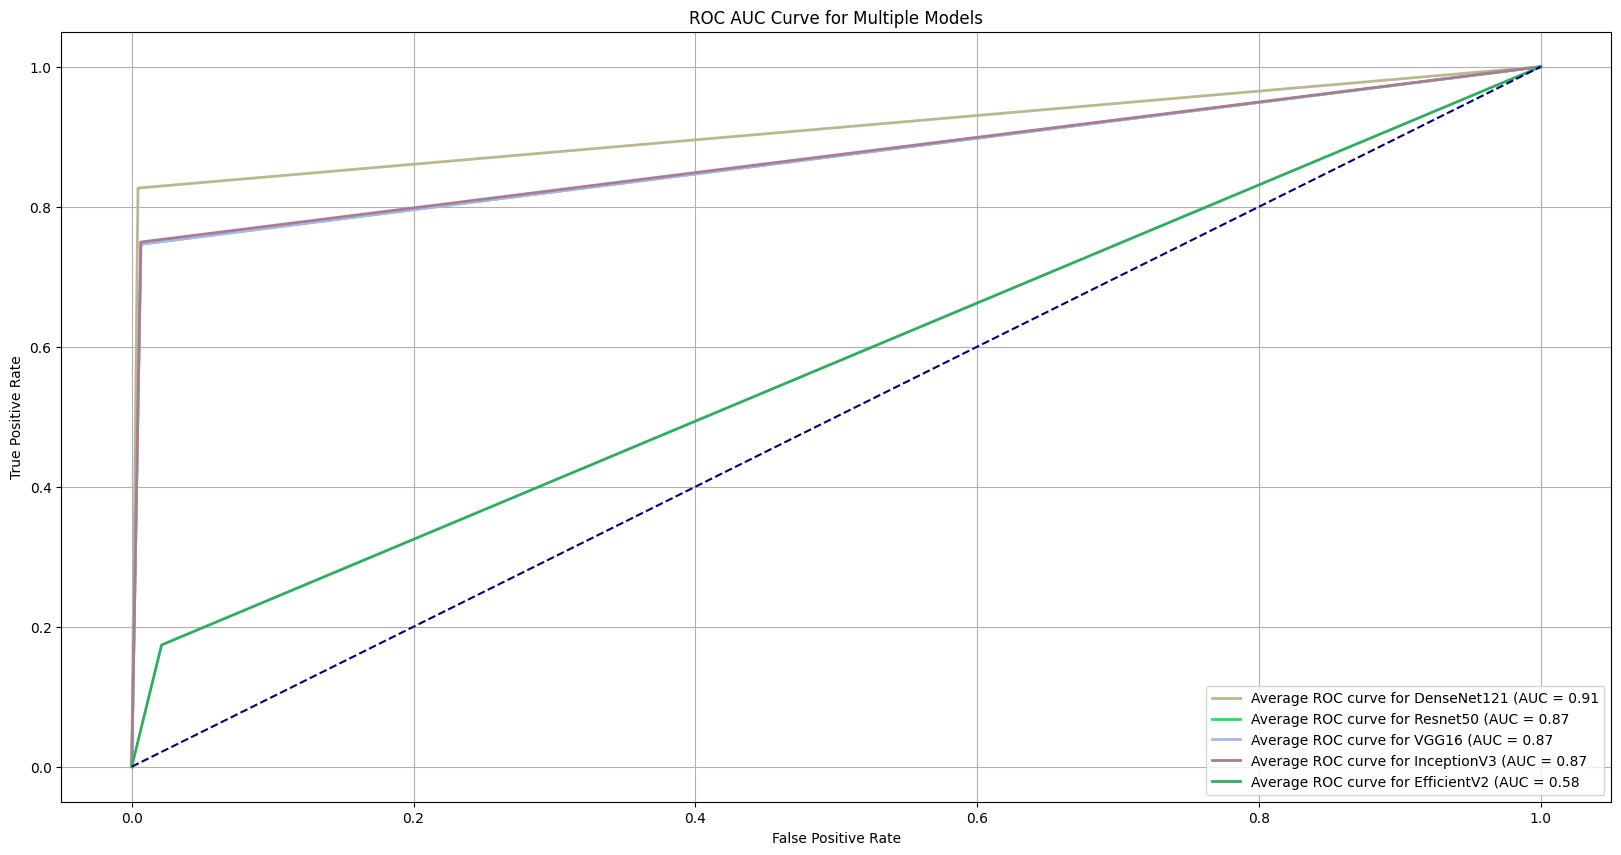

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

# Data for models
models = {
    'DenseNet121': (np.array(p_label_dense), np.array(t_label_dense)),
    'Resnet50': (np.array(p_label_resnet), np.array(t_label_resnet)),
    'VGG16': (np.array(p_label_vgg16), np.array(t_label_vgg16)),
    'InceptionV3': (np.array(p_label_inceptionV3), np.array(t_label_inceptionV3)),
    'EfficientV2': (np.array(p_label_efficientv2), np.array(t_label_efficientv2)),
}

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(20, 10))

for model_name, (predicted_labels, true_labels) in models.items():
        fpr, tpr, roc_auc = compute_roc_curve(true_labels, predicted_labels)
        plt.plot(fpr["micro"], tpr["micro"], color=random_color(), lw=lw,
                 label=f'Average ROC curve for {model_name} (AUC = {round(roc_auc["micro"],2)}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#Plotting losses of each model

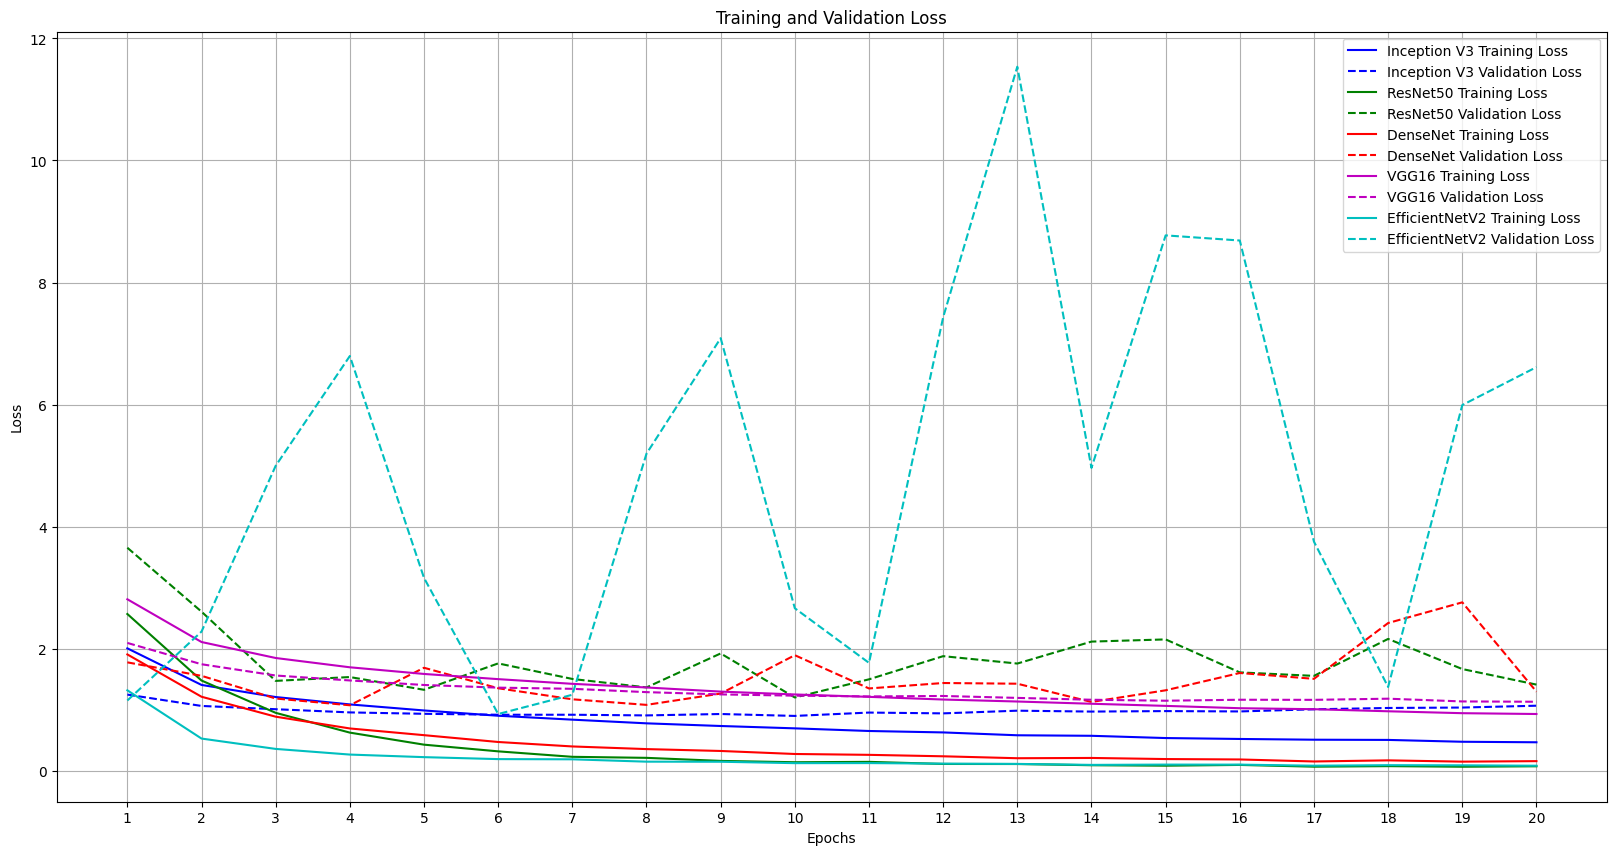

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, 21)  # Assuming there are 20 epochs

# Inception V3
plt.figure(figsize=(20, 10))
plt.plot(epochs, inception_V3_history['loss'], 'b-', label='Inception V3 Training Loss')
plt.plot(epochs, inception_V3_history['val_loss'], 'b--', label='Inception V3 Validation Loss')

# ResNet50
plt.plot(epochs, resnet50_history['loss'], 'g-', label='ResNet50 Training Loss')
plt.plot(epochs, resnet50_history['val_loss'], 'g--', label='ResNet50 Validation Loss')

# DenseNet
plt.plot(epochs, densenet_history['loss'], 'r-', label='DenseNet Training Loss')
plt.plot(epochs, densenet_history['val_loss'], 'r--', label='DenseNet Validation Loss')

# VGG16
plt.plot(epochs, vgg16_history['loss'], 'm-', label='VGG16 Training Loss')
plt.plot(epochs, vgg16_history['val_loss'], 'm--', label='VGG16 Validation Loss')

# # ViT
# plt.plot(epochs, Vit_history['loss'], 'c-', label='ViT Training Loss')
# plt.plot(epochs, Vit_history['val_loss'], 'c--', label='ViT Validation Loss')

#efficientnetV2
plt.plot(epochs, efficient_v2_history['loss'], 'c-', label='EfficientNetV2 Training Loss')
plt.plot(epochs, efficient_v2_history['val_loss'], 'c--', label='EfficientNetV2 Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.grid(True)
plt.show()


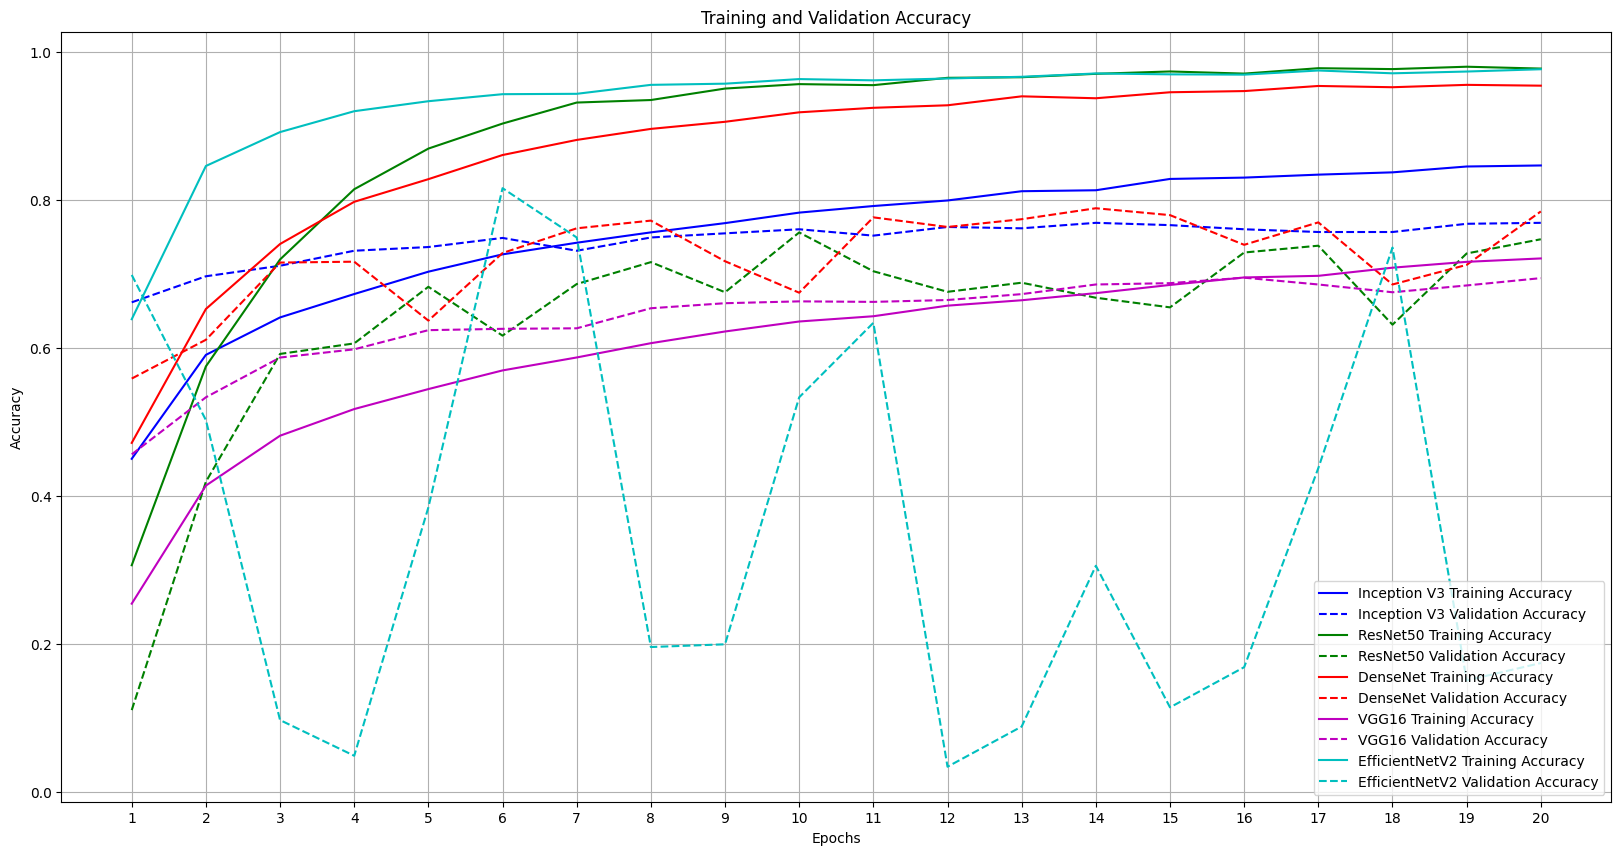

In [ ]:
# Inception V3
plt.figure(figsize=(20, 10))
plt.plot(epochs, inception_V3_history['accuracy'], 'b-', label='Inception V3 Training Accuracy')
plt.plot(epochs, inception_V3_history['val_accuracy'], 'b--', label='Inception V3 Validation Accuracy')

# ResNet50
plt.plot(epochs, resnet50_history['accuracy'], 'g-', label='ResNet50 Training Accuracy')
plt.plot(epochs, resnet50_history['val_accuracy'], 'g--', label='ResNet50 Validation Accuracy')

# DenseNet
plt.plot(epochs, densenet_history['accuracy'], 'r-', label='DenseNet Training Accuracy')
plt.plot(epochs, densenet_history['val_accuracy'], 'r--', label='DenseNet Validation Accuracy')

# VGG16
plt.plot(epochs, vgg16_history['accuracy'], 'm-', label='VGG16 Training Accuracy')
plt.plot(epochs, vgg16_history['val_accuracy'], 'm--', label='VGG16 Validation Accuracy')

# # ViT
# plt.plot(epochs, Vit_history['accuracy'], 'c-', label='ViT Training Accuracy')
# plt.plot(epochs, Vit_history['val_accuracy'], 'c--', label='ViT Validation Accuracy')

#efficientnetV2
plt.plot(epochs, efficient_v2_history['accuracy'], 'c-', label='EfficientNetV2 Training Accuracy')
plt.plot(epochs, efficient_v2_history['val_accuracy'], 'c--', label='EfficientNetV2 Validation Accuracy')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.xticks(epochs)
plt.show()
